# MC030 - Projeto final de Graduação
## Análise e Previsão do Mercado de Ações

## Descrição do modelo

A partir de um conjunto de cotações diárias de dólar para real (USD-BRL) desejamos modelar esse comportamento a partir de uma série de indicadores de mercado financeiro para classificarmos cada dia como um momento de compra ou momento de venda.

# ...

# Código

### Definindo endpoints da API (https://www.alphavantage.co/documentation/)

In [1]:
apiToken = '3GX5M109KQK9B6HO'
baseUrl = 'https://www.alphavantage.co/query?&outputsize=full&apikey=' + apiToken
usdBrlUrl = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=BRL&outputsize=full&apikey=' + apiToken
stockUrl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=demo'

### Obtendo dados da API

In [2]:
import requests
import json
import time

callsMade = 0

def incrementAndVerifyCallsMade():
    global callsMade
    callsMade += 1
    if callsMade == 5:
        print('Made 5 requests to the API in the last minute - sleeping for 1 minute')
        time.sleep(65)
        callsMade = 0

# returns [{date: {open, close, high, low, volume}}]
# all data is normalized/adjusted according to splits and dividends
def getStockPrice(stockSymbol):
    stockUrl = baseUrl + '&function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + stockSymbol
    print('Fetching ' + stockUrl)
    incrementAndVerifyCallsMade()
    stocksRetrieved = requests.get(stockUrl).json();
    stocks = parseAndAdjustPrice(stocksRetrieved['Time Series (Daily)'])
    print('Retrieved and parsed '+ stockSymbol)
    return stocks

### Parseando dados da API

In [3]:
def parseAndAdjustPrice(stocksRetrieved):
    stockPrices = {}
    splitFactor = 1.0
    dividendsFactor = 1.0
    i = 0
    
    for date in reversed(sorted(stocksRetrieved.keys())):
        # Calculando valores ajustados
        todayOpen = float(stocksRetrieved[date]['1. open']) * dividendsFactor / splitFactor
        todayHigh = float(stocksRetrieved[date]['2. high']) * dividendsFactor / splitFactor
        todayLow = float(stocksRetrieved[date]['3. low']) * dividendsFactor / splitFactor
        todayClose = float(stocksRetrieved[date]['4. close']) * dividendsFactor / splitFactor
        todayVolume = float(stocksRetrieved[date]['6. volume']) * splitFactor
        
#         # Analisando possível erro -- nao funciona por razões de arredondamento (api deve ter dados com mais casas decimais)
#         if (int(todayClose*10000) != int(float(stocksRetrieved[date]['5. adjusted close'])*10000)):
#             print('Adjusted values dont match: (calculated) ' + str(int(todayClose*10000)) + ' vs ' + str(int(float(stocksRetrieved[date]['5. adjusted close'])*10000)) + ' (api)')
#             print('Aborting operation')
#             raise Exception('Adjusted values dont match')
        
        stockPrices[date] = {
            'open': todayOpen,
            'close': todayClose,
            'high': todayHigh,
            'low': todayLow,
            'volume': todayVolume,
        }

        # Calculando fatores históricos de split e dividendos (que irão afetar datas antes da atual)
        if (i+1 < len(stocksRetrieved.keys())):
            yesterdayDate = list(reversed(sorted(stocksRetrieved.keys())))[i+1]
            yesterdayClose = float(stocksRetrieved[yesterdayDate]['4. close'])
            splitFactor *= float(stocksRetrieved[date]['8. split coefficient'])
            dividendsFactor *= (yesterdayClose-float(stocksRetrieved[date]['7. dividend amount']))/yesterdayClose
            i += 1
        
    print('Preço final normalizado (calculado): ' + str(stockPrices[sorted(stockPrices.keys())[0]]['close'])
         + ' | ' + sorted(stockPrices.keys())[0])
    print('Preço final normalizado (api): ' + str(stocksRetrieved[sorted(stocksRetrieved.keys())[0]]['5. adjusted close'])
         + ' | ' + sorted(stocksRetrieved.keys())[0])
        
    return stockPrices

# returns [{date: price}]
def simplifyStockPrices(stockPrices):
    stockPricesSimplified = {}
    for date, stockData in stockPrices.items():
        stockPricesSimplified[date] = stockData['open']
    return stockPricesSimplified

### Obtendo indicadores

In [4]:
from talib.abstract import *
import numpy as np

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicator(indicatorFunction, stockPrices):
    indicator = {}
    opens, highs, lows, closes, volumes = [], [], [], [], []
    
    for date in sorted(stockPrices.keys()):
        opens.append(stockPrices[date]['open'])
        highs.append(stockPrices[date]['high'])
        lows.append(stockPrices[date]['low'])
        closes.append(stockPrices[date]['close'])
        volumes.append(stockPrices[date]['volume'])
    
    inputs = {
        'open': np.array(opens),
        'high': np.array(highs),
        'low': np.array(lows),
        'close': np.array(closes),
        'volume': np.array(volumes)
    }
    
    if indicatorFunction=='SMA':
        indicatorList = SMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='EMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='WMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MACD':
        indicatorList, macdsignal, macdhist = MACD(inputs, fastperiod=12, slowperiod=26, signalperiod=9)
    elif indicatorFunction=='RSI':
        indicatorList = RSI(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='ADX':
        indicatorList = ADX(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='CCI':
        indicatorList = CCI(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MOM':
        indicatorList = MOM(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='WILLR':
        indicatorList = WILLR(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='AD':
        indicatorList = AD(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='ADOSC':
        indicatorList = ADOSC(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='OBV':
        indicatorList = OBV(inputs, timeperiod=10, price='open')
    
    i = 0
    indicators = {}
    for date in sorted(stockPrices.keys()):
        indicators[date] = {indicatorFunction: indicatorList[i]}
        i += 1
        
    print('Calculated and parsed indicator ' + indicatorFunction)
    return indicators

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicatorList(indicatorFunctions, stockPrices):
    indicators = {}
    for indicatorFunction in indicatorFunctions:
        indicatorDict = getIndicator(indicatorFunction, stockPrices)
        for date, indicator in indicatorDict.items():
            for indicatorFunction, indicatorValue in indicator.items():
                if  date not in indicators:
                    indicators[date] = {}
                indicators[date][indicatorFunction] = indicatorValue
    return indicators

In [5]:
# Filtrando dados válidos - apenas aqueles cujas datas estão na lista de preços e de indicadores
def filterData(stocks, indicators, indicatorFunctions):
    filteredStocks = {date: stock for date, stock in stocks.items() if date in indicators.keys()}
    filteredIndicators = {date: indicators for date, indicators in indicators.items() if date in stocks.keys()}
    return filteredStocks, filteredIndicators

def getData(stockSymbol, indicatorFunctions):
    stockPricesDetailed = getStockPrice(stockSymbol)
    indicators = getIndicatorList(indicatorFunctions, stockPricesDetailed)
    stockPrices, indicators = filterData(stockPricesDetailed, indicators, indicatorFunctions)
    return stockPricesDetailed, indicators

### Métodos de anotação de dados

In [6]:
import collections

def annotateBuyOrSellTwoClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'B'
            last = 'B'
        elif float(price) < yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'S'
            last = 'S'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateBuyOrSellEightClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.005:
            dateAnnotated[yesterdayDate] = 'B0'
            last = 'B0'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.01:
            dateAnnotated[yesterdayDate] = 'B1'
            last = 'B1'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.02:
            dateAnnotated[yesterdayDate] = 'B2'
            last = 'B2'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice > 1.02:
            dateAnnotated[yesterdayDate] = 'B3'
            last = 'B3'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .995:
            dateAnnotated[yesterdayDate] = 'S0'
            last = 'S0'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .99:
            dateAnnotated[yesterdayDate] = 'S1'
            last = 'S1'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .98:
            dateAnnotated[yesterdayDate] = 'S2'
            last = 'S2'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice < .98:
            dateAnnotated[yesterdayDate] = 'S3'
            last = 'S3'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateMaxProfit(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    yesterdayPrice = 0
    currentStatus = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice and currentStatus != 'B':
            dateAnnotated[yesterdayDate] = 'B'
            currentStatus = 'B'
        elif price < yesterdayPrice and currentStatus != 'S':
            dateAnnotated[yesterdayDate] = 'S'
            currentStatus = 'S'
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

### Normalização dos dados

In [7]:
import copy

# Normaliza um conjunto de indicadores a partir do preço da ação
def normalizeIndicators(indicatorSet, stocks):
    normalizedIndicatorSet = {}
    for indicatorFunction, indicatorValue in indicatorSet.items():
        # Normalizando baseado no preço
        if (indicatorFunction == 'SMA' or indicatorFunction == 'EMA'
            or indicatorFunction == 'ADX' or indicatorFunction == 'CCI' or indicatorFunction == 'MOM'
            or indicatorFunction == 'WILLR'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stocks['close'])
        # Normalizando baseado no volume
        elif (indicatorFunction == 'AD' or indicatorFunction == 'ADOSC' or indicatorFunction == 'OBV'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stocks['volume'])
        elif (indicatorFunction == 'MACD' or indicatorFunction == 'RSI'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/100.0
    return normalizedIndicatorSet

# Retorna os indicadores normalizados: indicadores = [date: {indicators: ['SMA': 0.89, 'EMA': 0.93], annotation: 'B'}]
def getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated):
    print('Normalizing and annotating indicators')
    indicatorsAnnotated = {}
    for date, annotation in dateAnnotated.items():
        if date not in indicatorsAnnotated:
            indicatorsAnnotated[date] = {'indicators': {}, 'annotation': ''}
        indicatorsAnnotated[date]['indicators'] = normalizeIndicators(indicators[date], stocks[date])
        indicatorsAnnotated[date]['annotation'] = annotation
    return indicatorsAnnotated

### Machine Learning

In [8]:
import keras
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

def getModelMLP(n_steps, n_features, n_outputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu', input_shape=(n_steps*n_features,)))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(n_steps*n_features*3, activation='relu', input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelBidirectionalLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(n_steps*n_features*3, activation='relu'), input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelCNN(n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation='relu'))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


### Análise de dados

In [9]:
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    return cm

### Main

In [10]:
# Cheat-sheet com os simbolos
__indicatorSymbols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA',
                      'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 
                      'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR',
                      'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI',
                      'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'SAR', 'TRANGE', 'ATR',
                      'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE',
                      'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
__forexSymbols = ['BRL', 'EUR']
__stockSymbols = ['MSFT']

# Definindo simbolos para o modelo
indicatorFunctions = {}
indicatorFunctions[3] = ['SMA','MOM','WILLR']
indicatorFunctions[6] = ['SMA','MOM','WILLR', 'MACD','ADX','RSI']
indicatorFunctions[8] = ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI']
indicatorFunctions[11] = ['SMA','EMA','MACD','RSI','ADX','CCI','MOM','WILLR','AD','OBV','ADOSC']
stockSymbol = 'MSFT'

stocks, indicators = getData(stockSymbol, indicatorFunctions[11])
stockPrices = simplifyStockPrices(stocks)
# forexPrices, indicators = getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions)
# dateAnnotated = annotateMaxProfit(stockPrices)

Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT
Preço final normalizado (calculado): 29.916038409186942 | 1999-12-07
Preço final normalizado (api): 29.9812 | 1999-12-07
Retrieved and parsed MSFT
Calculated and parsed indicator SMA
Calculated and parsed indicator EMA
Calculated and parsed indicator MACD
Calculated and parsed indicator RSI
Calculated and parsed indicator ADX
Calculated and parsed indicator CCI
Calculated and parsed indicator MOM
Calculated and parsed indicator WILLR
Calculated and parsed indicator AD
Calculated and parsed indicator OBV
Calculated and parsed indicator ADOSC


In [11]:
import pandas as pd

df = pd.DataFrame.from_dict(stockPrices, orient='index')

In [12]:
df[0] = df[0].astype('float')

In [13]:
div = df[0].astype('float').div(df[0].astype('float').shift(-1))

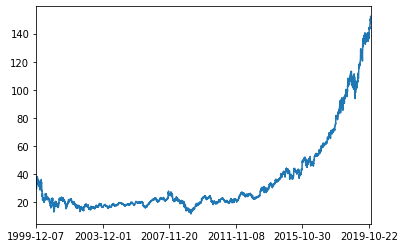

In [14]:
df.sort_index(inplace=True)
df[0].astype('float').plot()

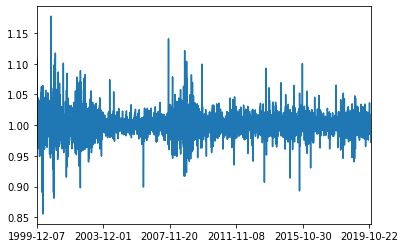

In [15]:
div.sort_index(inplace=True)
div.plot()

In [16]:
div.describe(percentiles=[.01,.1,.25,.5,.75,.9,.95,.99])

count    5032.000000
mean        1.000486
std         0.018360
min         0.855380
1%          0.951279
10%         0.981720
25%         0.991926
50%         1.000359
75%         1.008679
90%         1.019772
95%         1.027408
99%         1.052551
max         1.177514
Name: 0, dtype: float64

In [17]:
div

1999-12-07         NaN
1999-12-08    0.982797
1999-12-09    0.987973
1999-12-10    1.014891
1999-12-13    1.002570
                ...   
2019-12-02    0.998093
2019-12-03    0.971543
2019-12-04    1.017967
2019-12-05    0.999401
2019-12-06    1.006265
Name: 0, Length: 5033, dtype: float64

In [18]:
dateAnnotated = {}

dateAnnotated[2] = annotateBuyOrSellTwoClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[2], orient='index')
df[0].value_counts()

S    2570
B    2462
Name: 0, dtype: int64

In [19]:
dateAnnotated[8] = annotateBuyOrSellEightClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[8], orient='index')
df[0].value_counts()

S0    811
B0    810
S2    643
S1    640
B2    615
B1    588
S3    476
B3    449
Name: 0, dtype: int64

In [20]:
import pandas as pd

normalizedIndicators = {}
normalizedIndicators[2] = getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated[2])
normalizedIndicators[8] = getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated[8])

data = {}
data[2] = pd.DataFrame.from_dict(normalizedIndicators[2], orient='index')
data[8] = pd.DataFrame.from_dict(normalizedIndicators[8], orient='index')

Normalizing and annotating indicators
Normalizing and annotating indicators


In [21]:
data[2] = pd.DataFrame.merge(pd.DataFrame(data[2].indicators.values.tolist(), index=data[2].index), data[2], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])
data[8] = pd.DataFrame.merge(pd.DataFrame(data[8].indicators.values.tolist(), index=data[8].index), data[8], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])

In [22]:
data[2].head(), data[8].head()

(                 SMA       EMA      MACD       RSI       ADX       CCI  \
 2019-12-06  0.992646  0.989418  0.020722  0.602768  0.220394  0.324553   
 2019-12-05  1.003635  1.000175  0.020635  0.566020  0.236385 -0.183451   
 2019-12-04  1.004344  1.000570  0.022076  0.570568  0.262123 -0.238616   
 2019-12-03  1.008130  1.003884  0.023677  0.454379  0.290429 -0.820445   
 2019-12-02  1.007897  1.005839  0.025925  0.753485  0.313944 -0.257423   
 
                  MOM     WILLR          AD        OBV     ADOSC annotation  
 2019-12-06  0.010478 -0.084484 -184.709190  43.656537  1.277261          S  
 2019-12-05 -0.001734 -0.293014 -170.301912  39.149178  1.033093          B  
 2019-12-04 -0.001524 -0.302297 -173.280478  40.834257  1.088390          S  
 2019-12-03 -0.013871 -0.365213 -121.153665  27.798777  0.694448          B  
 2019-12-02  0.022635 -0.471910 -111.930588  26.407262  0.511945          B  ,
                  SMA       EMA      MACD       RSI       ADX       CCI  \
 201

In [23]:
data[2].annotation = data[2].annotation.apply(lambda x: 0 if x == 'S' else 1)

eight_dict = {"B3":0, "B2": 1, "B1": 2, "B0": 3, "S0": 4, "S1": 5, "S2": 6, "S3": 7}
data[8].annotation = data[8].annotation.apply(lambda x: eight_dict[x])

In [24]:
data[2] = data[2].sort_index()
data[8] = data[8].sort_index()

In [25]:
data[2] = data[2].dropna()
data[8] = data[8].dropna()

In [26]:
len(data[2]), len(data[8])

(5000, 5000)

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

data_analysis = pd.DataFrame.merge(data[2], div, left_index=True, right_index=True, how='inner')
X = data_analysis.iloc[:,:8]
y = data_analysis.iloc[:,-1:]

In [28]:
bestfeatures = SelectKBest(score_func=f_classif, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(8,'Score'))

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   Specs     Score
2   MACD  1.811937
0    SMA  1.607062
1    EMA  1.500138
6    MOM  1.334233
4    ADX  1.190124
5    CCI  1.102884
3    RSI  1.012741
7  WILLR  0.951896


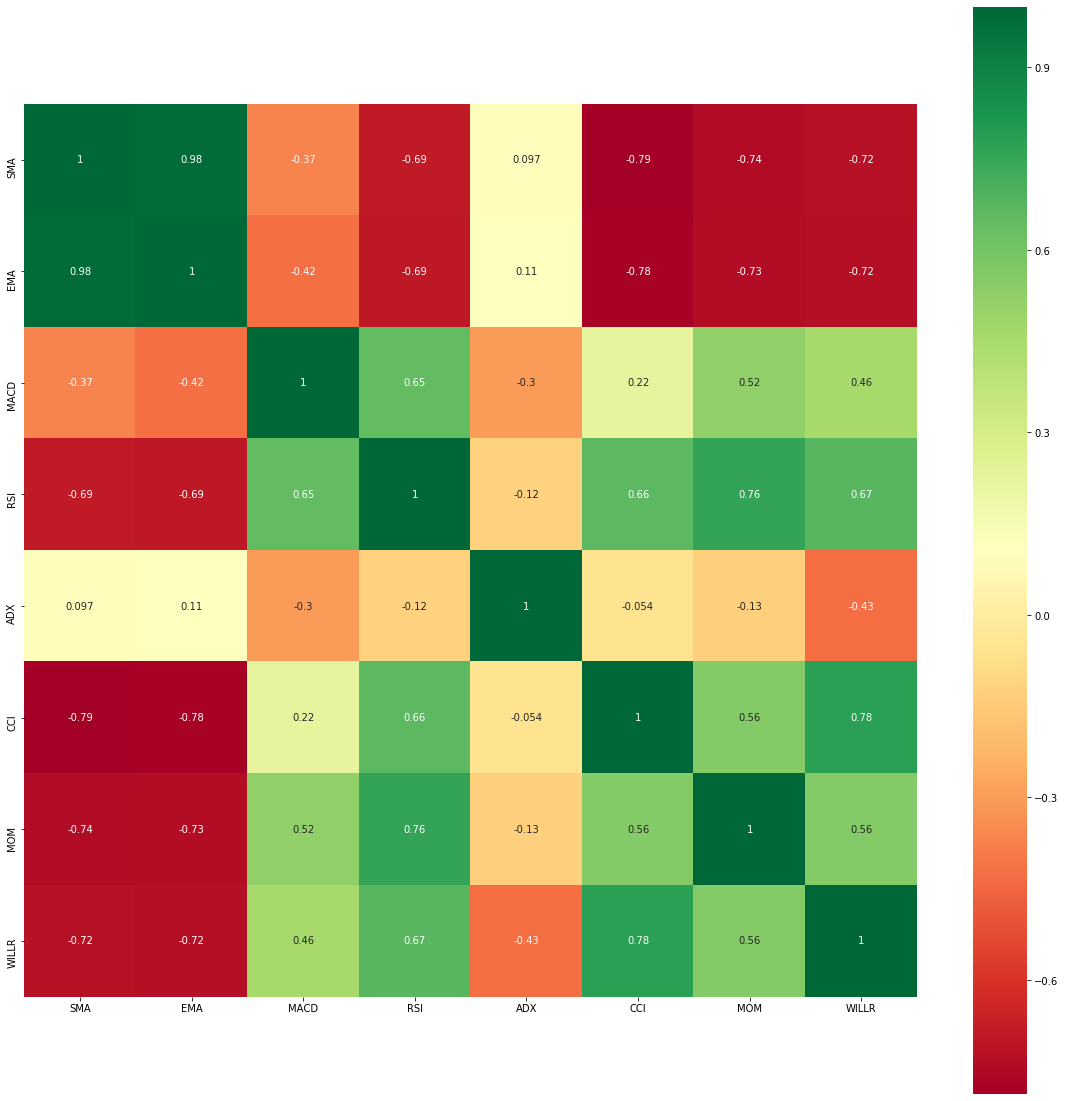

In [29]:
corrmat = data_analysis.iloc[:,:8].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
plt.axis('scaled')
g=sns.heatmap(data_analysis[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [30]:
import numpy as np
import matplotlib.pyplot as plt

models = ["mlp","lstm"]
classes = {2: ["S","B"],
           8: ["B3","B2","B1","B0","S0","S1","S2","S3"]}
n_classes = [2, 8]
n_steps = [2,5,10]
n_indicators = [3, 6, 8, 11]
n_indicators_names = {
    3: ['SMA','MOM','WILLR'], 
    6: ['SMA','MOM','WILLR', 'MACD','ADX','RSI'],
    8: ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI'],
    11: ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI','AD','OBV','ADOSC']
}

batch_size = 32
train_split = .8

# X [d: (all, train, test)] [m: type(mlp/lstm)] [c: classes(2, 8)] [s: n_steps(2,5,10)] [i: indicators(3, 6)] 

In [31]:
X = {}
y = {}
for a in ["all", "train", "test"]:
    X[a] = {}
    y[a] = {}
    for m in models:
        X[a][m] = {}
        y[a][m] = {}
        for c in n_classes:
            X[a][m][c] = {}
            y[a][m][c] = {}
            for s in n_steps:
                X[a][m][c][s] = {}
                y[a][m][c][s] = {}
                for i in n_indicators:
                    X[a][m][c][s][i] = []
                    y[a][m][c][s][i] = []
                    if a == "all":
                        for d in range(len(data[c])):
                            end_ix = d + s
                            if end_ix > len(data[c]):
                                break
                            seq_x, seq_y = data[c].loc[data[c].index.isin(data[c].index[d:end_ix]), n_indicators_names[i]].values, data[c].iloc[end_ix-1, -1]
                            if m == "lstm":
                                X[a][m][c][s][i].append(seq_x)
                            else:
                                X[a][m][c][s][i].append(seq_x.flatten())
                            if c == 2:
                                y[a][m][c][s][i].append(seq_y)
                            else:
                                y[a][m][c][s][i].append(np.eye(c)[seq_y])
                        X[a][m][c][s][i] = np.array(X[a][m][c][s][i])
                        y[a][m][c][s][i] = np.array(y[a][m][c][s][i])

In [32]:
a = 'all'
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

(4999, 6) (4999,)
(4999, 12) (4999,)
(4999, 16) (4999,)
(4999, 22) (4999,)
(4996, 15) (4996,)
(4996, 30) (4996,)
(4996, 40) (4996,)
(4996, 55) (4996,)
(4991, 30) (4991,)
(4991, 60) (4991,)
(4991, 80) (4991,)
(4991, 110) (4991,)
(4999, 6) (4999, 8)
(4999, 12) (4999, 8)
(4999, 16) (4999, 8)
(4999, 22) (4999, 8)
(4996, 15) (4996, 8)
(4996, 30) (4996, 8)
(4996, 40) (4996, 8)
(4996, 55) (4996, 8)
(4991, 30) (4991, 8)
(4991, 60) (4991, 8)
(4991, 80) (4991, 8)
(4991, 110) (4991, 8)
(4999, 2, 3) (4999,)
(4999, 2, 6) (4999,)
(4999, 2, 8) (4999,)
(4999, 2, 11) (4999,)
(4996, 5, 3) (4996,)
(4996, 5, 6) (4996,)
(4996, 5, 8) (4996,)
(4996, 5, 11) (4996,)
(4991, 10, 3) (4991,)
(4991, 10, 6) (4991,)
(4991, 10, 8) (4991,)
(4991, 10, 11) (4991,)
(4999, 2, 3) (4999, 8)
(4999, 2, 6) (4999, 8)
(4999, 2, 8) (4999, 8)
(4999, 2, 11) (4999, 8)
(4996, 5, 3) (4996, 8)
(4996, 5, 6) (4996, 8)
(4996, 5, 8) (4996, 8)
(4996, 5, 11) (4996, 8)
(4991, 10, 3) (4991, 8)
(4991, 10, 6) (4991, 8)
(4991, 10, 8) (4991, 8)
(49

In [33]:
data[2].head()

,SMA,EMA,MACD,RSI,ADX,CCI,MOM,WILLR,AD,OBV,ADOSC,annotation
2000-01-25,1.043410,1.039785,-0.001171,0.355626,0.934856,-3.538954,-0.121000,-2.443619,3.209318,1.580731,-0.795019,1
2000-01-26,1.070414,1.067619,-0.003234,0.393065,0.993284,-3.808283,-0.091174,-3.083409,3.003382,2.915616,-1.123820,0
2000-01-27,1.068415,1.062908,-0.004972,0.352740,1.039644,-3.651893,-0.087190,-2.902748,2.090577,1.261093,-0.919095,1
2000-01-28,1.067491,1.055656,-0.006406,0.326877,1.081229,-3.101554,-0.063613,-2.999704,1.952186,0.378687,-1.040784,1
2000-01-31,1.061858,1.048425,-0.007553,0.319523,1.139285,-3.299816,-0.097783,-2.735808,2.360177,-0.698758,-0.507534,1


In [34]:
X["all"]["lstm"][2][5][6][0]

array([[ 1.04341017e+00, -1.20999903e-01, -2.44361932e+00,
        -1.17114841e-03,  9.34855901e-01,  3.55626363e-01],
       [ 1.07041361e+00, -9.11743987e-02, -3.08340923e+00,
        -3.23380846e-03,  9.93284000e-01,  3.93065499e-01],
       [ 1.06841519e+00, -8.71898734e-02, -2.90274834e+00,
        -4.97209778e-03,  1.03964359e+00,  3.52740150e-01],
       [ 1.06749109e+00, -6.36132316e-02, -2.99970428e+00,
        -6.40564783e-03,  1.08122911e+00,  3.26876629e-01],
       [ 1.06185757e+00, -9.77827731e-02, -2.73580799e+00,
        -7.55331221e-03,  1.13928539e+00,  3.19523208e-01]])

In [35]:
X["all"]["mlp"][2][2][6][0]

array([ 1.04341017e+00, -1.20999903e-01, -2.44361932e+00, -1.17114841e-03,
        9.34855901e-01,  3.55626363e-01,  1.07041361e+00, -9.11743987e-02,
       -3.08340923e+00, -3.23380846e-03,  9.93284000e-01,  3.93065499e-01])

In [36]:
from sklearn.model_selection import train_test_split

for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                if m == "mlp":
                    X['train'][m][c][s][i], X['test'][m][c][s][i], y['train'][m][c][s][i], y['test'][m][c][s][i] = train_test_split(X['all'][m][c][s][i], y['all'][m][c][s][i], train_size=train_split, random_state=0)
                else:
                    X['train'][m][c][s][i] = X['all'][m][c][s][i][:int(len(X['all'][m][c][s][i])*train_split)]
                    X['test'][m][c][s][i] = X['all'][m][c][s][i][int(len(X['all'][m][c][s][i])*train_split):]
                    y['train'][m][c][s][i] = y['all'][m][c][s][i][:int(len(y['all'][m][c][s][i])*train_split)]
                    y['test'][m][c][s][i] = y['all'][m][c][s][i][int(len(y['all'][m][c][s][i])*train_split):]

In [37]:
for a in ['train','test']:
    for m in models:
        for c in n_classes:
            for s in n_steps:
                for i in n_indicators:
                    print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

(3999, 6) (3999,)
(3999, 12) (3999,)
(3999, 16) (3999,)
(3999, 22) (3999,)
(3996, 15) (3996,)
(3996, 30) (3996,)
(3996, 40) (3996,)
(3996, 55) (3996,)
(3992, 30) (3992,)
(3992, 60) (3992,)
(3992, 80) (3992,)
(3992, 110) (3992,)
(3999, 6) (3999, 8)
(3999, 12) (3999, 8)
(3999, 16) (3999, 8)
(3999, 22) (3999, 8)
(3996, 15) (3996, 8)
(3996, 30) (3996, 8)
(3996, 40) (3996, 8)
(3996, 55) (3996, 8)
(3992, 30) (3992, 8)
(3992, 60) (3992, 8)
(3992, 80) (3992, 8)
(3992, 110) (3992, 8)
(3999, 2, 3) (3999,)
(3999, 2, 6) (3999,)
(3999, 2, 8) (3999,)
(3999, 2, 11) (3999,)
(3996, 5, 3) (3996,)
(3996, 5, 6) (3996,)
(3996, 5, 8) (3996,)
(3996, 5, 11) (3996,)
(3992, 10, 3) (3992,)
(3992, 10, 6) (3992,)
(3992, 10, 8) (3992,)
(3992, 10, 11) (3992,)
(3999, 2, 3) (3999, 8)
(3999, 2, 6) (3999, 8)
(3999, 2, 8) (3999, 8)
(3999, 2, 11) (3999, 8)
(3996, 5, 3) (3996, 8)
(3996, 5, 6) (3996, 8)
(3996, 5, 8) (3996, 8)
(3996, 5, 11) (3996, 8)
(3992, 10, 3) (3992, 8)
(3992, 10, 6) (3992, 8)
(3992, 10, 8) (3992, 8)
(39

In [38]:
Models = {}
for m in models:
    Models[m] = {}
    for c in n_classes:
        Models[m][c] = {}
        for s in n_steps:
            Models[m][c][s] = {}
            for i in n_indicators:
                Models[m][c][s][i] = {}
                if c == 2:
                    out = 1
                else:
                    out = c
                if m == "mlp":
                    Models[m][c][s][i] = getModelMLP(s, i, out)
                else:
                    Models[m][c][s][i] = getModelBidirectionalLSTM(s, i, out)

In [39]:
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(Models[m][c][s][i])

In [40]:
history = {}
preds = {}
conf = {}
for m in models:
    history[m] = {}
    preds[m] = {}
    conf[m] = {}
    for c in n_classes:
        history[m][c] = {}
        preds[m][c] = {}
        conf[m][c] = {}
        for s in n_steps:
            history[m][c][s] = {}
            preds[m][c][s] = {}
            conf[m][c][s] = {}
            for i in n_indicators:
                history[m][c][s][i] = {}
                preds[m][c][s][i] = {}
                conf[m][c][s][i] = {}

In [41]:
# Calculando lucro/prejuízo total, supondo que inicialmente temos US$1000 em carteira
import copy

def calculateOptimalProfit(preds):
    prices = copy.deepcopy(stockPrices)
    for date in sorted(stockPrices.keys()):
        if len(prices) == len(preds):
            break
        del prices[date]

    initialMoney = 1000.00
    index = 0
    currentMoney = initialMoney
    currentStocks = 0.0
    moneyDict = {}
    
    for date in sorted(prices.keys())[:-1]:
        todayPrice = float(prices[date])
        tomorrowPrice = float(prices[sorted(prices.keys())[index+1]])
        if tomorrowPrice > todayPrice and currentMoney != 0:
            currentStocks = currentMoney/todayPrice
            currentMoney = 0
        elif tomorrowPrice < todayPrice and currentStocks != 0:
            currentMoney = currentStocks*todayPrice
            currentStocks = 0.0
        moneyDict[date] = currentMoney + currentStocks*todayPrice
        index += 1

    firstPrice = float(prices[sorted(prices.keys())[0]])
    lastPrice = float(prices[sorted(prices.keys())[-1]])

    if currentMoney == 0:
        finalMoney = currentStocks*lastPrice
    else:
        finalMoney = currentMoney
        
    stockGrowthPercentage = 100.0*(lastPrice/firstPrice-1)
    moneyGrowthPercentage = 100.0*(finalMoney/initialMoney-1)
    timeLenInYears = len(prices)/252.0
    moneyGrowthPerYear = 100.0 * ((finalMoney/initialMoney) ** (1/timeLenInYears) - 1)
    print("First date:\t   " + sorted(prices.keys())[1] + "\t| Initial stock value: US$ " + str(firstPrice))
    print("Last date:\t   " + sorted(prices.keys())[-1] + "\t| Final stock value: US$ " + str(lastPrice))
    print("Stock value growth:\t" + str(round(stockGrowthPercentage, 2)) + "%")
    print("[DEBUG] Initial money:    US$ " + str(round(initialMoney, 2)) + " | Final money: US$ " + str(round(finalMoney, 2)))
    print("[DEBUG] Final profit:\t   US$ " + str(round(finalMoney-initialMoney, 2)) + " over " + str(round(timeLenInYears, 2)) + " years")
    print("Money growth:      \t" + str(round(moneyGrowthPercentage, 2)) + "%")
    print("Growth per year:   \t" + str(round(moneyGrowthPerYear, 2)) + "%")
    
    # Plottando gráfico de lucro
    moneyDf = pd.DataFrame.from_dict(moneyDict, orient='index')
    moneyDf.sort_index(inplace=True)
    graphAx = moneyDf[0].astype('float').plot()

def calculateProfit(preds):
    
    if any(item in list(np.argmax(preds, axis=1)) for item in [2, 3, 4, 5, 6, 7]):
        classificationArray = list(np.argmax(preds, axis=1))
    else:
        classificationArray = []
        for predValue in preds:
            if predValue < 0.5:
                classificationArray.append(0)
            else:
                classificationArray.append(1)
    
    print(classificationArray)
    if (max(classificationArray) == 1):
        buyClassification = [0]
        sellClassification = [1]
        print("Using simple buy/sell (2 classes) classification")
    else:
        buyClassification = [0, 1, 2, 3]
        sellClassification = [4, 5, 6, 7]
        print("Using complex buy/sell (8 classes) classification")

    prices = copy.deepcopy(stockPrices)

    for date in sorted(stockPrices.keys()):
        if len(prices) == len(classificationArray):
            break
        del prices[date]

    initialMoney = 1000.00
    index = 0
    currentMoney = initialMoney
    currentStocks = 0.0
    moneyDict = {}

    for date in sorted(prices.keys()):
        stockPrice = float(prices[date])
        classification = classificationArray[index]
        if currentMoney != 0 and classification in buyClassification:
            currentStocks = currentMoney/stockPrice
            currentMoney = 0.0
        elif currentStocks != 0 and classification in sellClassification:
            currentMoney = currentStocks*stockPrice
            currentStocks = 0.0
        moneyDict[date] = currentMoney + currentStocks*stockPrice
        index += 1

    firstPrice = float(prices[sorted(prices.keys())[0]])
    lastPrice = float(prices[sorted(prices.keys())[-1]])

    if currentMoney == 0:
        finalMoney = currentStocks*lastPrice
    else:
        finalMoney = currentMoney

    stockGrowthPercentage = 100.0*(lastPrice/firstPrice-1)
    moneyGrowthPercentage = 100.0*(finalMoney/initialMoney-1)
#     moneyGrowthPerYear = (finalMoney-initialMoney)/timeLenInYears
    timeLenInYears = len(prices)/252.0
    moneyGrowthPerYear = 100.0 * ((finalMoney/initialMoney) ** (1/timeLenInYears) - 1)

#     print("[DEBUG] Current money:\t   US$ " + str(round(currentMoney, 2)))
#     print("[DEBUG] Current stocks:\t   " + str(round(currentStocks, 2)) + "\t| Last stock-price: US$ " + str(round(lastPrice, 2)))
    print("First date:\t   " + sorted(prices.keys())[1] + "\t| Initial stock value: US$ " + str(firstPrice))
    print("Last date:\t   " + sorted(prices.keys())[-1] + "\t| Final stock value: US$ " + str(lastPrice))
    print("Stock value growth:\t" + str(round(stockGrowthPercentage, 2)) + "%")
    print("[DEBUG] Initial money:    US$ " + str(round(initialMoney, 2)) + " | Final money: US$ " + str(round(finalMoney, 2)))
    print("[DEBUG] Final profit:\t   US$ " + str(round(finalMoney-initialMoney, 2)) + " over " + str(round(timeLenInYears, 2)) + " years")
    print("Money growth:      \t" + str(round(moneyGrowthPercentage, 2)) + "%")
    print("Growth per year:   \t" + str(round(moneyGrowthPerYear, 2)) + "%")
    
    # Plottando gráfico de lucro
    moneyDf = pd.DataFrame.from_dict(moneyDict, orient='index')
    moneyDf.sort_index(inplace=True)
    graphAx = moneyDf[0].astype('float').plot()
#     pricesDf = pd.DataFrame.from_dict(prices, orient='index')
#     pricesDf.sort_index(inplace=True)
#     pricesDf[0].astype('float').plot(ax=graphAx)

    return round(moneyGrowthPerYear, 2)

In [42]:
def fit(m, c, s, i):
    history[m][c][s][i] = Models[m][c][s][i].fit(
        X['train'][m][c][s][i], 
        y['train'][m][c][s][i], 
        epochs=300, 
        verbose=1,
        batch_size=batch_size)
    plt.plot(history[m][c][s][i].history['loss'], label='train')
#     plt.plot(history[m][c][s][i].history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
def predict(m, c, s, i):
    preds[m][c][s][i] = Models[m][c][s][i].predict(
        X['test'][m][c][s][i], 
        batch_size=batch_size)
    print(f"Model {m}\nNumber of classes {c}\nNumber of steps {s}\nNumber of indicators {i}")
    print(classification_report(y['test'][m][c][s][i], 
                                np.rint(preds[m][c][s][i]).astype(np.int64), 
                                target_names=classes[c], 
                                digits=5))
    if c == 2:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i], 
                                                 np.rint(preds[m][c][s][i]).astype(np.int64), 
                                                 classes=np.array(classes[c]))
    else:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i].argmax(axis=1), 
                                                 np.rint(preds[m][c][s][i]).argmax(axis=1), 
                                                 classes=np.array(classes[c]))
        
def get_next_value(m, c, s, i):
    i = n_indicators[(n_indicators.index(i) + 1)%len(n_indicators)]
    if (n_indicators.index(i) == 0):
        s = n_steps[(n_steps.index(s) + 1)%len(n_steps)]
        if (n_steps.index(s) == 0):
            c = n_classes[(n_classes.index(c) + 1)%len(n_classes)]
            if (n_classes.index(c) == 0):
                m = models[(models.index(m) + 1)%len(models)]    
    return m, c, s, i

In [43]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

for x in range(48):
    Models[m][c][s][i].summary()
    m, c, s, i = get_next_value(m, c, s, i)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Outpu

Epoch 1/300
3999/3999 [==============================] - 2s 382us/step - loss: 0.6919 - accuracy: 0.5431
Epoch 2/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.6706 - accuracy: 0.6002
Epoch 3/300
3999/3999 [==============================] - 0s 97us/step - loss: 0.6676 - accuracy: 0.6002
Epoch 4/300
3999/3999 [==============================] - 0s 118us/step - loss: 0.6626 - accuracy: 0.6064
Epoch 5/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.6620 - accuracy: 0.5979
Epoch 6/300
3999/3999 [==============================] - 0s 87us/step - loss: 0.6605 - accuracy: 0.6017
Epoch 7/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6589 - accuracy: 0.6114
Epoch 8/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6570 - accuracy: 0.6112
Epoch 9/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.6539 - accuracy: 0.6104
Epoch 10/300
3999/3999 [==============================] - 0s

3999/3999 [==============================] - 1s 218us/step - loss: 0.5448 - accuracy: 0.7232
Epoch 78/300
3999/3999 [==============================] - 1s 246us/step - loss: 0.5480 - accuracy: 0.7259
Epoch 79/300
3999/3999 [==============================] - 1s 155us/step - loss: 0.5539 - accuracy: 0.71020s - loss: 0.5453 - 
Epoch 80/300
3999/3999 [==============================] - 1s 194us/step - loss: 0.5444 - accuracy: 0.7259
Epoch 81/300
3999/3999 [==============================] - 1s 219us/step - loss: 0.5462 - accuracy: 0.7294
Epoch 82/300
3999/3999 [==============================] - 1s 222us/step - loss: 0.5439 - accuracy: 0.7284
Epoch 83/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.5422 - accuracy: 0.7237
Epoch 84/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.5398 - accuracy: 0.7327
Epoch 85/300
3999/3999 [==============================] - 1s 161us/step - loss: 0.5445 - accuracy: 0.7367
Epoch 86/300
3999/3999 [===============

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129841). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 232us/step - loss: 0.5375 - accuracy: 0.7417
Epoch 94/300
3999/3999 [==============================] - 1s 204us/step - loss: 0.5334 - accuracy: 0.7354
Epoch 95/300
3999/3999 [==============================] - 1s 208us/step - loss: 0.5293 - accuracy: 0.7357
Epoch 96/300
3999/3999 [==============================] - 1s 329us/step - loss: 0.5352 - accuracy: 0.72920s - loss: 0.5352 - accuracy: 0.72
Epoch 97/300
3999/3999 [==============================] - 1s 227us/step - loss: 0.5241 - accuracy: 0.7379
Epoch 98/300
3999/3999 [==============================] - 1s 175us/step - loss: 0.5359 - accuracy: 0.7402
Epoch 99/300
3999/3999 [==============================] - 1s 205us/step - loss: 0.5326 - accuracy: 0.73670s - loss: 0.5297 - accuracy: 
Epoch 100/300
3999/3999 [==============================] - 1s 291us/step - loss: 0.5297 - accuracy: 0.7389
Epoch 101/300
3999/3999 [==============================] - 1s 230us/step - loss: 0.5281 - accuracy: 

3999/3999 [==============================] - 1s 185us/step - loss: 0.5251 - accuracy: 0.7412
Epoch 168/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.5133 - accuracy: 0.7609
Epoch 169/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.5175 - accuracy: 0.7524
Epoch 170/300
3999/3999 [==============================] - 1s 129us/step - loss: 0.5111 - accuracy: 0.7542
Epoch 171/300
3999/3999 [==============================] - 1s 149us/step - loss: 0.5193 - accuracy: 0.7554
Epoch 172/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.5139 - accuracy: 0.7537
Epoch 173/300
3999/3999 [==============================] - 1s 129us/step - loss: 0.5219 - accuracy: 0.7587
Epoch 174/300
3999/3999 [==============================] - 1s 276us/step - loss: 0.5107 - accuracy: 0.7584
Epoch 175/300
3999/3999 [==============================] - 1s 255us/step - loss: 0.5107 - accuracy: 0.7524
Epoch 176/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 197us/step - loss: 0.5108 - accuracy: 0.7579
Epoch 243/300
3999/3999 [==============================] - 1s 172us/step - loss: 0.5110 - accuracy: 0.7577
Epoch 244/300
3999/3999 [==============================] - 1s 142us/step - loss: 0.5137 - accuracy: 0.7572
Epoch 245/300
3999/3999 [==============================] - 1s 135us/step - loss: 0.5176 - accuracy: 0.7469
Epoch 246/300
3999/3999 [==============================] - 0s 124us/step - loss: 0.5143 - accuracy: 0.7504
Epoch 247/300
3999/3999 [==============================] - 1s 142us/step - loss: 0.5139 - accuracy: 0.7584
Epoch 248/300
3999/3999 [==============================] - 0s 120us/step - loss: 0.5104 - accuracy: 0.7569
Epoch 249/300
3999/3999 [==============================] - 0s 120us/step - loss: 0.5126 - accuracy: 0.7539
Epoch 250/300
3999/3999 [==============================] - 1s 126us/step - loss: 0.5200 - accuracy: 0.7482
Epoch 251/300
3999/3999 [==========================

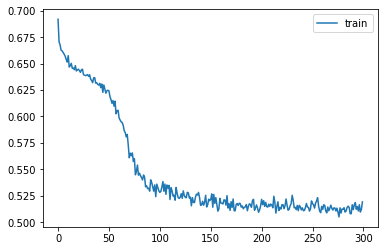

In [44]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

           S    0.77778   0.68571   0.72885       490
           B    0.72887   0.81176   0.76809       510

    accuracy                        0.75000      1000
   macro avg    0.75333   0.74874   0.74847      1000
weighted avg    0.75284   0.75000   0.74886      1000

Confusion matrix, without normalization
[[336 154]
 [ 96 414]]


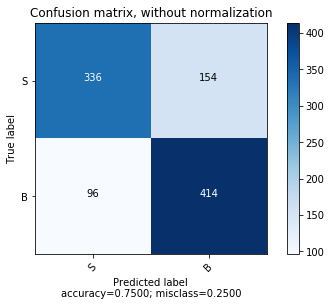

[0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 

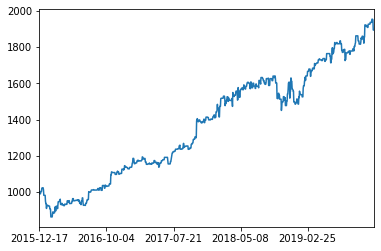

In [45]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 335us/step - loss: 0.6666 - accuracy: 0.5949
Epoch 2/300
3999/3999 [==============================] - 0s 105us/step - loss: 0.6449 - accuracy: 0.6357
Epoch 3/300
3999/3999 [==============================] - 0s 103us/step - loss: 0.6339 - accuracy: 0.6404
Epoch 4/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.6229 - accuracy: 0.6542
Epoch 5/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.6097 - accuracy: 0.6762
Epoch 6/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.5934 - accuracy: 0.6849
Epoch 7/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.5794 - accuracy: 0.7034
Epoch 8/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.5498 - accuracy: 0.7297
Epoch 9/300
3999/3999 [==============================] - 1s 182us/step - loss: 0.5263 - accuracy: 0.7502
Epoch 10/300
3999/3999 [==============================] -

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151222). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 245us/step - loss: 0.1495 - accuracy: 0.9382
Epoch 58/300
3999/3999 [==============================] - 2s 471us/step - loss: 0.1464 - accuracy: 0.9402
Epoch 59/300
3999/3999 [==============================] - 1s 320us/step - loss: 0.1324 - accuracy: 0.9495
Epoch 60/300
3999/3999 [==============================] - 1s 200us/step - loss: 0.1587 - accuracy: 0.9392
Epoch 61/300
3999/3999 [==============================] - 1s 278us/step - loss: 0.1424 - accuracy: 0.9417
Epoch 62/300
3999/3999 [==============================] - 1s 272us/step - loss: 0.1390 - accuracy: 0.9430
Epoch 63/300
3999/3999 [==============================] - 1s 335us/step - loss: 0.1398 - accuracy: 0.9427
Epoch 64/300
3999/3999 [==============================] - 2s 565us/step - loss: 0.1323 - accuracy: 0.9472
Epoch 65/300
3999/3999 [==============================] - 1s 312us/step - loss: 0.1424 - accuracy: 0.9452
Epoch 66/300
3999/3999 [==============================] - 1

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128962). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 333us/step - loss: 0.0833 - accuracy: 0.9652
Epoch 123/300
3999/3999 [==============================] - 1s 353us/step - loss: 0.1184 - accuracy: 0.9530
Epoch 124/300
1088/3999 [=======>......................] - ETA: 0s - loss: 0.1128 - accuracy: 0.9485

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.234698). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 442us/step - loss: 0.1094 - accuracy: 0.9510
Epoch 125/300
3999/3999 [==============================] - 2s 410us/step - loss: 0.1056 - accuracy: 0.95420s - loss: 0.0905 - 
Epoch 126/300
3999/3999 [==============================] - 2s 429us/step - loss: 0.0940 - accuracy: 0.9602
Epoch 127/300
3999/3999 [==============================] - 1s 317us/step - loss: 0.0995 - accuracy: 0.9585
Epoch 128/300
3999/3999 [==============================] - 2s 429us/step - loss: 0.1028 - accuracy: 0.9540
Epoch 129/300
3999/3999 [==============================] - 1s 367us/step - loss: 0.0917 - accuracy: 0.9640
Epoch 130/300
3999/3999 [==============================] - 1s 363us/step - loss: 0.0961 - accuracy: 0.9615
Epoch 131/300
3999/3999 [==============================] - 1s 368us/step - loss: 0.1029 - accuracy: 0.9587
Epoch 132/300
3999/3999 [==============================] - 1s 297us/step - loss: 0.1053 - accuracy: 0.9542
Epoch 133/300
3999/3999 [======

3999/3999 [==============================] - 1s 168us/step - loss: 0.1051 - accuracy: 0.9567
Epoch 199/300
3999/3999 [==============================] - 1s 182us/step - loss: 0.1151 - accuracy: 0.9570
Epoch 200/300
3999/3999 [==============================] - 1s 188us/step - loss: 0.0945 - accuracy: 0.96650s - loss: 0.0930 - accuracy: 
Epoch 201/300
3999/3999 [==============================] - 1s 142us/step - loss: 0.1312 - accuracy: 0.9440
Epoch 202/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.1286 - accuracy: 0.9487
Epoch 203/300
3999/3999 [==============================] - 0s 125us/step - loss: 0.1196 - accuracy: 0.9510
Epoch 204/300
3999/3999 [==============================] - 0s 124us/step - loss: 0.1221 - accuracy: 0.9495
Epoch 205/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.0848 - accuracy: 0.9675
Epoch 206/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.1048 - accuracy: 0.9565
Epoch 207/300
3999/39

3999/3999 [==============================] - 0s 119us/step - loss: 0.0768 - accuracy: 0.9700
Epoch 274/300
3999/3999 [==============================] - 1s 153us/step - loss: 0.0757 - accuracy: 0.9690
Epoch 275/300
3999/3999 [==============================] - 1s 132us/step - loss: 0.0826 - accuracy: 0.9700
Epoch 276/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.0836 - accuracy: 0.9670
Epoch 277/300
3999/3999 [==============================] - 1s 149us/step - loss: 0.0895 - accuracy: 0.9645
Epoch 278/300
3999/3999 [==============================] - 1s 131us/step - loss: 0.0850 - accuracy: 0.9667
Epoch 279/300
3999/3999 [==============================] - 1s 138us/step - loss: 0.0916 - accuracy: 0.96250s - loss: 0.0928 - accuracy: 0.
Epoch 280/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.0878 - accuracy: 0.9652
Epoch 281/300
3999/3999 [==============================] - 1s 181us/step - loss: 0.0908 - accuracy: 0.9617
Epoch 282/300
3999/

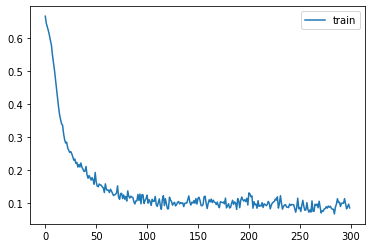

In [46]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

           S    0.98710   0.93673   0.96126       490
           B    0.94206   0.98824   0.96459       510

    accuracy                        0.96300      1000
   macro avg    0.96458   0.96248   0.96292      1000
weighted avg    0.96413   0.96300   0.96296      1000

Confusion matrix, without normalization
[[459  31]
 [  6 504]]


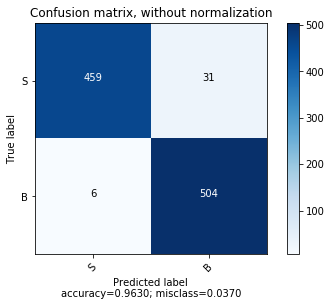

[0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 

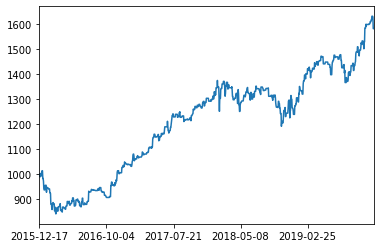

In [47]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 301us/step - loss: 0.6159 - accuracy: 0.6769
Epoch 2/300
3999/3999 [==============================] - 0s 86us/step - loss: 0.5762 - accuracy: 0.7057
Epoch 3/300
3999/3999 [==============================] - 0s 93us/step - loss: 0.5599 - accuracy: 0.7274
Epoch 4/300
3999/3999 [==============================] - 0s 96us/step - loss: 0.5387 - accuracy: 0.7417
Epoch 5/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.5182 - accuracy: 0.7502
Epoch 6/300
3999/3999 [==============================] - 0s 94us/step - loss: 0.5050 - accuracy: 0.7672
Epoch 7/300
3999/3999 [==============================] - 0s 86us/step - loss: 0.4940 - accuracy: 0.7719
Epoch 8/300
3999/3999 [==============================] - 0s 89us/step - loss: 0.4847 - accuracy: 0.7724
Epoch 9/300
3999/3999 [==============================] - 0s 89us/step - loss: 0.4773 - accuracy: 0.7887
Epoch 10/300
3999/3999 [==============================] - 0s 1

3999/3999 [==============================] - 1s 132us/step - loss: 0.2548 - accuracy: 0.89170s - loss: 0.2618 - ac
Epoch 79/300
3999/3999 [==============================] - 1s 129us/step - loss: 0.2598 - accuracy: 0.8932
Epoch 80/300
3999/3999 [==============================] - 1s 128us/step - loss: 0.2599 - accuracy: 0.8920
Epoch 81/300
3999/3999 [==============================] - 1s 132us/step - loss: 0.2490 - accuracy: 0.8982
Epoch 82/300
3999/3999 [==============================] - 1s 131us/step - loss: 0.2427 - accuracy: 0.9017
Epoch 83/300
3999/3999 [==============================] - 1s 147us/step - loss: 0.2486 - accuracy: 0.8992
Epoch 84/300
3999/3999 [==============================] - 1s 131us/step - loss: 0.2364 - accuracy: 0.9032
Epoch 85/300
3999/3999 [==============================] - 1s 171us/step - loss: 0.2429 - accuracy: 0.8957
Epoch 86/300
3999/3999 [==============================] - 1s 132us/step - loss: 0.2423 - accuracy: 0.9035
Epoch 87/300
3999/3999 [=============

3999/3999 [==============================] - 0s 124us/step - loss: 0.1512 - accuracy: 0.9407
Epoch 155/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.1619 - accuracy: 0.9372
Epoch 156/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.1713 - accuracy: 0.9280
Epoch 157/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.1651 - accuracy: 0.9305
Epoch 158/300
3999/3999 [==============================] - 0s 116us/step - loss: 0.1539 - accuracy: 0.93750s - loss: 0.1498 - accu
Epoch 159/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.1423 - accuracy: 0.9385
Epoch 160/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.1461 - accuracy: 0.9405
Epoch 161/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.1559 - accuracy: 0.9340
Epoch 162/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.1601 - accuracy: 0.9282
Epoch 163/300
3999/3999 [==

Epoch 230/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.1321 - accuracy: 0.9465
Epoch 231/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.1187 - accuracy: 0.9515
Epoch 232/300
3999/3999 [==============================] - 0s 103us/step - loss: 0.1183 - accuracy: 0.9525
Epoch 233/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.1164 - accuracy: 0.9500
Epoch 234/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.1398 - accuracy: 0.9397
Epoch 235/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.1430 - accuracy: 0.9417
Epoch 236/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.1207 - accuracy: 0.9510
Epoch 237/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.1491 - accuracy: 0.9360
Epoch 238/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.1293 - accuracy: 0.9467
Epoch 239/300
3999/3999 [============

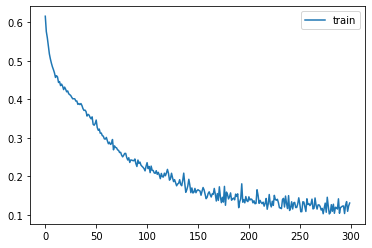

In [48]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

           S    0.95816   0.93469   0.94628       490
           B    0.93870   0.96078   0.94961       510

    accuracy                        0.94800      1000
   macro avg    0.94843   0.94774   0.94795      1000
weighted avg    0.94823   0.94800   0.94798      1000

Confusion matrix, without normalization
[[458  32]
 [ 20 490]]


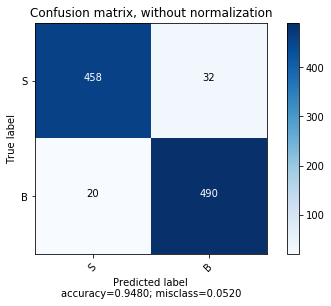

[0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 

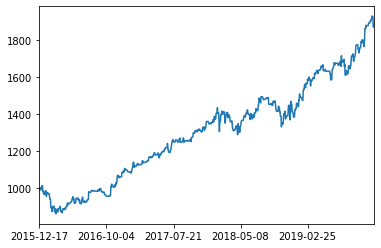

In [49]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 330us/step - loss: 2.6480 - accuracy: 0.5296
Epoch 2/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.7576 - accuracy: 0.5484
Epoch 3/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6994 - accuracy: 0.5811
Epoch 4/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.6882 - accuracy: 0.5874
Epoch 5/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.6746 - accuracy: 0.6022
Epoch 6/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.6593 - accuracy: 0.6207
Epoch 7/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.6561 - accuracy: 0.6064
Epoch 8/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6418 - accuracy: 0.6247
Epoch 9/300
3999/3999 [==============================] - 0s 103us/step - loss: 0.6369 - accuracy: 0.6424
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 0s 109us/step - loss: 0.4940 - accuracy: 0.7574
Epoch 79/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.4963 - accuracy: 0.7609
Epoch 80/300
3999/3999 [==============================] - 0s 122us/step - loss: 0.4844 - accuracy: 0.7557
Epoch 81/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.4943 - accuracy: 0.7607
Epoch 82/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.4981 - accuracy: 0.7547
Epoch 83/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.4962 - accuracy: 0.7574
Epoch 84/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.4880 - accuracy: 0.7612
Epoch 85/300
3999/3999 [==============================] - 1s 134us/step - loss: 0.4854 - accuracy: 0.7577
Epoch 86/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.4851 - accuracy: 0.7652
Epoch 87/300
3999/3999 [==============================] - 1s

3999/3999 [==============================] - 0s 103us/step - loss: 0.4605 - accuracy: 0.7792
Epoch 155/300
3999/3999 [==============================] - 1s 128us/step - loss: 0.4557 - accuracy: 0.7899
Epoch 156/300
3999/3999 [==============================] - 1s 165us/step - loss: 0.4515 - accuracy: 0.7909
Epoch 157/300
3999/3999 [==============================] - 0s 122us/step - loss: 0.4480 - accuracy: 0.7939
Epoch 158/300
3999/3999 [==============================] - 1s 168us/step - loss: 0.4588 - accuracy: 0.7824
Epoch 159/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.4504 - accuracy: 0.7852
Epoch 160/300
3999/3999 [==============================] - 1s 126us/step - loss: 0.4413 - accuracy: 0.7819
Epoch 161/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.4555 - accuracy: 0.7772
Epoch 162/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.4455 - accuracy: 0.7967
Epoch 163/300
3999/3999 [==========================

3999/3999 [==============================] - 0s 113us/step - loss: 0.4201 - accuracy: 0.8055
Epoch 231/300
3999/3999 [==============================] - 1s 137us/step - loss: 0.4102 - accuracy: 0.8207
Epoch 232/300
3999/3999 [==============================] - 0s 119us/step - loss: 0.4227 - accuracy: 0.8072
Epoch 233/300
3999/3999 [==============================] - 1s 143us/step - loss: 0.4076 - accuracy: 0.8195
Epoch 234/300
3999/3999 [==============================] - 1s 130us/step - loss: 0.4122 - accuracy: 0.8077
Epoch 235/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.4152 - accuracy: 0.8165
Epoch 236/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.4083 - accuracy: 0.8122
Epoch 237/300
3999/3999 [==============================] - 0s 122us/step - loss: 0.4162 - accuracy: 0.8097
Epoch 238/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.4188 - accuracy: 0.8095
Epoch 239/300
3999/3999 [==========================

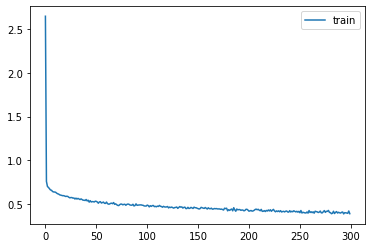

In [50]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 11
              precision    recall  f1-score   support

           S    0.82812   0.86531   0.84631       490
           B    0.86475   0.82745   0.84569       510

    accuracy                        0.84600      1000
   macro avg    0.84644   0.84638   0.84600      1000
weighted avg    0.84681   0.84600   0.84599      1000

Confusion matrix, without normalization
[[424  66]
 [ 88 422]]


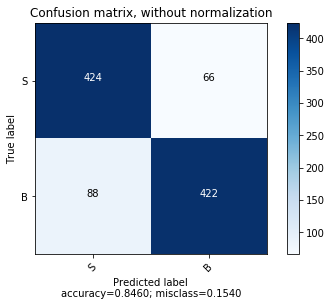

First date:	   2015-12-18	| Initial stock value: US$ 51.97512832434259
Last date:	   2019-12-06	| Final stock value: US$ 150.99
Stock value growth:	190.5%
[DEBUG] Initial money:    US$ 1000.0 | Final money: US$ 208529.18
[DEBUG] Final profit:	   US$ 207529.18 over 3.97 years
Money growth:      	20752.92%
Growth per year:   	284.09%
[0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,

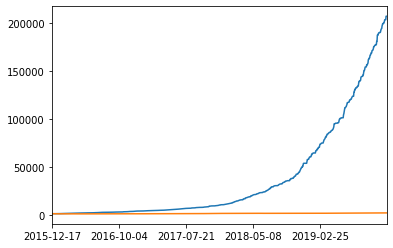

In [51]:
predict(m, c, s, i)
calculateOptimalProfit(preds[m][c][s][i])
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 320us/step - loss: 0.6219 - accuracy: 0.6537
Epoch 2/300
3996/3996 [==============================] - 0s 112us/step - loss: 0.5533 - accuracy: 0.7262
Epoch 3/300
3996/3996 [==============================] - 0s 100us/step - loss: 0.5420 - accuracy: 0.7405
Epoch 4/300
3996/3996 [==============================] - 1s 126us/step - loss: 0.5353 - accuracy: 0.7460
Epoch 5/300
3996/3996 [==============================] - 0s 107us/step - loss: 0.5244 - accuracy: 0.7497
Epoch 6/300
3996/3996 [==============================] - 0s 107us/step - loss: 0.5244 - accuracy: 0.7520
Epoch 7/300
3996/3996 [==============================] - 0s 108us/step - loss: 0.5199 - accuracy: 0.7545
Epoch 8/300
3996/3996 [==============================] - 0s 107us/step - loss: 0.5110 - accuracy: 0.7593
Epoch 9/300
3996/3996 [==============================] - 1s 128us/step - loss: 0.5136 - accuracy: 0.7550
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 0s 122us/step - loss: 0.4677 - accuracy: 0.7825
Epoch 78/300
3996/3996 [==============================] - 1s 128us/step - loss: 0.4633 - accuracy: 0.7813
Epoch 79/300
3996/3996 [==============================] - 0s 121us/step - loss: 0.4705 - accuracy: 0.7798
Epoch 80/300
3996/3996 [==============================] - 1s 187us/step - loss: 0.4649 - accuracy: 0.7800
Epoch 81/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.4638 - accuracy: 0.7870
Epoch 82/300
3996/3996 [==============================] - 1s 156us/step - loss: 0.4647 - accuracy: 0.7860
Epoch 83/300
3996/3996 [==============================] - 1s 213us/step - loss: 0.4587 - accuracy: 0.7858
Epoch 84/300
3996/3996 [==============================] - 1s 144us/step - loss: 0.4638 - accuracy: 0.7810
Epoch 85/300
3996/3996 [==============================] - 1s 176us/step - loss: 0.4682 - accuracy: 0.7818
Epoch 86/300
3996/3996 [==============================] - 1

3996/3996 [==============================] - 0s 119us/step - loss: 0.4472 - accuracy: 0.7898
Epoch 153/300
3996/3996 [==============================] - 0s 115us/step - loss: 0.4356 - accuracy: 0.7948
Epoch 154/300
3996/3996 [==============================] - 1s 128us/step - loss: 0.4377 - accuracy: 0.8011
Epoch 155/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.4456 - accuracy: 0.7950
Epoch 156/300
3996/3996 [==============================] - 0s 115us/step - loss: 0.4405 - accuracy: 0.7928
Epoch 157/300
3996/3996 [==============================] - 0s 116us/step - loss: 0.4475 - accuracy: 0.7878
Epoch 158/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.4422 - accuracy: 0.7910
Epoch 159/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.4465 - accuracy: 0.7938
Epoch 160/300
3996/3996 [==============================] - 0s 121us/step - loss: 0.4406 - accuracy: 0.7885
Epoch 161/300
3996/3996 [==========================

Epoch 227/300
3996/3996 [==============================] - 0s 115us/step - loss: 0.4375 - accuracy: 0.79350s - loss: 0.4386 - accuracy: 0.
Epoch 228/300
3996/3996 [==============================] - 1s 136us/step - loss: 0.4369 - accuracy: 0.7898
Epoch 229/300
3996/3996 [==============================] - 0s 120us/step - loss: 0.4371 - accuracy: 0.7910
Epoch 230/300
3996/3996 [==============================] - 1s 136us/step - loss: 0.4368 - accuracy: 0.7998
Epoch 231/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.4391 - accuracy: 0.7985
Epoch 232/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.4425 - accuracy: 0.7933
Epoch 233/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.4351 - accuracy: 0.7965
Epoch 234/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.4331 - accuracy: 0.7945
Epoch 235/300
3996/3996 [==============================] - 0s 104us/step - loss: 0.4413 - accuracy: 0.7915
Epoch

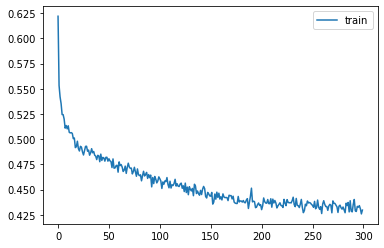

In [52]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

           S    0.83333   0.79960   0.81612       494
           B    0.81179   0.84387   0.82752       506

    accuracy                        0.82200      1000
   macro avg    0.82256   0.82173   0.82182      1000
weighted avg    0.82243   0.82200   0.82189      1000

Confusion matrix, without normalization
[[395  99]
 [ 79 427]]


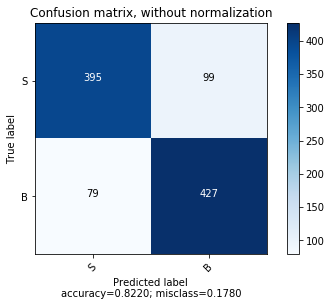

[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 

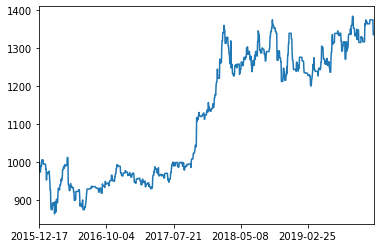

In [53]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 304us/step - loss: 0.6010 - accuracy: 0.6767
Epoch 2/300
3996/3996 [==============================] - 0s 119us/step - loss: 0.5320 - accuracy: 0.7412
Epoch 3/300
3996/3996 [==============================] - 0s 99us/step - loss: 0.5109 - accuracy: 0.7580
Epoch 4/300
3996/3996 [==============================] - 0s 96us/step - loss: 0.4956 - accuracy: 0.7630
Epoch 5/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.4925 - accuracy: 0.7683
Epoch 6/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.4818 - accuracy: 0.7813
Epoch 7/300
3996/3996 [==============================] - 0s 111us/step - loss: 0.4814 - accuracy: 0.7738
Epoch 8/300
3996/3996 [==============================] - 0s 106us/step - loss: 0.4697 - accuracy: 0.7818
Epoch 9/300
3996/3996 [==============================] - 0s 112us/step - loss: 0.4688 - accuracy: 0.7828
Epoch 10/300
3996/3996 [==============================] - 

3996/3996 [==============================] - 1s 141us/step - loss: 0.2236 - accuracy: 0.9037
Epoch 79/300
3996/3996 [==============================] - 0s 121us/step - loss: 0.2143 - accuracy: 0.9077
Epoch 80/300
3996/3996 [==============================] - 0s 115us/step - loss: 0.2156 - accuracy: 0.9062
Epoch 81/300
3996/3996 [==============================] - 0s 107us/step - loss: 0.1890 - accuracy: 0.9177
Epoch 82/300
3996/3996 [==============================] - 1s 127us/step - loss: 0.2067 - accuracy: 0.9127
Epoch 83/300
3996/3996 [==============================] - 0s 106us/step - loss: 0.2204 - accuracy: 0.9057
Epoch 84/300
3996/3996 [==============================] - 1s 147us/step - loss: 0.1983 - accuracy: 0.9159
Epoch 85/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.2159 - accuracy: 0.9074
Epoch 86/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.2095 - accuracy: 0.9092
Epoch 87/300
3996/3996 [==============================] - 0

3996/3996 [==============================] - 1s 164us/step - loss: 0.1699 - accuracy: 0.9287
Epoch 154/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.1463 - accuracy: 0.9367
Epoch 155/300
3996/3996 [==============================] - 1s 127us/step - loss: 0.1684 - accuracy: 0.9292
Epoch 156/300
3996/3996 [==============================] - 0s 112us/step - loss: 0.1988 - accuracy: 0.9192
Epoch 157/300
3996/3996 [==============================] - 0s 108us/step - loss: 0.1681 - accuracy: 0.9292
Epoch 158/300
3996/3996 [==============================] - 0s 111us/step - loss: 0.1468 - accuracy: 0.9334
Epoch 159/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.1706 - accuracy: 0.9277
Epoch 160/300
3996/3996 [==============================] - 1s 140us/step - loss: 0.1604 - accuracy: 0.9354
Epoch 161/300
3996/3996 [==============================] - 0s 112us/step - loss: 0.1625 - accuracy: 0.9329
Epoch 162/300
3996/3996 [==========================

3996/3996 [==============================] - 1s 321us/step - loss: 0.1521 - accuracy: 0.9357
Epoch 230/300
3996/3996 [==============================] - 1s 356us/step - loss: 0.1574 - accuracy: 0.9332
Epoch 231/300
3996/3996 [==============================] - 1s 336us/step - loss: 0.1995 - accuracy: 0.9162
Epoch 232/300
3996/3996 [==============================] - 1s 316us/step - loss: 0.1885 - accuracy: 0.9184
Epoch 233/300
3996/3996 [==============================] - 1s 290us/step - loss: 0.1808 - accuracy: 0.9252
Epoch 234/300
3996/3996 [==============================] - 1s 369us/step - loss: 0.1864 - accuracy: 0.9189
Epoch 235/300
3996/3996 [==============================] - 1s 329us/step - loss: 0.2018 - accuracy: 0.9152
Epoch 236/300
3996/3996 [==============================] - 1s 345us/step - loss: 0.1662 - accuracy: 0.9269
Epoch 237/300
3996/3996 [==============================] - 1s 292us/step - loss: 0.1539 - accuracy: 0.9387
Epoch 238/300
3996/3996 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128382). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 412us/step - loss: 0.1505 - accuracy: 0.9377
Epoch 273/300
3996/3996 [==============================] - 1s 352us/step - loss: 0.1568 - accuracy: 0.9344
Epoch 274/300
3996/3996 [==============================] - 1s 305us/step - loss: 0.1422 - accuracy: 0.9364
Epoch 275/300
3996/3996 [==============================] - 1s 246us/step - loss: 0.1444 - accuracy: 0.93570s - loss: 0.1245 - 
Epoch 276/300
3996/3996 [==============================] - 1s 261us/step - loss: 0.1433 - accuracy: 0.9434
Epoch 277/300
3996/3996 [==============================] - 1s 249us/step - loss: 0.1686 - accuracy: 0.9264
Epoch 278/300
3996/3996 [==============================] - 1s 250us/step - loss: 0.1628 - accuracy: 0.9319
Epoch 279/300
3996/3996 [==============================] - 1s 217us/step - loss: 0.1335 - accuracy: 0.9439
Epoch 280/300
3996/3996 [==============================] - 1s 292us/step - loss: 0.1415 - accuracy: 0.9422
Epoch 281/300
3996/3996 [======

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.149757). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 307us/step - loss: 0.1554 - accuracy: 0.9294
Epoch 293/300
3996/3996 [==============================] - 1s 311us/step - loss: 0.1529 - accuracy: 0.93420s - loss: 0.1508 - accuracy: 
Epoch 294/300
3996/3996 [==============================] - 1s 298us/step - loss: 0.1590 - accuracy: 0.9337
Epoch 295/300
3996/3996 [==============================] - 1s 317us/step - loss: 0.1465 - accuracy: 0.9394
Epoch 296/300
3996/3996 [==============================] - 1s 314us/step - loss: 0.1360 - accuracy: 0.9424
Epoch 297/300
3996/3996 [==============================] - 1s 271us/step - loss: 0.1399 - accuracy: 0.9412
Epoch 298/300
3996/3996 [==============================] - 1s 255us/step - loss: 0.1305 - accuracy: 0.94492s - loss:
Epoch 299/300
3996/3996 [==============================] - 1s 261us/step - loss: 0.1534 - accuracy: 0.9349
Epoch 300/300
3996/3996 [==============================] - 1s 284us/step - loss: 0.1464 - accuracy: 0.9324


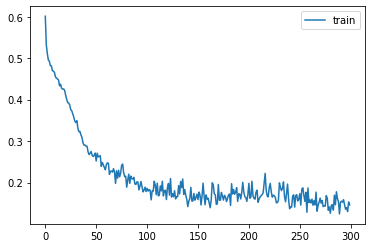

In [54]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

           S    0.95968   0.96356   0.96162       494
           B    0.96429   0.96047   0.96238       506

    accuracy                        0.96200      1000
   macro avg    0.96198   0.96202   0.96200      1000
weighted avg    0.96201   0.96200   0.96200      1000

Confusion matrix, without normalization
[[476  18]
 [ 20 486]]


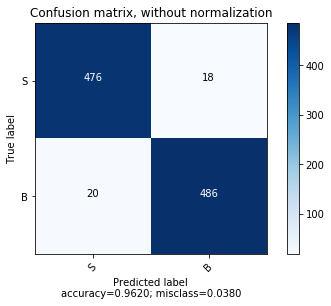

[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 

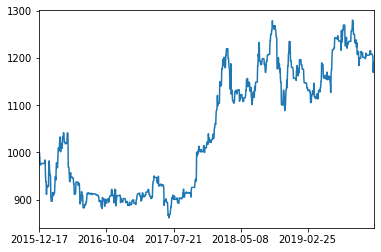

In [55]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 555us/step - loss: 0.5852 - accuracy: 0.7005
Epoch 2/300
3996/3996 [==============================] - 1s 349us/step - loss: 0.5340 - accuracy: 0.7362
Epoch 3/300
3996/3996 [==============================] - 1s 279us/step - loss: 0.5106 - accuracy: 0.7600
Epoch 4/300
3996/3996 [==============================] - 2s 406us/step - loss: 0.5043 - accuracy: 0.76380s - loss: 0.5106 - accuracy: 
Epoch 5/300
3996/3996 [==============================] - 1s 254us/step - loss: 0.4905 - accuracy: 0.7640
Epoch 6/300
3996/3996 [==============================] - 1s 273us/step - loss: 0.4809 - accuracy: 0.77350s - loss: 0.4793 - accu
Epoch 7/300
3996/3996 [==============================] - 1s 265us/step - loss: 0.4678 - accuracy: 0.7868
Epoch 8/300
3996/3996 [==============================] - 1s 249us/step - loss: 0.4631 - accuracy: 0.7905
Epoch 9/300
3996/3996 [==============================] - 1s 250us/step - loss: 0.4523 - accuracy: 0.79130s

3996/3996 [==============================] - 1s 195us/step - loss: 0.3121 - accuracy: 0.8606
Epoch 77/300
3996/3996 [==============================] - 1s 151us/step - loss: 0.3059 - accuracy: 0.8609
Epoch 78/300
3996/3996 [==============================] - 1s 274us/step - loss: 0.3088 - accuracy: 0.8661
Epoch 79/300
3996/3996 [==============================] - 1s 256us/step - loss: 0.2999 - accuracy: 0.8626
Epoch 80/300
3996/3996 [==============================] - 1s 204us/step - loss: 0.3010 - accuracy: 0.8679
Epoch 81/300
3996/3996 [==============================] - 1s 177us/step - loss: 0.3080 - accuracy: 0.8661
Epoch 82/300
3996/3996 [==============================] - 1s 186us/step - loss: 0.3058 - accuracy: 0.8629
Epoch 83/300
3996/3996 [==============================] - 1s 155us/step - loss: 0.3087 - accuracy: 0.8589
Epoch 84/300
3996/3996 [==============================] - 1s 311us/step - loss: 0.3084 - accuracy: 0.8636
Epoch 85/300
3996/3996 [==============================] - 1

3996/3996 [==============================] - 1s 171us/step - loss: 0.2320 - accuracy: 0.8966
Epoch 151/300
3996/3996 [==============================] - 1s 128us/step - loss: 0.2142 - accuracy: 0.9092
Epoch 152/300
3996/3996 [==============================] - 0s 121us/step - loss: 0.2158 - accuracy: 0.9089
Epoch 153/300
3996/3996 [==============================] - 0s 125us/step - loss: 0.2345 - accuracy: 0.9069
Epoch 154/300
3996/3996 [==============================] - 1s 125us/step - loss: 0.2299 - accuracy: 0.8986
Epoch 155/300
3996/3996 [==============================] - 0s 118us/step - loss: 0.2168 - accuracy: 0.9057
Epoch 156/300
3996/3996 [==============================] - 0s 124us/step - loss: 0.2196 - accuracy: 0.9024
Epoch 157/300
3996/3996 [==============================] - 1s 132us/step - loss: 0.2297 - accuracy: 0.8999
Epoch 158/300
3996/3996 [==============================] - 1s 302us/step - loss: 0.2273 - accuracy: 0.9052
Epoch 159/300
3996/3996 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138895). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 233us/step - loss: 0.2197 - accuracy: 0.9077
Epoch 187/300
3996/3996 [==============================] - 1s 193us/step - loss: 0.2136 - accuracy: 0.9037
Epoch 188/300
3996/3996 [==============================] - 1s 240us/step - loss: 0.1924 - accuracy: 0.9197
Epoch 189/300
3996/3996 [==============================] - 1s 197us/step - loss: 0.1968 - accuracy: 0.9114
Epoch 190/300
3996/3996 [==============================] - 1s 159us/step - loss: 0.1934 - accuracy: 0.9209
Epoch 191/300
3996/3996 [==============================] - 1s 145us/step - loss: 0.2043 - accuracy: 0.9142
Epoch 192/300
3996/3996 [==============================] - 1s 127us/step - loss: 0.2142 - accuracy: 0.9119
Epoch 193/300
3996/3996 [==============================] - 1s 163us/step - loss: 0.2036 - accuracy: 0.9099
Epoch 194/300
3996/3996 [==============================] - 0s 122us/step - loss: 0.1955 - accuracy: 0.9147
Epoch 195/300
3996/3996 [==========================

3996/3996 [==============================] - 1s 240us/step - loss: 0.1860 - accuracy: 0.9202
Epoch 261/300
3996/3996 [==============================] - 1s 319us/step - loss: 0.1673 - accuracy: 0.9309
Epoch 262/300
3996/3996 [==============================] - 1s 231us/step - loss: 0.1457 - accuracy: 0.9372
Epoch 263/300
3996/3996 [==============================] - 1s 253us/step - loss: 0.1680 - accuracy: 0.9254
Epoch 264/300
3996/3996 [==============================] - 1s 235us/step - loss: 0.1701 - accuracy: 0.9299
Epoch 265/300
3996/3996 [==============================] - 1s 199us/step - loss: 0.1625 - accuracy: 0.9279
Epoch 266/300
3996/3996 [==============================] - 1s 217us/step - loss: 0.1583 - accuracy: 0.9284
Epoch 267/300
3996/3996 [==============================] - 1s 175us/step - loss: 0.1728 - accuracy: 0.9269
Epoch 268/300
3996/3996 [==============================] - 1s 134us/step - loss: 0.1641 - accuracy: 0.9269
Epoch 269/300
3996/3996 [==========================

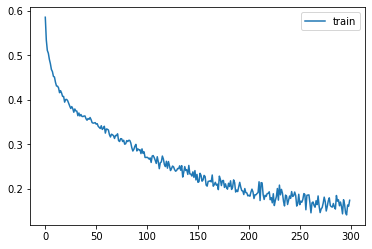

In [56]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

           S    0.96256   0.88462   0.92194       494
           B    0.89560   0.96640   0.92966       506

    accuracy                        0.92600      1000
   macro avg    0.92908   0.92551   0.92580      1000
weighted avg    0.92868   0.92600   0.92585      1000

Confusion matrix, without normalization
[[437  57]
 [ 17 489]]


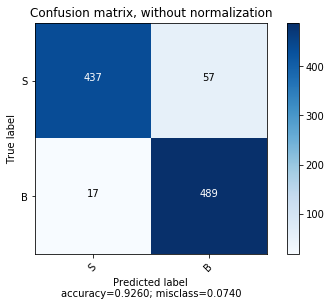

[0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 

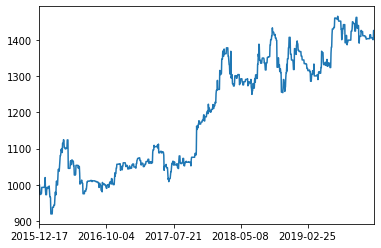

In [57]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 3s 837us/step - loss: 1.6480 - accuracy: 0.5060
Epoch 2/300
3996/3996 [==============================] - 1s 223us/step - loss: 0.7059 - accuracy: 0.53750s - loss: 0.7087 
Epoch 3/300
3996/3996 [==============================] - 1s 357us/step - loss: 0.7004 - accuracy: 0.5493
Epoch 4/300
3996/3996 [==============================] - 1s 227us/step - loss: 0.6813 - accuracy: 0.5773
Epoch 5/300
3996/3996 [==============================] - 1s 256us/step - loss: 0.6741 - accuracy: 0.5731
Epoch 6/300
3996/3996 [==============================] - 1s 278us/step - loss: 0.6633 - accuracy: 0.6066
Epoch 7/300
3996/3996 [==============================] - 1s 253us/step - loss: 0.6541 - accuracy: 0.6114
Epoch 8/300
3996/3996 [==============================] - 1s 233us/step - loss: 0.6427 - accuracy: 0.6221
Epoch 9/300
3996/3996 [==============================] - 1s 204us/step - loss: 0.6349 - accuracy: 0.64340s - loss: 0
Epoch 10/300
3996/3996 [=

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.123978). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 232us/step - loss: 0.4763 - accuracy: 0.7628
Epoch 64/300
3996/3996 [==============================] - 1s 125us/step - loss: 0.4594 - accuracy: 0.7833
Epoch 65/300
3996/3996 [==============================] - 1s 129us/step - loss: 0.4546 - accuracy: 0.7853
Epoch 66/300
3996/3996 [==============================] - 1s 174us/step - loss: 0.4462 - accuracy: 0.7888
Epoch 67/300
3996/3996 [==============================] - 1s 132us/step - loss: 0.4596 - accuracy: 0.7845
Epoch 68/300
3996/3996 [==============================] - 1s 154us/step - loss: 0.4616 - accuracy: 0.7823
Epoch 69/300
3996/3996 [==============================] - 1s 154us/step - loss: 0.4613 - accuracy: 0.7838
Epoch 70/300
3996/3996 [==============================] - 0s 125us/step - loss: 0.4569 - accuracy: 0.7843
Epoch 71/300
3996/3996 [==============================] - 1s 133us/step - loss: 0.4583 - accuracy: 0.7873
Epoch 72/300
3996/3996 [==============================] - 1

Epoch 138/300
3996/3996 [==============================] - 1s 201us/step - loss: 0.4037 - accuracy: 0.8171
Epoch 139/300
3996/3996 [==============================] - 1s 230us/step - loss: 0.3952 - accuracy: 0.82680s - loss: 0.3945 - accuracy: 0.82
Epoch 140/300
3996/3996 [==============================] - 1s 197us/step - loss: 0.3884 - accuracy: 0.8308
Epoch 141/300
3996/3996 [==============================] - 1s 202us/step - loss: 0.3945 - accuracy: 0.82080s - loss: 0.3945 - accuracy: 0.
Epoch 142/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.3891 - accuracy: 0.8228
Epoch 143/300
3996/3996 [==============================] - 1s 217us/step - loss: 0.4168 - accuracy: 0.8181
Epoch 144/300
3996/3996 [==============================] - 1s 191us/step - loss: 0.4005 - accuracy: 0.8171
Epoch 145/300
3996/3996 [==============================] - 1s 180us/step - loss: 0.4132 - accuracy: 0.8098
Epoch 146/300
3996/3996 [==============================] - 1s 188us/step - los

3996/3996 [==============================] - 1s 189us/step - loss: 0.3616 - accuracy: 0.8406
Epoch 212/300
3996/3996 [==============================] - 1s 163us/step - loss: 0.3578 - accuracy: 0.8381
Epoch 213/300
3996/3996 [==============================] - 1s 157us/step - loss: 0.3706 - accuracy: 0.8401
Epoch 214/300
3996/3996 [==============================] - 1s 201us/step - loss: 0.3843 - accuracy: 0.83260s - loss: 0
Epoch 215/300
3996/3996 [==============================] - 1s 175us/step - loss: 0.3640 - accuracy: 0.8376
Epoch 216/300
3996/3996 [==============================] - 1s 156us/step - loss: 0.3533 - accuracy: 0.84530s - loss: 0.3455 - accura
Epoch 217/300
3996/3996 [==============================] - 1s 171us/step - loss: 0.3627 - accuracy: 0.8401
Epoch 218/300
3996/3996 [==============================] - 1s 191us/step - loss: 0.3618 - accuracy: 0.8326
Epoch 219/300
3996/3996 [==============================] - 1s 184us/step - loss: 0.3534 - accuracy: 0.84160s - loss: 0.3

3996/3996 [==============================] - 1s 182us/step - loss: 0.3585 - accuracy: 0.8378
Epoch 285/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.3556 - accuracy: 0.8431
Epoch 286/300
3996/3996 [==============================] - 1s 192us/step - loss: 0.3443 - accuracy: 0.8493
Epoch 287/300
3996/3996 [==============================] - 1s 190us/step - loss: 0.3518 - accuracy: 0.8421
Epoch 288/300
3996/3996 [==============================] - 1s 185us/step - loss: 0.3490 - accuracy: 0.8511
Epoch 289/300
3996/3996 [==============================] - 1s 205us/step - loss: 0.3425 - accuracy: 0.8456
Epoch 290/300
3996/3996 [==============================] - 1s 169us/step - loss: 0.3458 - accuracy: 0.8526
Epoch 291/300
3996/3996 [==============================] - 1s 270us/step - loss: 0.3330 - accuracy: 0.8521
Epoch 292/300
3996/3996 [==============================] - 1s 199us/step - loss: 0.3495 - accuracy: 0.8466
Epoch 293/300
3996/3996 [==========================

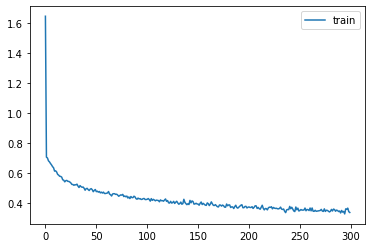

In [58]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 11
              precision    recall  f1-score   support

           S    0.77717   0.86842   0.82027       494
           B    0.85491   0.75692   0.80294       506

    accuracy                        0.81200      1000
   macro avg    0.81604   0.81267   0.81160      1000
weighted avg    0.81651   0.81200   0.81150      1000

Confusion matrix, without normalization
[[429  65]
 [123 383]]


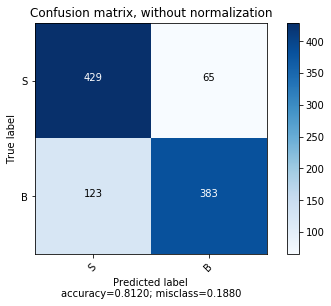

[0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 

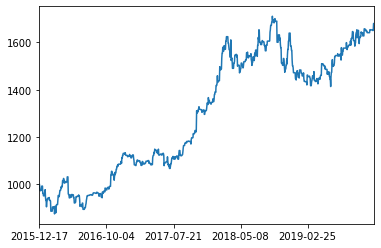

In [59]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 3s 807us/step - loss: 0.6216 - accuracy: 0.64803s - loss: 0.6623 - ac
Epoch 2/300
3992/3992 [==============================] - 1s 226us/step - loss: 0.5442 - accuracy: 0.7275
Epoch 3/300
3992/3992 [==============================] - 1s 179us/step - loss: 0.5278 - accuracy: 0.7375
Epoch 4/300
3992/3992 [==============================] - 1s 188us/step - loss: 0.5232 - accuracy: 0.7460
Epoch 5/300
3992/3992 [==============================] - 1s 190us/step - loss: 0.5157 - accuracy: 0.7535
Epoch 6/300
3992/3992 [==============================] - 1s 166us/step - loss: 0.5122 - accuracy: 0.75680s - loss: 0.5050 - accuracy
Epoch 7/300
3992/3992 [==============================] - 1s 187us/step - loss: 0.5032 - accuracy: 0.7635
Epoch 8/300
3992/3992 [==============================] - 1s 158us/step - loss: 0.5008 - accuracy: 0.7620
Epoch 9/300
3992/3992 [==============================] - 1s 163us/step - loss: 0.5026 - accuracy: 0.7595
Epoch

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120796). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 2s 555us/step - loss: 0.4857 - accuracy: 0.7733
Epoch 21/300
3992/3992 [==============================] - 1s 368us/step - loss: 0.4832 - accuracy: 0.7680
Epoch 22/300
3992/3992 [==============================] - 1s 239us/step - loss: 0.4809 - accuracy: 0.77860s - loss: 0.4793 - accu - ETA: 0s - loss: 0.4812 - accuracy: 0.
Epoch 23/300
3992/3992 [==============================] - ETA: 0s - loss: 0.4802 - accuracy: 0.77 - 1s 213us/step - loss: 0.4829 - accuracy: 0.7761
Epoch 24/300
3992/3992 [==============================] - 1s 280us/step - loss: 0.4737 - accuracy: 0.7761
Epoch 25/300
3992/3992 [==============================] - 1s 301us/step - loss: 0.4818 - accuracy: 0.7715
Epoch 26/300
3992/3992 [==============================] - 1s 285us/step - loss: 0.4792 - accuracy: 0.7730
Epoch 27/300
3992/3992 [==============================] - 1s 282us/step - loss: 0.4788 - accuracy: 0.7713
Epoch 28/300
3992/3992 [==============================] - 1

Epoch 94/300
3992/3992 [==============================] - 1s 152us/step - loss: 0.4352 - accuracy: 0.8001
Epoch 95/300
3992/3992 [==============================] - 0s 113us/step - loss: 0.4388 - accuracy: 0.7991
Epoch 96/300
3992/3992 [==============================] - 1s 127us/step - loss: 0.4342 - accuracy: 0.7971
Epoch 97/300
3992/3992 [==============================] - 1s 159us/step - loss: 0.4361 - accuracy: 0.79760s - loss: 0.4459 - accu
Epoch 98/300
3992/3992 [==============================] - 1s 201us/step - loss: 0.4329 - accuracy: 0.7936
Epoch 99/300
3992/3992 [==============================] - 1s 156us/step - loss: 0.4297 - accuracy: 0.7988
Epoch 100/300
3992/3992 [==============================] - 1s 140us/step - loss: 0.4317 - accuracy: 0.7988
Epoch 101/300
3992/3992 [==============================] - 1s 134us/step - loss: 0.4372 - accuracy: 0.8009
Epoch 102/300
3992/3992 [==============================] - 1s 373us/step - loss: 0.4331 - accuracy: 0.80092s - los
Epoch 103/3

3992/3992 [==============================] - 0s 123us/step - loss: 0.4142 - accuracy: 0.8101
Epoch 170/300
3992/3992 [==============================] - 1s 138us/step - loss: 0.4113 - accuracy: 0.8086
Epoch 171/300
3992/3992 [==============================] - 0s 122us/step - loss: 0.4110 - accuracy: 0.8096
Epoch 172/300
3992/3992 [==============================] - 1s 252us/step - loss: 0.4148 - accuracy: 0.8094
Epoch 173/300
3992/3992 [==============================] - 1s 160us/step - loss: 0.4077 - accuracy: 0.8064
Epoch 174/300
3992/3992 [==============================] - 1s 144us/step - loss: 0.4142 - accuracy: 0.8104
Epoch 175/300
3992/3992 [==============================] - 1s 210us/step - loss: 0.4085 - accuracy: 0.8074
Epoch 176/300
3992/3992 [==============================] - 1s 150us/step - loss: 0.4131 - accuracy: 0.8116
Epoch 177/300
3992/3992 [==============================] - 1s 151us/step - loss: 0.4134 - accuracy: 0.8099
Epoch 178/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 134us/step - loss: 0.3966 - accuracy: 0.8186
Epoch 246/300
3992/3992 [==============================] - 0s 115us/step - loss: 0.3992 - accuracy: 0.8169
Epoch 247/300
3992/3992 [==============================] - 0s 114us/step - loss: 0.3952 - accuracy: 0.8209
Epoch 248/300
3992/3992 [==============================] - 0s 113us/step - loss: 0.3943 - accuracy: 0.8136
Epoch 249/300
3992/3992 [==============================] - 0s 121us/step - loss: 0.3930 - accuracy: 0.8206
Epoch 250/300
3992/3992 [==============================] - 0s 115us/step - loss: 0.3964 - accuracy: 0.8111
Epoch 251/300
3992/3992 [==============================] - 1s 128us/step - loss: 0.3947 - accuracy: 0.8154
Epoch 252/300
3992/3992 [==============================] - 0s 109us/step - loss: 0.3933 - accuracy: 0.8196
Epoch 253/300
3992/3992 [==============================] - 0s 117us/step - loss: 0.3894 - accuracy: 0.8186
Epoch 254/300
3992/3992 [==========================

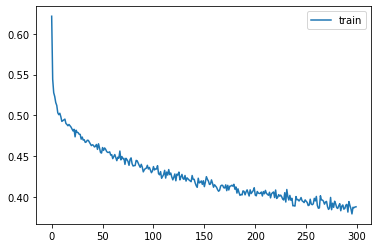

In [60]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

           S    0.83370   0.72169   0.77366       521
           B    0.73540   0.84310   0.78558       478

    accuracy                        0.77978       999
   macro avg    0.78455   0.78239   0.77962       999
weighted avg    0.78667   0.77978   0.77936       999

Confusion matrix, without normalization
[[376 145]
 [ 75 403]]


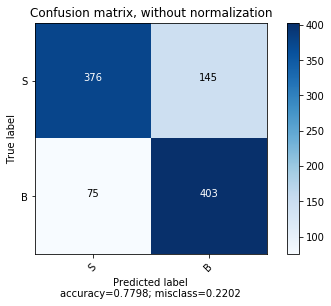

[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 

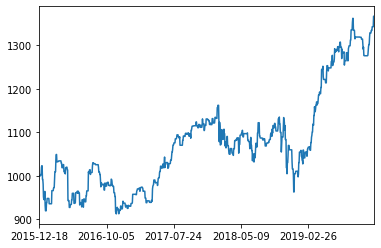

In [61]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 484us/step - loss: 0.6200 - accuracy: 0.6621
Epoch 2/300
3992/3992 [==============================] - 1s 139us/step - loss: 0.5515 - accuracy: 0.7322
Epoch 3/300
3992/3992 [==============================] - 1s 184us/step - loss: 0.5224 - accuracy: 0.7420
Epoch 4/300
3992/3992 [==============================] - 1s 206us/step - loss: 0.5106 - accuracy: 0.7505
Epoch 5/300
3992/3992 [==============================] - 1s 138us/step - loss: 0.4997 - accuracy: 0.7635
Epoch 6/300
3992/3992 [==============================] - 1s 153us/step - loss: 0.4947 - accuracy: 0.7645
Epoch 7/300
3992/3992 [==============================] - 1s 166us/step - loss: 0.4877 - accuracy: 0.7658
Epoch 8/300
3992/3992 [==============================] - 1s 180us/step - loss: 0.4846 - accuracy: 0.7745
Epoch 9/300
3992/3992 [==============================] - 1s 172us/step - loss: 0.4749 - accuracy: 0.7771
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 0s 125us/step - loss: 0.2708 - accuracy: 0.8830
Epoch 78/300
3992/3992 [==============================] - 1s 132us/step - loss: 0.2898 - accuracy: 0.8735
Epoch 79/300
3992/3992 [==============================] - 1s 140us/step - loss: 0.2552 - accuracy: 0.8893
Epoch 80/300
3992/3992 [==============================] - 1s 144us/step - loss: 0.2557 - accuracy: 0.8895
Epoch 81/300
3992/3992 [==============================] - 1s 147us/step - loss: 0.2553 - accuracy: 0.8910
Epoch 82/300
3992/3992 [==============================] - 1s 160us/step - loss: 0.2660 - accuracy: 0.8848
Epoch 83/300
3992/3992 [==============================] - 1s 199us/step - loss: 0.2683 - accuracy: 0.8810
Epoch 84/300
3992/3992 [==============================] - 1s 166us/step - loss: 0.2863 - accuracy: 0.8690
Epoch 85/300
3992/3992 [==============================] - 1s 176us/step - loss: 0.2745 - accuracy: 0.8840
Epoch 86/300
3992/3992 [==============================] - 1

3992/3992 [==============================] - 1s 175us/step - loss: 0.2464 - accuracy: 0.8955
Epoch 154/300
3992/3992 [==============================] - 1s 156us/step - loss: 0.2504 - accuracy: 0.8900
Epoch 155/300
3992/3992 [==============================] - 1s 168us/step - loss: 0.2776 - accuracy: 0.8795
Epoch 156/300
3992/3992 [==============================] - 1s 205us/step - loss: 0.2135 - accuracy: 0.9098
Epoch 157/300
3992/3992 [==============================] - 1s 127us/step - loss: 0.2342 - accuracy: 0.8973
Epoch 158/300
3992/3992 [==============================] - 1s 131us/step - loss: 0.2370 - accuracy: 0.8958
Epoch 159/300
3992/3992 [==============================] - 1s 163us/step - loss: 0.2408 - accuracy: 0.8975
Epoch 160/300
3992/3992 [==============================] - 1s 135us/step - loss: 0.2429 - accuracy: 0.8938
Epoch 161/300
3992/3992 [==============================] - 1s 136us/step - loss: 0.2329 - accuracy: 0.8973
Epoch 162/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 167us/step - loss: 0.1931 - accuracy: 0.9221
Epoch 229/300
3992/3992 [==============================] - 2s 594us/step - loss: 0.2059 - accuracy: 0.9108
Epoch 230/300
3992/3992 [==============================] - 2s 507us/step - loss: 0.1917 - accuracy: 0.92230s - l
Epoch 231/300
3992/3992 [==============================] - 2s 448us/step - loss: 0.2089 - accuracy: 0.91361s - los
Epoch 232/300
3992/3992 [==============================] - 1s 320us/step - loss: 0.1994 - accuracy: 0.9136
Epoch 233/300
3992/3992 [==============================] - 1s 260us/step - loss: 0.1823 - accuracy: 0.9206
Epoch 234/300
3992/3992 [==============================] - 1s 289us/step - loss: 0.2089 - accuracy: 0.9116
Epoch 235/300
3992/3992 [==============================] - 1s 194us/step - loss: 0.2396 - accuracy: 0.8975
Epoch 236/300
3992/3992 [==============================] - 1s 197us/step - loss: 0.1967 - accuracy: 0.9163
Epoch 237/300
3992/3992 [============

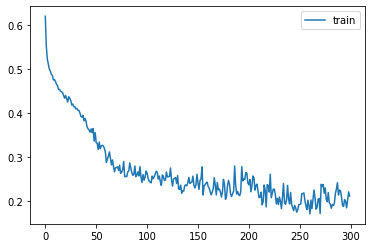

In [62]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

           S    0.87201   0.98081   0.92322       521
           B    0.97579   0.84310   0.90460       478

    accuracy                        0.91491       999
   macro avg    0.92390   0.91195   0.91391       999
weighted avg    0.92167   0.91491   0.91431       999

Confusion matrix, without normalization
[[511  10]
 [ 75 403]]


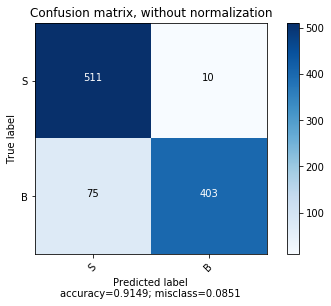

[1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 

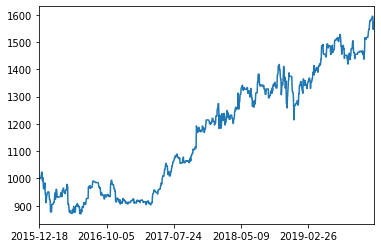

In [63]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 431us/step - loss: 0.6303 - accuracy: 0.6706
Epoch 2/300
3992/3992 [==============================] - 1s 135us/step - loss: 0.5315 - accuracy: 0.7387
Epoch 3/300
3992/3992 [==============================] - 1s 158us/step - loss: 0.5172 - accuracy: 0.7472
Epoch 4/300
3992/3992 [==============================] - 1s 146us/step - loss: 0.5086 - accuracy: 0.7583
Epoch 5/300
3992/3992 [==============================] - 1s 180us/step - loss: 0.4929 - accuracy: 0.7665
Epoch 6/300
3992/3992 [==============================] - 1s 171us/step - loss: 0.4873 - accuracy: 0.7680
Epoch 7/300
3992/3992 [==============================] - 1s 176us/step - loss: 0.4735 - accuracy: 0.7710
Epoch 8/300
3992/3992 [==============================] - 1s 189us/step - loss: 0.4683 - accuracy: 0.7768
Epoch 9/300
3992/3992 [==============================] - 1s 171us/step - loss: 0.4725 - accuracy: 0.7763
Epoch 10/300
3992/3992 [==============================]

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.132088). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 2s 409us/step - loss: 0.3152 - accuracy: 0.8577
Epoch 61/300
3992/3992 [==============================] - 1s 329us/step - loss: 0.3108 - accuracy: 0.8582
Epoch 62/300
3992/3992 [==============================] - 1s 208us/step - loss: 0.3204 - accuracy: 0.8525
Epoch 63/300
3992/3992 [==============================] - 1s 321us/step - loss: 0.3016 - accuracy: 0.8657
Epoch 64/300
3992/3992 [==============================] - 1s 337us/step - loss: 0.3074 - accuracy: 0.8647
Epoch 65/300
3992/3992 [==============================] - 1s 235us/step - loss: 0.3216 - accuracy: 0.8550
Epoch 66/300
3992/3992 [==============================] - 1s 189us/step - loss: 0.3021 - accuracy: 0.8627
Epoch 67/300
3992/3992 [==============================] - 1s 366us/step - loss: 0.3096 - accuracy: 0.8592
Epoch 68/300
3992/3992 [==============================] - 2s 459us/step - loss: 0.3119 - accuracy: 0.85870s - loss: 0.3120 - accuracy: 
Epoch 69/300
3992/3992 [=====

3992/3992 [==============================] - 1s 163us/step - loss: 0.2488 - accuracy: 0.8908
Epoch 136/300
3992/3992 [==============================] - 1s 173us/step - loss: 0.2411 - accuracy: 0.8955
Epoch 137/300
3992/3992 [==============================] - 1s 164us/step - loss: 0.2439 - accuracy: 0.8913
Epoch 138/300
3992/3992 [==============================] - 1s 188us/step - loss: 0.2422 - accuracy: 0.8965
Epoch 139/300
3992/3992 [==============================] - 1s 155us/step - loss: 0.2505 - accuracy: 0.8873
Epoch 140/300
3992/3992 [==============================] - 1s 193us/step - loss: 0.2353 - accuracy: 0.8993
Epoch 141/300
3992/3992 [==============================] - 1s 215us/step - loss: 0.2487 - accuracy: 0.89400s - loss: 0.2559 - accuracy - ETA: 0s - loss: 0.2528 - accu
Epoch 142/300
3992/3992 [==============================] - 1s 182us/step - loss: 0.2474 - accuracy: 0.8873
Epoch 143/300
3992/3992 [==============================] - 1s 164us/step - loss: 0.2372 - accuracy

3992/3992 [==============================] - 0s 121us/step - loss: 0.2051 - accuracy: 0.9081
Epoch 210/300
3992/3992 [==============================] - 1s 139us/step - loss: 0.2018 - accuracy: 0.9126
Epoch 211/300
3992/3992 [==============================] - 0s 122us/step - loss: 0.2090 - accuracy: 0.9111
Epoch 212/300
3992/3992 [==============================] - 1s 147us/step - loss: 0.2194 - accuracy: 0.9026
Epoch 213/300
3992/3992 [==============================] - 1s 236us/step - loss: 0.2014 - accuracy: 0.9121
Epoch 214/300
3992/3992 [==============================] - 1s 183us/step - loss: 0.2086 - accuracy: 0.9096
Epoch 215/300
3992/3992 [==============================] - 1s 135us/step - loss: 0.2091 - accuracy: 0.9081
Epoch 216/300
3992/3992 [==============================] - 1s 145us/step - loss: 0.2227 - accuracy: 0.8975
Epoch 217/300
3992/3992 [==============================] - 1s 128us/step - loss: 0.2125 - accuracy: 0.9078
Epoch 218/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 147us/step - loss: 0.1844 - accuracy: 0.9216
Epoch 286/300
3992/3992 [==============================] - 1s 137us/step - loss: 0.1790 - accuracy: 0.9266
Epoch 287/300
3992/3992 [==============================] - 1s 149us/step - loss: 0.1951 - accuracy: 0.9178
Epoch 288/300
3992/3992 [==============================] - 1s 145us/step - loss: 0.1820 - accuracy: 0.9228
Epoch 289/300
3992/3992 [==============================] - 1s 133us/step - loss: 0.1775 - accuracy: 0.9231
Epoch 290/300
3992/3992 [==============================] - 1s 147us/step - loss: 0.2031 - accuracy: 0.9141
Epoch 291/300
3992/3992 [==============================] - 1s 153us/step - loss: 0.1886 - accuracy: 0.9213
Epoch 292/300
3992/3992 [==============================] - 1s 149us/step - loss: 0.1873 - accuracy: 0.9211
Epoch 293/300
3992/3992 [==============================] - 1s 150us/step - loss: 0.1737 - accuracy: 0.9266
Epoch 294/300
3992/3992 [==========================

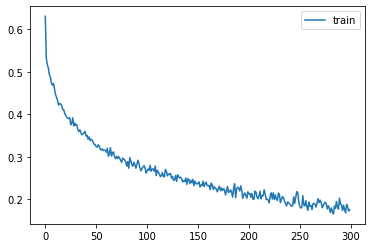

In [64]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

           S    0.81720   0.87524   0.84523       521
           B    0.85261   0.78661   0.81828       478

    accuracy                        0.83283       999
   macro avg    0.83491   0.83093   0.83175       999
weighted avg    0.83414   0.83283   0.83233       999

Confusion matrix, without normalization
[[456  65]
 [102 376]]


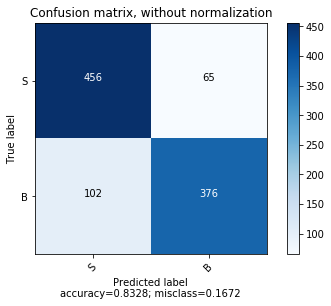

[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 

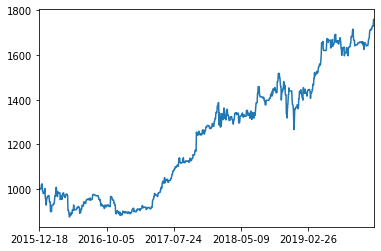

In [65]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 3s 759us/step - loss: 2.2663 - accuracy: 0.5301: 9s - loss: 7
Epoch 2/300
3992/3992 [==============================] - 1s 258us/step - loss: 0.7245 - accuracy: 0.55260s - loss: 0.7330 - ac
Epoch 3/300
3992/3992 [==============================] - 1s 364us/step - loss: 0.6804 - accuracy: 0.5832
Epoch 4/300
3992/3992 [==============================] - 1s 222us/step - loss: 0.6723 - accuracy: 0.6007
Epoch 5/300
3992/3992 [==============================] - 2s 414us/step - loss: 0.6656 - accuracy: 0.6155
Epoch 6/300
3992/3992 [==============================] - 1s 350us/step - loss: 0.6494 - accuracy: 0.62650s - los
Epoch 7/300
3992/3992 [==============================] - 1s 289us/step - loss: 0.6324 - accuracy: 0.6468
Epoch 8/300
3992/3992 [==============================] - 1s 256us/step - loss: 0.6307 - accuracy: 0.63300s - loss: 0.6246 - accuracy - ETA: 0s - loss: 0.6276 - ac
Epoch 9/300
3992/3992 [==============================] - 1

Epoch 75/300
3992/3992 [==============================] - 1s 188us/step - loss: 0.4651 - accuracy: 0.7786
Epoch 76/300
3992/3992 [==============================] - 1s 210us/step - loss: 0.4831 - accuracy: 0.7640
Epoch 77/300
3992/3992 [==============================] - 1s 189us/step - loss: 0.4896 - accuracy: 0.7588
Epoch 78/300
3992/3992 [==============================] - 1s 218us/step - loss: 0.4688 - accuracy: 0.7743
Epoch 79/300
3992/3992 [==============================] - 1s 180us/step - loss: 0.4757 - accuracy: 0.7733
Epoch 80/300
3992/3992 [==============================] - 1s 202us/step - loss: 0.4586 - accuracy: 0.7818
Epoch 81/300
3992/3992 [==============================] - 1s 189us/step - loss: 0.4576 - accuracy: 0.7756
Epoch 82/300
3992/3992 [==============================] - 1s 215us/step - loss: 0.4624 - accuracy: 0.7781
Epoch 83/300
3992/3992 [==============================] - 1s 182us/step - loss: 0.4795 - accuracy: 0.7545
Epoch 84/300
3992/3992 [======================

Epoch 151/300
3992/3992 [==============================] - 1s 252us/step - loss: 0.4264 - accuracy: 0.80090s - los
Epoch 152/300
3992/3992 [==============================] - 1s 235us/step - loss: 0.4268 - accuracy: 0.7981
Epoch 153/300
3992/3992 [==============================] - 1s 284us/step - loss: 0.4233 - accuracy: 0.7931
Epoch 154/300
3992/3992 [==============================] - 1s 332us/step - loss: 0.4217 - accuracy: 0.7943
Epoch 155/300
3992/3992 [==============================] - 1s 277us/step - loss: 0.4206 - accuracy: 0.80710s
Epoch 156/300
3992/3992 [==============================] - 1s 270us/step - loss: 0.4172 - accuracy: 0.7983
Epoch 157/300
3992/3992 [==============================] - 1s 292us/step - loss: 0.4128 - accuracy: 0.80340s - loss: 0.4162 - accuracy
Epoch 158/300
3992/3992 [==============================] - 2s 384us/step - loss: 0.4165 - accuracy: 0.8111
Epoch 159/300
3992/3992 [==============================] - 1s 304us/step - loss: 0.4269 - accuracy: 0.7998

3992/3992 [==============================] - 1s 322us/step - loss: 0.4042 - accuracy: 0.8126
Epoch 226/300
3992/3992 [==============================] - 1s 272us/step - loss: 0.3937 - accuracy: 0.8164
Epoch 227/300
3992/3992 [==============================] - 1s 313us/step - loss: 0.4055 - accuracy: 0.8099
Epoch 228/300
3992/3992 [==============================] - 1s 264us/step - loss: 0.3996 - accuracy: 0.8181
Epoch 229/300
3992/3992 [==============================] - 1s 288us/step - loss: 0.4094 - accuracy: 0.8039
Epoch 230/300
3992/3992 [==============================] - 1s 240us/step - loss: 0.4000 - accuracy: 0.8161
Epoch 231/300
3992/3992 [==============================] - 1s 221us/step - loss: 0.3873 - accuracy: 0.8216
Epoch 232/300
3992/3992 [==============================] - 1s 216us/step - loss: 0.3807 - accuracy: 0.8269
Epoch 233/300
3992/3992 [==============================] - 1s 230us/step - loss: 0.3917 - accuracy: 0.8154
Epoch 234/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 294us/step - loss: 0.3740 - accuracy: 0.83290s - loss: 0.3773 - ac
Epoch 297/300
3992/3992 [==============================] - 1s 317us/step - loss: 0.3686 - accuracy: 0.8279
Epoch 298/300
3992/3992 [==============================] - 1s 265us/step - loss: 0.3782 - accuracy: 0.8226
Epoch 299/300
3992/3992 [==============================] - 1s 257us/step - loss: 0.3602 - accuracy: 0.8354
Epoch 300/300
3992/3992 [==============================] - 1s 304us/step - loss: 0.3695 - accuracy: 0.83320s - loss: 0.380


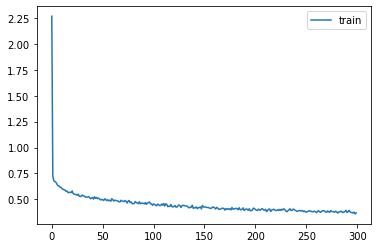

In [66]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 11
              precision    recall  f1-score   support

           S    0.80349   0.70633   0.75179       521
           B    0.71719   0.81172   0.76153       478

    accuracy                        0.75676       999
   macro avg    0.76034   0.75902   0.75666       999
weighted avg    0.76220   0.75676   0.75645       999

Confusion matrix, without normalization
[[368 153]
 [ 90 388]]


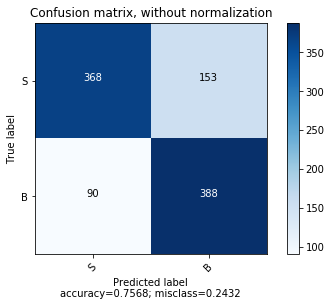

[1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 

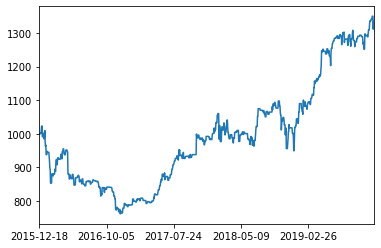

In [67]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 3s 676us/step - loss: 2.0651 - accuracy: 0.14500s - loss: 2.0709 - accuracy
Epoch 2/300
3999/3999 [==============================] - 1s 251us/step - loss: 2.0396 - accuracy: 0.1695
Epoch 3/300
3999/3999 [==============================] - 1s 210us/step - loss: 2.0267 - accuracy: 0.1745
Epoch 4/300
3999/3999 [==============================] - 1s 199us/step - loss: 2.0205 - accuracy: 0.1740
Epoch 5/300
3999/3999 [==============================] - 1s 205us/step - loss: 2.0131 - accuracy: 0.1793
Epoch 6/300
3999/3999 [==============================] - 1s 218us/step - loss: 2.0136 - accuracy: 0.18380s - loss: 2.0111 - ac
Epoch 7/300
3999/3999 [==============================] - 1s 207us/step - loss: 2.0107 - accuracy: 0.1753
Epoch 8/300
3999/3999 [==============================] - 1s 238us/step - loss: 2.0060 - accuracy: 0.18130s - loss: 2
Epoch 9/300
3999/3999 [==============================] - 1s 247us/step - loss: 2.0019 - accuracy: 

3999/3999 [==============================] - 1s 140us/step - loss: 1.8360 - accuracy: 0.2573
Epoch 76/300
3999/3999 [==============================] - 1s 174us/step - loss: 1.8376 - accuracy: 0.2563
Epoch 77/300
3999/3999 [==============================] - 1s 185us/step - loss: 1.8331 - accuracy: 0.2586
Epoch 78/300
3999/3999 [==============================] - 1s 159us/step - loss: 1.8282 - accuracy: 0.2701
Epoch 79/300
3999/3999 [==============================] - 1s 164us/step - loss: 1.8339 - accuracy: 0.2651
Epoch 80/300
3999/3999 [==============================] - 1s 196us/step - loss: 1.8192 - accuracy: 0.2678
Epoch 81/300
3999/3999 [==============================] - 1s 154us/step - loss: 1.8332 - accuracy: 0.2723
Epoch 82/300
3999/3999 [==============================] - 1s 132us/step - loss: 1.8149 - accuracy: 0.2646
Epoch 83/300
3999/3999 [==============================] - 0s 125us/step - loss: 1.8212 - accuracy: 0.2793
Epoch 84/300
3999/3999 [==============================] - 0

3999/3999 [==============================] - 1s 135us/step - loss: 1.7991 - accuracy: 0.2753
Epoch 151/300
3999/3999 [==============================] - 1s 188us/step - loss: 1.7998 - accuracy: 0.2828
Epoch 152/300
3999/3999 [==============================] - 1s 207us/step - loss: 1.7871 - accuracy: 0.2883
Epoch 153/300
3999/3999 [==============================] - 1s 300us/step - loss: 1.7848 - accuracy: 0.2766
Epoch 154/300
3999/3999 [==============================] - 1s 246us/step - loss: 1.7977 - accuracy: 0.27680s - l
Epoch 155/300
3999/3999 [==============================] - 1s 276us/step - loss: 1.7960 - accuracy: 0.2741
Epoch 156/300
3999/3999 [==============================] - 1s 196us/step - loss: 1.7957 - accuracy: 0.2833
Epoch 157/300
3999/3999 [==============================] - 1s 242us/step - loss: 1.7949 - accuracy: 0.2888
Epoch 158/300
3999/3999 [==============================] - 1s 200us/step - loss: 1.7902 - accuracy: 0.2786
Epoch 159/300
3999/3999 [====================

3999/3999 [==============================] - 0s 100us/step - loss: 1.7946 - accuracy: 0.2803
Epoch 225/300
3999/3999 [==============================] - 0s 112us/step - loss: 1.7867 - accuracy: 0.2941
Epoch 226/300
3999/3999 [==============================] - 1s 153us/step - loss: 1.8009 - accuracy: 0.2803
Epoch 227/300
3999/3999 [==============================] - 1s 130us/step - loss: 1.7905 - accuracy: 0.2896
Epoch 228/300
3999/3999 [==============================] - 0s 92us/step - loss: 1.7939 - accuracy: 0.2783
Epoch 229/300
3999/3999 [==============================] - 0s 105us/step - loss: 1.7802 - accuracy: 0.2881
Epoch 230/300
3999/3999 [==============================] - 0s 102us/step - loss: 1.7801 - accuracy: 0.2853
Epoch 231/300
3999/3999 [==============================] - 1s 149us/step - loss: 1.7814 - accuracy: 0.2868
Epoch 232/300
3999/3999 [==============================] - 1s 134us/step - loss: 1.7950 - accuracy: 0.2828
Epoch 233/300
3999/3999 [===========================

3999/3999 [==============================] - 0s 103us/step - loss: 1.7909 - accuracy: 0.2788


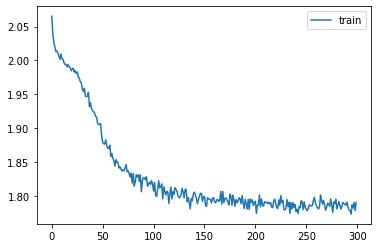

In [68]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

          B3    1.00000   0.05435   0.10309        92
          B2    0.00000   0.00000   0.00000       137
          B1    0.00000   0.00000   0.00000       124
          B0    0.00000   0.00000   0.00000       157
          S0    0.00000   0.00000   0.00000       165
          S1    0.00000   0.00000   0.00000       123
          S2    0.00000   0.00000   0.00000       115
          S3    0.92308   0.13793   0.24000        87

   micro avg    0.94444   0.01700   0.03340      1000
   macro avg    0.24038   0.02403   0.04289      1000
weighted avg    0.17231   0.01700   0.03036      1000
 samples avg    0.01700   0.01700   0.01700      1000

Confusion matrix, without normalization
[[ 92   0   0   0   0   0   0   0]
 [137   0   0   0   0   0   0   0]
 [124   0   0   0   0   0   0   0]
 [157   0   0   0   0   0   0   0]
 [165   0   0   0   0   0   0   0]
 [123   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


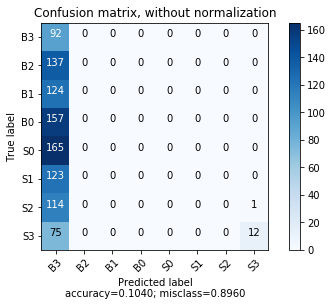

[7, 4, 1, 4, 4, 3, 7, 6, 4, 3, 3, 4, 4, 4, 1, 1, 3, 4, 6, 1, 7, 6, 4, 1, 4, 3, 4, 1, 3, 5, 7, 1, 4, 6, 3, 3, 4, 3, 4, 6, 4, 6, 4, 6, 3, 5, 6, 7, 4, 4, 4, 4, 4, 6, 4, 6, 4, 3, 7, 4, 3, 4, 6, 4, 1, 3, 6, 4, 3, 3, 3, 3, 6, 4, 4, 4, 3, 4, 3, 6, 4, 4, 4, 3, 6, 3, 3, 7, 3, 6, 1, 3, 3, 4, 4, 6, 4, 4, 4, 3, 0, 4, 3, 3, 3, 5, 6, 3, 4, 3, 4, 3, 6, 3, 3, 6, 7, 4, 4, 6, 1, 3, 4, 4, 4, 7, 3, 6, 1, 7, 4, 3, 4, 3, 4, 4, 6, 4, 1, 4, 6, 6, 3, 4, 0, 4, 4, 4, 3, 3, 3, 4, 3, 6, 4, 3, 4, 3, 3, 3, 6, 6, 6, 1, 3, 3, 1, 4, 4, 1, 0, 1, 6, 6, 4, 4, 6, 3, 6, 6, 3, 4, 3, 6, 1, 4, 3, 4, 3, 3, 3, 3, 7, 6, 3, 6, 3, 7, 4, 6, 3, 4, 7, 4, 4, 3, 3, 6, 6, 3, 6, 4, 4, 3, 6, 3, 7, 4, 4, 3, 3, 3, 1, 3, 4, 7, 4, 3, 4, 4, 4, 4, 7, 4, 3, 4, 4, 6, 4, 4, 1, 3, 3, 4, 3, 7, 3, 3, 3, 3, 7, 4, 3, 7, 6, 4, 3, 4, 1, 0, 3, 4, 5, 4, 3, 3, 6, 4, 4, 3, 6, 3, 4, 3, 4, 4, 7, 4, 7, 4, 3, 6, 5, 4, 4, 6, 3, 3, 4, 4, 6, 4, 6, 4, 4, 4, 6, 1, 6, 3, 3, 4, 3, 1, 4, 4, 4, 4, 7, 6, 5, 3, 4, 0, 3, 6, 4, 3, 4, 4, 1, 3, 4, 6, 4, 4, 4, 7, 6, 4, 3, 6, 3, 

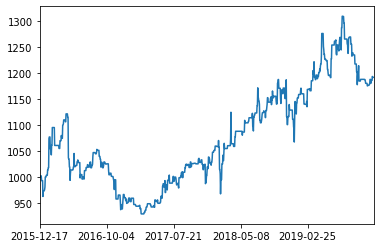

In [69]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 178us/step - loss: 2.0726 - accuracy: 0.1615
Epoch 2/300
3999/3999 [==============================] - 0s 86us/step - loss: 2.0279 - accuracy: 0.1770
Epoch 3/300
3999/3999 [==============================] - 0s 81us/step - loss: 2.0051 - accuracy: 0.1818
Epoch 4/300
3999/3999 [==============================] - 0s 77us/step - loss: 1.9902 - accuracy: 0.1900
Epoch 5/300
3999/3999 [==============================] - 0s 84us/step - loss: 1.9725 - accuracy: 0.1948
Epoch 6/300
3999/3999 [==============================] - 0s 79us/step - loss: 1.9619 - accuracy: 0.2016
Epoch 7/300
3999/3999 [==============================] - 0s 77us/step - loss: 1.9440 - accuracy: 0.2093
Epoch 8/300
3999/3999 [==============================] - 0s 81us/step - loss: 1.9216 - accuracy: 0.2138
Epoch 9/300
3999/3999 [==============================] - 0s 81us/step - loss: 1.9049 - accuracy: 0.2263
Epoch 10/300
3999/3999 [==============================] - 0s 82

3999/3999 [==============================] - 0s 82us/step - loss: 1.1119 - accuracy: 0.5154
Epoch 79/300
3999/3999 [==============================] - 0s 84us/step - loss: 1.1224 - accuracy: 0.5071
Epoch 80/300
3999/3999 [==============================] - 0s 83us/step - loss: 1.1135 - accuracy: 0.5054
Epoch 81/300
3999/3999 [==============================] - 0s 83us/step - loss: 1.1157 - accuracy: 0.5071
Epoch 82/300
3999/3999 [==============================] - 0s 86us/step - loss: 1.1140 - accuracy: 0.5081
Epoch 83/300
3999/3999 [==============================] - 0s 85us/step - loss: 1.0982 - accuracy: 0.5151
Epoch 84/300
3999/3999 [==============================] - 0s 85us/step - loss: 1.1168 - accuracy: 0.5026
Epoch 85/300
3999/3999 [==============================] - 0s 89us/step - loss: 1.0928 - accuracy: 0.5159
Epoch 86/300
3999/3999 [==============================] - 0s 81us/step - loss: 1.0931 - accuracy: 0.5236
Epoch 87/300
3999/3999 [==============================] - 0s 83us/st

3999/3999 [==============================] - 1s 158us/step - loss: 1.0115 - accuracy: 0.5549
Epoch 154/300
3999/3999 [==============================] - 1s 241us/step - loss: 0.9939 - accuracy: 0.5671
Epoch 155/300
3999/3999 [==============================] - 1s 201us/step - loss: 1.0099 - accuracy: 0.5514
Epoch 156/300
3999/3999 [==============================] - 1s 193us/step - loss: 0.9884 - accuracy: 0.5614
Epoch 157/300
3999/3999 [==============================] - 1s 219us/step - loss: 1.0079 - accuracy: 0.5541
Epoch 158/300
3999/3999 [==============================] - 1s 205us/step - loss: 1.0079 - accuracy: 0.56410s - loss: 1.0166 
Epoch 159/300
3999/3999 [==============================] - 1s 177us/step - loss: 1.0255 - accuracy: 0.5546
Epoch 160/300
3999/3999 [==============================] - 1s 203us/step - loss: 1.0096 - accuracy: 0.5599
Epoch 161/300
3999/3999 [==============================] - 1s 155us/step - loss: 0.9959 - accuracy: 0.5624
Epoch 162/300
3999/3999 [========

Epoch 230/300
3999/3999 [==============================] - 1s 136us/step - loss: 1.0022 - accuracy: 0.5641
Epoch 231/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.9725 - accuracy: 0.5726
Epoch 232/300
3999/3999 [==============================] - 0s 120us/step - loss: 0.9837 - accuracy: 0.5734
Epoch 233/300
3999/3999 [==============================] - 1s 132us/step - loss: 0.9751 - accuracy: 0.5711
Epoch 234/300
3999/3999 [==============================] - 1s 126us/step - loss: 0.9849 - accuracy: 0.5774
Epoch 235/300
3999/3999 [==============================] - 0s 91us/step - loss: 0.9698 - accuracy: 0.5789
Epoch 236/300
3999/3999 [==============================] - 0s 83us/step - loss: 0.9796 - accuracy: 0.5729
Epoch 237/300
3999/3999 [==============================] - 0s 83us/step - loss: 0.9771 - accuracy: 0.5766
Epoch 238/300
3999/3999 [==============================] - 0s 82us/step - loss: 0.9512 - accuracy: 0.5804
Epoch 239/300
3999/3999 [================

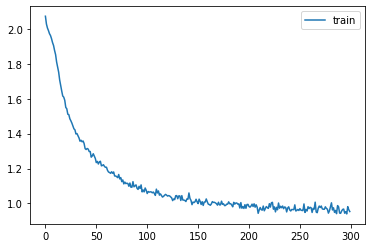

In [70]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.81250   0.56522   0.66667        92
          B2    0.58824   0.14599   0.23392       137
          B1    0.75000   0.16935   0.27632       124
          B0    0.90244   0.70701   0.79286       157
          S0    0.85455   0.85455   0.85455       165
          S1    0.66667   0.08130   0.14493       123
          S2    0.55556   0.30435   0.39326       115
          S3    0.79661   0.54023   0.64384        87

   micro avg    0.79310   0.43700   0.56351      1000
   macro avg    0.74082   0.42100   0.50079      1000
weighted avg    0.74622   0.43700   0.51219      1000
 samples avg    0.43700   0.43700   0.43700      1000

Confusion matrix, without normalization
[[ 89   3   0   0   0   0   0   0]
 [114  20   2   1   0   0   0   0]
 [ 84  11  21   8   0   0   0   0]
 [ 38   0   5 111   3   0   0   0]
 [ 20   0   0   2 141   2   0   0]
 [ 79   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


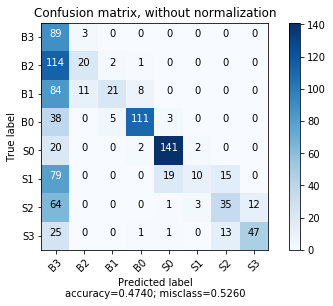

[6, 1, 1, 5, 0, 5, 6, 4, 1, 4, 0, 4, 4, 4, 0, 0, 5, 1, 3, 0, 7, 4, 3, 1, 5, 2, 4, 0, 3, 4, 6, 1, 4, 6, 1, 1, 4, 0, 4, 7, 4, 5, 3, 6, 4, 3, 7, 7, 5, 5, 3, 3, 3, 4, 3, 6, 4, 1, 7, 3, 0, 6, 4, 0, 1, 6, 6, 6, 6, 1, 3, 2, 7, 3, 3, 4, 1, 6, 4, 6, 3, 3, 7, 1, 6, 0, 1, 5, 1, 4, 1, 0, 5, 2, 4, 6, 6, 4, 4, 1, 1, 7, 2, 4, 5, 3, 4, 4, 4, 3, 4, 2, 6, 4, 4, 4, 7, 7, 3, 6, 1, 1, 3, 4, 4, 6, 3, 4, 1, 7, 2, 1, 3, 1, 4, 6, 6, 1, 2, 1, 3, 7, 3, 4, 0, 4, 3, 6, 0, 0, 1, 3, 2, 5, 5, 3, 4, 2, 0, 3, 7, 4, 7, 0, 4, 1, 6, 2, 4, 3, 0, 0, 4, 5, 2, 3, 5, 3, 4, 4, 1, 3, 1, 5, 1, 6, 4, 2, 1, 5, 0, 1, 7, 6, 1, 2, 2, 7, 5, 4, 3, 0, 3, 2, 4, 1, 1, 1, 4, 1, 6, 4, 6, 3, 4, 4, 7, 5, 4, 1, 1, 6, 1, 0, 6, 7, 5, 2, 3, 5, 5, 6, 7, 3, 2, 6, 4, 3, 3, 4, 2, 1, 3, 2, 2, 7, 1, 0, 0, 4, 6, 1, 3, 7, 5, 1, 0, 6, 1, 0, 3, 6, 4, 3, 4, 3, 5, 4, 1, 0, 5, 0, 4, 4, 3, 5, 6, 4, 6, 4, 1, 6, 7, 4, 5, 6, 0, 4, 1, 3, 4, 1, 6, 4, 0, 4, 5, 6, 4, 1, 1, 1, 0, 4, 5, 6, 6, 6, 7, 6, 3, 3, 6, 0, 2, 3, 3, 1, 3, 4, 1, 3, 3, 6, 3, 5, 1, 6, 3, 1, 3, 3, 6, 

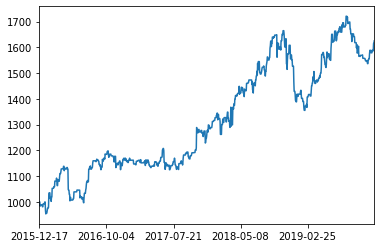

In [71]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 214us/step - loss: 2.0406 - accuracy: 0.1868
Epoch 2/300
3999/3999 [==============================] - 0s 93us/step - loss: 1.9145 - accuracy: 0.2178
Epoch 3/300
3999/3999 [==============================] - 0s 88us/step - loss: 1.8809 - accuracy: 0.2243
Epoch 4/300
3999/3999 [==============================] - 0s 92us/step - loss: 1.8618 - accuracy: 0.2288
Epoch 5/300
3999/3999 [==============================] - 0s 83us/step - loss: 1.8161 - accuracy: 0.2491
Epoch 6/300
3999/3999 [==============================] - 0s 92us/step - loss: 1.8024 - accuracy: 0.2548
Epoch 7/300
3999/3999 [==============================] - 0s 97us/step - loss: 1.7875 - accuracy: 0.2616
Epoch 8/300
3999/3999 [==============================] - 0s 85us/step - loss: 1.7685 - accuracy: 0.2686
Epoch 9/300
3999/3999 [==============================] - 0s 76us/step - loss: 1.7571 - accuracy: 0.2713
Epoch 10/300
3999/3999 [==============================] - 0s 85

3999/3999 [==============================] - 0s 120us/step - loss: 1.2935 - accuracy: 0.4469
Epoch 79/300
3999/3999 [==============================] - 0s 120us/step - loss: 1.2925 - accuracy: 0.4566
Epoch 80/300
3999/3999 [==============================] - 0s 102us/step - loss: 1.2776 - accuracy: 0.4544
Epoch 81/300
3999/3999 [==============================] - 0s 121us/step - loss: 1.2714 - accuracy: 0.4509
Epoch 82/300
3999/3999 [==============================] - 0s 82us/step - loss: 1.2611 - accuracy: 0.4614
Epoch 83/300
3999/3999 [==============================] - 1s 145us/step - loss: 1.2731 - accuracy: 0.4506
Epoch 84/300
3999/3999 [==============================] - 0s 120us/step - loss: 1.2634 - accuracy: 0.4709
Epoch 85/300
3999/3999 [==============================] - 1s 140us/step - loss: 1.2549 - accuracy: 0.4601
Epoch 86/300
3999/3999 [==============================] - 1s 129us/step - loss: 1.2871 - accuracy: 0.4426
Epoch 87/300
3999/3999 [==============================] - 1s

3999/3999 [==============================] - 0s 87us/step - loss: 1.0926 - accuracy: 0.5276
Epoch 155/300
3999/3999 [==============================] - 0s 97us/step - loss: 1.0670 - accuracy: 0.5386
Epoch 156/300
3999/3999 [==============================] - 0s 97us/step - loss: 1.0777 - accuracy: 0.5324
Epoch 157/300
3999/3999 [==============================] - 0s 96us/step - loss: 1.0643 - accuracy: 0.5339
Epoch 158/300
3999/3999 [==============================] - 0s 91us/step - loss: 1.0966 - accuracy: 0.5151
Epoch 159/300
3999/3999 [==============================] - 0s 91us/step - loss: 1.0457 - accuracy: 0.5309
Epoch 160/300
3999/3999 [==============================] - 0s 89us/step - loss: 1.0830 - accuracy: 0.5299
Epoch 161/300
3999/3999 [==============================] - 0s 95us/step - loss: 1.0593 - accuracy: 0.5231
Epoch 162/300
3999/3999 [==============================] - 0s 95us/step - loss: 1.0654 - accuracy: 0.5361
Epoch 163/300
3999/3999 [==============================] - 0

3999/3999 [==============================] - 0s 89us/step - loss: 1.0017 - accuracy: 0.5569
Epoch 231/300
3999/3999 [==============================] - 0s 88us/step - loss: 1.0003 - accuracy: 0.5576
Epoch 232/300
3999/3999 [==============================] - 0s 95us/step - loss: 1.0109 - accuracy: 0.5576
Epoch 233/300
3999/3999 [==============================] - 0s 82us/step - loss: 1.0150 - accuracy: 0.5501
Epoch 234/300
3999/3999 [==============================] - 0s 96us/step - loss: 1.0264 - accuracy: 0.5576
Epoch 235/300
3999/3999 [==============================] - 0s 87us/step - loss: 1.0084 - accuracy: 0.5499
Epoch 236/300
3999/3999 [==============================] - 0s 99us/step - loss: 1.0027 - accuracy: 0.5606
Epoch 237/300
3999/3999 [==============================] - 0s 114us/step - loss: 1.0183 - accuracy: 0.5529
Epoch 238/300
3999/3999 [==============================] - 1s 127us/step - loss: 1.0212 - accuracy: 0.5444
Epoch 239/300
3999/3999 [==============================] -

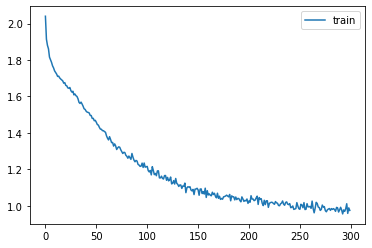

In [72]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.81818   0.48913   0.61224        92
          B2    0.78571   0.08029   0.14570       137
          B1    0.68966   0.16129   0.26144       124
          B0    0.76000   0.60510   0.67376       157
          S0    0.71176   0.73333   0.72239       165
          S1    0.67442   0.23577   0.34940       123
          S2    0.59483   0.60000   0.59740       115
          S3    0.92308   0.41379   0.57143        87

   micro avg    0.72081   0.42600   0.53551      1000
   macro avg    0.74470   0.41484   0.49172      1000
weighted avg    0.73686   0.42600   0.49507      1000
 samples avg    0.42600   0.42600   0.42600      1000

Confusion matrix, without normalization
[[ 90   2   0   0   0   0   0   0]
 [117  11   6   3   0   0   0   0]
 [ 76   1  20  26   0   0   0   1]
 [ 23   0   3  95  36   0   0   0]
 [ 30   0   0   1 121  11   2   0]
 [ 68   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


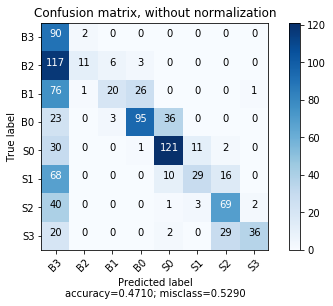

[6, 1, 3, 5, 1, 6, 6, 4, 1, 4, 1, 5, 3, 4, 0, 0, 4, 2, 4, 0, 6, 4, 3, 1, 5, 2, 4, 1, 3, 4, 6, 2, 4, 6, 2, 0, 5, 1, 6, 7, 3, 5, 3, 6, 4, 2, 7, 7, 5, 5, 3, 4, 3, 4, 3, 6, 4, 1, 6, 3, 0, 6, 5, 1, 1, 6, 5, 6, 6, 3, 3, 3, 6, 3, 4, 5, 1, 6, 4, 6, 3, 3, 7, 1, 6, 1, 1, 6, 2, 4, 1, 1, 6, 3, 4, 6, 6, 4, 4, 1, 0, 6, 2, 4, 5, 3, 4, 4, 4, 2, 4, 2, 6, 4, 4, 4, 6, 7, 3, 5, 1, 1, 4, 4, 4, 7, 3, 5, 1, 7, 2, 1, 3, 2, 4, 6, 6, 2, 2, 1, 2, 7, 3, 5, 0, 4, 4, 6, 0, 1, 0, 3, 2, 6, 5, 4, 4, 2, 0, 3, 7, 5, 6, 1, 4, 1, 5, 2, 4, 3, 0, 0, 4, 5, 2, 3, 5, 3, 4, 4, 1, 3, 1, 5, 1, 6, 4, 3, 2, 5, 0, 1, 6, 6, 1, 2, 2, 6, 5, 4, 3, 3, 4, 2, 4, 1, 3, 3, 4, 1, 6, 4, 6, 4, 5, 3, 7, 5, 5, 1, 2, 6, 1, 1, 6, 7, 6, 2, 4, 5, 6, 6, 6, 3, 2, 6, 4, 4, 4, 4, 3, 2, 3, 2, 2, 6, 1, 1, 1, 5, 6, 1, 3, 6, 5, 2, 1, 6, 1, 0, 3, 6, 4, 3, 4, 4, 5, 4, 1, 1, 6, 0, 4, 3, 3, 5, 6, 5, 6, 4, 1, 6, 6, 4, 5, 6, 0, 4, 1, 3, 4, 1, 6, 5, 1, 4, 5, 6, 5, 0, 1, 1, 0, 3, 5, 5, 6, 6, 7, 6, 3, 3, 6, 0, 2, 3, 3, 1, 3, 5, 1, 3, 3, 6, 3, 5, 1, 6, 3, 3, 3, 3, 6, 

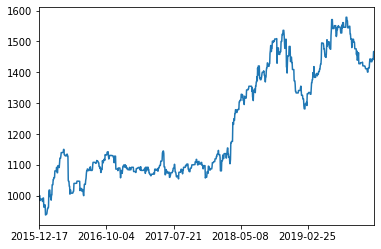

In [73]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 275us/step - loss: 4.5967 - accuracy: 0.1533
Epoch 2/300
3999/3999 [==============================] - 1s 158us/step - loss: 2.0914 - accuracy: 0.16780s - loss: 2.0915 - accuracy: 0.
Epoch 3/300
3999/3999 [==============================] - 1s 235us/step - loss: 2.0717 - accuracy: 0.1755
Epoch 4/300
3999/3999 [==============================] - 1s 213us/step - loss: 2.0428 - accuracy: 0.1835
Epoch 5/300
3999/3999 [==============================] - 1s 258us/step - loss: 2.0390 - accuracy: 0.1863
Epoch 6/300
3999/3999 [==============================] - 1s 251us/step - loss: 2.0336 - accuracy: 0.18800s - loss: 2.0317 - accu
Epoch 7/300
3999/3999 [==============================] - 1s 183us/step - loss: 2.0273 - accuracy: 0.1895
Epoch 8/300
3999/3999 [==============================] - 1s 334us/step - loss: 2.0228 - accuracy: 0.18950s - l
Epoch 9/300
3999/3999 [==============================] - 1s 213us/step - loss: 2.0180 - accuracy: 

3999/3999 [==============================] - 0s 109us/step - loss: 1.7711 - accuracy: 0.2816
Epoch 75/300
3999/3999 [==============================] - 0s 115us/step - loss: 1.7609 - accuracy: 0.2873
Epoch 76/300
3999/3999 [==============================] - 1s 179us/step - loss: 1.7556 - accuracy: 0.2868
Epoch 77/300
3999/3999 [==============================] - 1s 179us/step - loss: 1.7557 - accuracy: 0.2828
Epoch 78/300
3999/3999 [==============================] - 1s 218us/step - loss: 1.7572 - accuracy: 0.29080s - loss: 1.758 - ETA: 0s - loss: 1.7566 - accuracy: 0.
Epoch 79/300
3999/3999 [==============================] - 1s 195us/step - loss: 1.7423 - accuracy: 0.3016
Epoch 80/300
3999/3999 [==============================] - 1s 208us/step - loss: 1.7336 - accuracy: 0.2926
Epoch 81/300
3999/3999 [==============================] - 1s 310us/step - loss: 1.7542 - accuracy: 0.2888
Epoch 82/300
3999/3999 [==============================] - 1s 222us/step - loss: 1.7458 - accuracy: 0.2886
Epo

3999/3999 [==============================] - 1s 131us/step - loss: 1.6549 - accuracy: 0.3191
Epoch 149/300
3999/3999 [==============================] - 0s 118us/step - loss: 1.6662 - accuracy: 0.3056
Epoch 150/300
3999/3999 [==============================] - 1s 136us/step - loss: 1.6533 - accuracy: 0.3223
Epoch 151/300
3999/3999 [==============================] - 0s 120us/step - loss: 1.6594 - accuracy: 0.32310s - loss: 1.6277 - accu
Epoch 152/300
3999/3999 [==============================] - 0s 116us/step - loss: 1.6498 - accuracy: 0.3276
Epoch 153/300
3999/3999 [==============================] - 1s 147us/step - loss: 1.6504 - accuracy: 0.3253
Epoch 154/300
3999/3999 [==============================] - 0s 113us/step - loss: 1.6624 - accuracy: 0.3131
Epoch 155/300
3999/3999 [==============================] - 0s 123us/step - loss: 1.6424 - accuracy: 0.3261
Epoch 156/300
3999/3999 [==============================] - 0s 121us/step - loss: 1.6539 - accuracy: 0.3291
Epoch 157/300
3999/3999 [==

3999/3999 [==============================] - 0s 91us/step - loss: 1.6118 - accuracy: 0.3368
Epoch 225/300
3999/3999 [==============================] - 0s 74us/step - loss: 1.6172 - accuracy: 0.3308
Epoch 226/300
3999/3999 [==============================] - 0s 75us/step - loss: 1.6094 - accuracy: 0.3393
Epoch 227/300
3999/3999 [==============================] - 0s 75us/step - loss: 1.6040 - accuracy: 0.3353
Epoch 228/300
3999/3999 [==============================] - 0s 80us/step - loss: 1.6021 - accuracy: 0.3443
Epoch 229/300
3999/3999 [==============================] - 0s 79us/step - loss: 1.5888 - accuracy: 0.3468
Epoch 230/300
3999/3999 [==============================] - 0s 75us/step - loss: 1.5933 - accuracy: 0.3283
Epoch 231/300
3999/3999 [==============================] - 0s 76us/step - loss: 1.5733 - accuracy: 0.3456 0s - loss: 1.5822 - accuracy: 
Epoch 232/300
3999/3999 [==============================] - 0s 77us/step - loss: 1.6052 - accuracy: 0.3393
Epoch 233/300
3999/3999 [====

3999/3999 [==============================] - 0s 107us/step - loss: 1.5753 - accuracy: 0.3466
Epoch 300/300
3999/3999 [==============================] - 1s 130us/step - loss: 1.5316 - accuracy: 0.3531


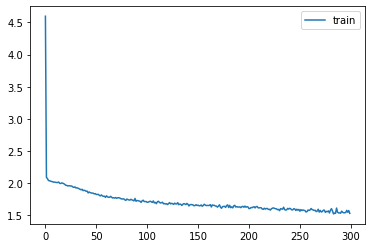

In [74]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 11
              precision    recall  f1-score   support

          B3    0.63333   0.20652   0.31148        92
          B2    0.00000   0.00000   0.00000       137
          B1    0.00000   0.00000   0.00000       124
          B0    0.00000   0.00000   0.00000       157
          S0    0.00000   0.00000   0.00000       165
          S1    0.00000   0.00000   0.00000       123
          S2    0.00000   0.00000   0.00000       115
          S3    0.57895   0.12644   0.20755        87

   micro avg    0.60000   0.03000   0.05714      1000
   macro avg    0.15154   0.04162   0.06488      1000
weighted avg    0.10864   0.03000   0.04671      1000
 samples avg    0.03000   0.03000   0.03000      1000

Confusion matrix, without normalization
[[ 92   0   0   0   0   0   0   0]
 [136   0   0   0   0   0   0   1]
 [124   0   0   0   0   0   0   0]
 [155   0   0   0   0   0   0   2]
 [165   0   0   0   0   0   0   0]
 [120   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


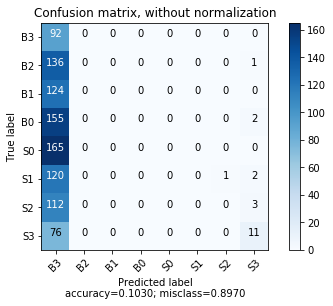

[6, 3, 0, 6, 3, 6, 6, 6, 0, 3, 1, 6, 3, 3, 0, 1, 3, 3, 4, 0, 6, 4, 1, 1, 6, 1, 3, 1, 1, 4, 7, 1, 4, 6, 3, 0, 4, 0, 6, 7, 0, 6, 3, 6, 4, 1, 6, 6, 4, 4, 3, 1, 3, 6, 3, 4, 3, 1, 6, 5, 1, 4, 3, 1, 3, 6, 6, 4, 7, 1, 3, 3, 6, 1, 3, 4, 1, 4, 4, 6, 1, 1, 6, 1, 6, 0, 1, 7, 1, 4, 1, 1, 4, 1, 4, 6, 4, 4, 6, 1, 1, 6, 3, 3, 3, 0, 4, 3, 1, 1, 4, 3, 4, 3, 4, 3, 6, 6, 3, 6, 1, 3, 3, 4, 3, 6, 3, 6, 1, 6, 3, 0, 4, 3, 3, 4, 6, 4, 1, 0, 3, 6, 3, 4, 0, 3, 4, 4, 0, 0, 1, 3, 3, 4, 3, 5, 4, 3, 1, 0, 6, 4, 6, 0, 3, 0, 0, 0, 4, 3, 0, 1, 1, 6, 1, 4, 6, 1, 4, 4, 4, 0, 1, 7, 1, 6, 4, 4, 1, 3, 0, 3, 6, 6, 1, 4, 3, 6, 4, 4, 4, 0, 4, 3, 4, 1, 4, 0, 6, 1, 3, 4, 7, 3, 4, 0, 7, 4, 4, 3, 3, 6, 0, 0, 6, 6, 6, 3, 4, 4, 6, 6, 6, 3, 3, 6, 3, 6, 3, 3, 4, 3, 3, 3, 1, 6, 1, 1, 0, 6, 6, 1, 3, 6, 4, 3, 1, 4, 1, 1, 3, 6, 6, 3, 3, 3, 4, 3, 1, 2, 6, 0, 3, 1, 3, 3, 6, 4, 6, 4, 1, 3, 4, 4, 4, 6, 0, 4, 1, 3, 4, 3, 7, 3, 1, 4, 4, 4, 4, 1, 1, 1, 1, 0, 4, 4, 4, 1, 7, 4, 6, 1, 6, 0, 1, 3, 1, 3, 3, 4, 1, 3, 0, 6, 3, 3, 3, 6, 3, 3, 3, 4, 4, 

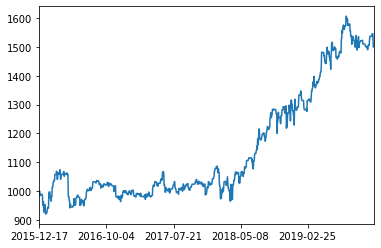

In [75]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 192us/step - loss: 2.0242 - accuracy: 0.1702
Epoch 2/300
3996/3996 [==============================] - 0s 87us/step - loss: 1.8840 - accuracy: 0.2355
Epoch 3/300
3996/3996 [==============================] - 0s 91us/step - loss: 1.8377 - accuracy: 0.2548
Epoch 4/300
3996/3996 [==============================] - 0s 81us/step - loss: 1.8353 - accuracy: 0.2487
Epoch 5/300
3996/3996 [==============================] - 0s 79us/step - loss: 1.8245 - accuracy: 0.2528
Epoch 6/300
3996/3996 [==============================] - 0s 84us/step - loss: 1.8097 - accuracy: 0.2525
Epoch 7/300
3996/3996 [==============================] - 0s 81us/step - loss: 1.8059 - accuracy: 0.2638
Epoch 8/300
3996/3996 [==============================] - 0s 81us/step - loss: 1.8008 - accuracy: 0.2665
Epoch 9/300
3996/3996 [==============================] - 0s 82us/step - loss: 1.7925 - accuracy: 0.2658
Epoch 10/300
3996/3996 [==============================] - 0s 78

3996/3996 [==============================] - 0s 78us/step - loss: 1.6689 - accuracy: 0.3266
Epoch 79/300
3996/3996 [==============================] - 0s 87us/step - loss: 1.6677 - accuracy: 0.3146
Epoch 80/300
3996/3996 [==============================] - 0s 90us/step - loss: 1.6577 - accuracy: 0.3166
Epoch 81/300
3996/3996 [==============================] - 0s 86us/step - loss: 1.6613 - accuracy: 0.3278
Epoch 82/300
3996/3996 [==============================] - 0s 85us/step - loss: 1.6600 - accuracy: 0.3306
Epoch 83/300
3996/3996 [==============================] - 0s 104us/step - loss: 1.6637 - accuracy: 0.3198
Epoch 84/300
3996/3996 [==============================] - 0s 103us/step - loss: 1.6541 - accuracy: 0.3228
Epoch 85/300
3996/3996 [==============================] - 0s 101us/step - loss: 1.6536 - accuracy: 0.3168
Epoch 86/300
3996/3996 [==============================] - 0s 86us/step - loss: 1.6502 - accuracy: 0.3223
Epoch 87/300
3996/3996 [==============================] - 1s 127u

3996/3996 [==============================] - 0s 109us/step - loss: 1.6057 - accuracy: 0.3383
Epoch 154/300
3996/3996 [==============================] - 0s 90us/step - loss: 1.6117 - accuracy: 0.3501
Epoch 155/300
3996/3996 [==============================] - 0s 117us/step - loss: 1.6079 - accuracy: 0.3421
Epoch 156/300
3996/3996 [==============================] - 1s 136us/step - loss: 1.6103 - accuracy: 0.3549
Epoch 157/300
3996/3996 [==============================] - 0s 116us/step - loss: 1.5997 - accuracy: 0.3471
Epoch 158/300
3996/3996 [==============================] - 0s 107us/step - loss: 1.6085 - accuracy: 0.3478
Epoch 159/300
3996/3996 [==============================] - 0s 110us/step - loss: 1.6031 - accuracy: 0.3509
Epoch 160/300
3996/3996 [==============================] - 0s 113us/step - loss: 1.6082 - accuracy: 0.3423
Epoch 161/300
3996/3996 [==============================] - 0s 109us/step - loss: 1.6080 - accuracy: 0.3511
Epoch 162/300
3996/3996 [===========================

3996/3996 [==============================] - 0s 122us/step - loss: 1.5970 - accuracy: 0.3406
Epoch 230/300
3996/3996 [==============================] - 0s 88us/step - loss: 1.5933 - accuracy: 0.3448
Epoch 231/300
3996/3996 [==============================] - 0s 112us/step - loss: 1.5945 - accuracy: 0.3421
Epoch 232/300
3996/3996 [==============================] - 0s 99us/step - loss: 1.5928 - accuracy: 0.3416
Epoch 233/300
3996/3996 [==============================] - 0s 91us/step - loss: 1.5914 - accuracy: 0.3461
Epoch 234/300
3996/3996 [==============================] - 0s 89us/step - loss: 1.5874 - accuracy: 0.3471
Epoch 235/300
3996/3996 [==============================] - 0s 83us/step - loss: 1.5866 - accuracy: 0.3504
Epoch 236/300
3996/3996 [==============================] - 0s 103us/step - loss: 1.6034 - accuracy: 0.3461
Epoch 237/300
3996/3996 [==============================] - 0s 102us/step - loss: 1.5955 - accuracy: 0.3471
Epoch 238/300
3996/3996 [==============================]

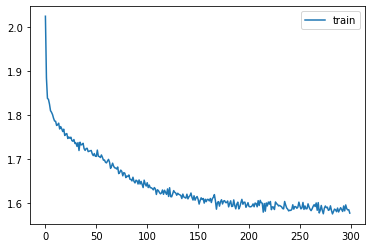

In [76]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.74286   0.29885   0.42623        87
          B2    0.00000   0.00000   0.00000       126
          B1    0.00000   0.00000   0.00000       123
          B0    0.00000   0.00000   0.00000       170
          S0    0.00000   0.00000   0.00000       160
          S1    0.00000   0.00000   0.00000       125
          S2    0.00000   0.00000   0.00000       137
          S3    0.61818   0.47222   0.53543        72

   micro avg    0.66667   0.06000   0.11009      1000
   macro avg    0.17013   0.09638   0.12021      1000
weighted avg    0.10914   0.06000   0.07563      1000
 samples avg    0.06000   0.06000   0.06000      1000

Confusion matrix, without normalization
[[ 87   0   0   0   0   0   0   0]
 [125   0   0   0   0   0   0   1]
 [122   0   0   0   0   0   0   1]
 [170   0   0   0   0   0   0   0]
 [158   0   0   0   0   0   0   2]
 [123   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


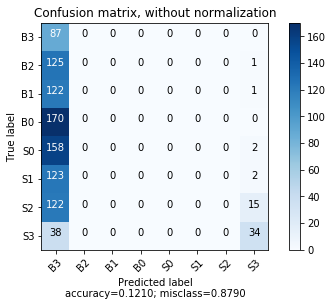

[6, 6, 1, 4, 5, 3, 4, 1, 1, 3, 4, 4, 0, 3, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 6, 7, 3, 4, 4, 4, 6, 4, 4, 4, 4, 0, 1, 1, 6, 3, 1, 4, 4, 1, 5, 6, 6, 6, 6, 6, 7, 5, 1, 0, 6, 4, 7, 4, 4, 3, 4, 3, 3, 6, 5, 7, 7, 4, 7, 1, 6, 6, 7, 4, 6, 4, 7, 1, 1, 6, 3, 3, 7, 0, 3, 7, 4, 1, 6, 3, 3, 6, 6, 4, 4, 6, 4, 7, 2, 3, 0, 6, 0, 5, 7, 4, 4, 3, 7, 7, 7, 0, 4, 0, 1, 3, 4, 4, 1, 5, 6, 4, 3, 4, 3, 4, 6, 4, 4, 5, 1, 4, 1, 0, 4, 1, 4, 4, 4, 6, 6, 6, 3, 3, 1, 4, 1, 4, 4, 1, 0, 7, 3, 1, 4, 3, 6, 4, 1, 3, 3, 0, 4, 3, 1, 3, 7, 6, 3, 1, 1, 7, 1, 3, 4, 4, 4, 4, 4, 1, 1, 1, 1, 7, 0, 0, 4, 4, 7, 3, 4, 3, 7, 4, 7, 4, 3, 6, 6, 1, 4, 1, 4, 1, 4, 2, 7, 6, 7, 4, 1, 1, 1, 0, 6, 0, 5, 7, 4, 6, 3, 3, 4, 3, 7, 3, 6, 3, 6, 4, 4, 0, 3, 7, 1, 6, 1, 3, 0, 1, 0, 4, 4, 2, 4, 2, 6, 4, 0, 6, 3, 3, 1, 1, 4, 4, 3, 6, 1, 1, 0, 1, 4, 6, 6, 3, 4, 1, 5, 7, 4, 3, 4, 1, 7, 6, 1, 5, 0, 3, 0, 7, 4, 1, 4, 0, 5, 0, 6, 4, 4, 4, 3, 3, 1, 3, 7, 0, 4, 7, 1, 0, 6, 4, 1, 6, 7, 3, 6, 7, 3, 1, 1, 1, 4, 4, 0, 4, 0, 1, 4, 3, 4, 6, 1, 3, 6, 4, 4, 4, 3, 1, 4, 

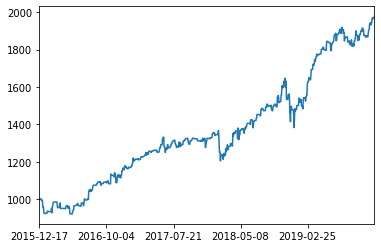

In [77]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 290us/step - loss: 2.0033 - accuracy: 0.1902
Epoch 2/300
3996/3996 [==============================] - 0s 113us/step - loss: 1.8645 - accuracy: 0.2365
Epoch 3/300
3996/3996 [==============================] - 0s 87us/step - loss: 1.8278 - accuracy: 0.2347
Epoch 4/300
3996/3996 [==============================] - 0s 86us/step - loss: 1.8015 - accuracy: 0.2535
Epoch 5/300
3996/3996 [==============================] - 0s 85us/step - loss: 1.7811 - accuracy: 0.2503
Epoch 6/300
3996/3996 [==============================] - 0s 85us/step - loss: 1.7711 - accuracy: 0.2705
Epoch 7/300
3996/3996 [==============================] - 0s 83us/step - loss: 1.7555 - accuracy: 0.2810
Epoch 8/300
3996/3996 [==============================] - 0s 82us/step - loss: 1.7412 - accuracy: 0.2840
Epoch 9/300
3996/3996 [==============================] - 0s 81us/step - loss: 1.7307 - accuracy: 0.2803
Epoch 10/300
3996/3996 [==============================] - 0s 8

3996/3996 [==============================] - 0s 85us/step - loss: 1.1316 - accuracy: 0.5038
Epoch 79/300
3996/3996 [==============================] - 0s 82us/step - loss: 1.1436 - accuracy: 0.5173
Epoch 80/300
3996/3996 [==============================] - 1s 168us/step - loss: 1.1065 - accuracy: 0.5228
Epoch 81/300
3996/3996 [==============================] - 1s 223us/step - loss: 1.1332 - accuracy: 0.51950s - l
Epoch 82/300
3996/3996 [==============================] - 1s 143us/step - loss: 1.1131 - accuracy: 0.5098
Epoch 83/300
3996/3996 [==============================] - 1s 130us/step - loss: 1.1072 - accuracy: 0.5275
Epoch 84/300
3996/3996 [==============================] - 1s 226us/step - loss: 1.0924 - accuracy: 0.5323
Epoch 85/300
3996/3996 [==============================] - 1s 173us/step - loss: 1.1066 - accuracy: 0.5205
Epoch 86/300
3996/3996 [==============================] - 1s 143us/step - loss: 1.1062 - accuracy: 0.5258
Epoch 87/300
3996/3996 [==============================]

3996/3996 [==============================] - 0s 81us/step - loss: 0.9659 - accuracy: 0.5771
Epoch 156/300
3996/3996 [==============================] - 0s 87us/step - loss: 0.9708 - accuracy: 0.5788
Epoch 157/300
3996/3996 [==============================] - 0s 115us/step - loss: 0.9717 - accuracy: 0.5838
Epoch 158/300
3996/3996 [==============================] - 1s 135us/step - loss: 0.9643 - accuracy: 0.5768
Epoch 159/300
3996/3996 [==============================] - 0s 85us/step - loss: 0.9572 - accuracy: 0.5878
Epoch 160/300
3996/3996 [==============================] - 0s 104us/step - loss: 0.9646 - accuracy: 0.5813
Epoch 161/300
3996/3996 [==============================] - 0s 102us/step - loss: 1.0039 - accuracy: 0.5618
Epoch 162/300
3996/3996 [==============================] - 0s 94us/step - loss: 0.9558 - accuracy: 0.5908
Epoch 163/300
3996/3996 [==============================] - 0s 87us/step - loss: 0.9420 - accuracy: 0.5971
Epoch 164/300
3996/3996 [==============================]

3996/3996 [==============================] - 0s 89us/step - loss: 0.9236 - accuracy: 0.5931
Epoch 233/300
3996/3996 [==============================] - 0s 93us/step - loss: 0.8938 - accuracy: 0.6044
Epoch 234/300
3996/3996 [==============================] - 0s 93us/step - loss: 0.9225 - accuracy: 0.5991
Epoch 235/300
3996/3996 [==============================] - 0s 87us/step - loss: 0.9184 - accuracy: 0.6014
Epoch 236/300
3996/3996 [==============================] - 0s 85us/step - loss: 0.9299 - accuracy: 0.5868
Epoch 237/300
3996/3996 [==============================] - 1s 142us/step - loss: 0.8855 - accuracy: 0.5961
Epoch 238/300
3996/3996 [==============================] - 1s 148us/step - loss: 0.9426 - accuracy: 0.5976
Epoch 239/300
3996/3996 [==============================] - 1s 133us/step - loss: 0.9080 - accuracy: 0.5983
Epoch 240/300
3996/3996 [==============================] - 1s 151us/step - loss: 0.9106 - accuracy: 0.5976
Epoch 241/300
3996/3996 [==============================]

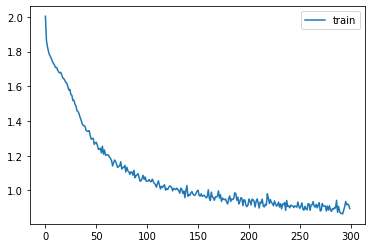

In [78]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.72826   0.77011   0.74860        87
          B2    0.67105   0.40476   0.50495       126
          B1    0.53191   0.20325   0.29412       123
          B0    0.85333   0.75294   0.80000       170
          S0    0.77011   0.83750   0.80240       160
          S1    0.66667   0.36800   0.47423       125
          S2    0.77215   0.44526   0.56481       137
          S3    0.76271   0.62500   0.68702        72

   micro avg    0.74665   0.55700   0.63803      1000
   macro avg    0.71953   0.55085   0.60952      1000
weighted avg    0.72566   0.55700   0.61544      1000
 samples avg    0.55700   0.55700   0.55700      1000

Confusion matrix, without normalization
[[ 75  12   0   0   0   0   0   0]
 [ 65  51   7   2   1   0   0   0]
 [ 76  12  25   9   1   0   0   0]
 [ 20   1  15 128   6   0   0   0]
 [ 12   0   0  10 134   4   0   0]
 [ 45   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


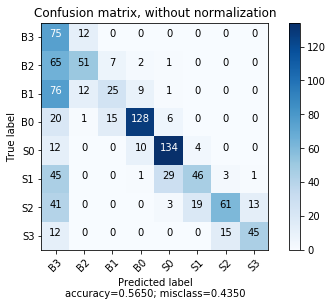

[5, 5, 1, 2, 5, 2, 3, 2, 1, 3, 3, 3, 1, 2, 4, 4, 4, 5, 4, 1, 4, 4, 3, 3, 6, 5, 4, 4, 6, 6, 4, 3, 4, 6, 4, 0, 0, 1, 6, 1, 3, 4, 5, 3, 3, 5, 6, 2, 4, 5, 7, 4, 3, 0, 3, 4, 6, 5, 5, 4, 6, 3, 4, 5, 6, 7, 7, 5, 1, 3, 5, 6, 7, 4, 3, 3, 7, 2, 3, 7, 1, 1, 4, 0, 1, 6, 3, 2, 4, 3, 1, 6, 4, 4, 3, 4, 3, 7, 1, 3, 0, 6, 0, 6, 7, 3, 4, 4, 6, 6, 5, 3, 1, 0, 1, 4, 5, 2, 3, 5, 4, 5, 3, 3, 3, 4, 4, 3, 2, 5, 1, 2, 2, 0, 4, 1, 4, 2, 4, 3, 5, 6, 2, 5, 1, 4, 1, 3, 2, 1, 0, 7, 2, 2, 3, 2, 6, 4, 1, 2, 3, 3, 3, 1, 1, 4, 7, 2, 3, 1, 1, 5, 3, 0, 1, 5, 3, 6, 3, 4, 2, 1, 1, 6, 0, 1, 5, 6, 6, 3, 5, 2, 6, 4, 5, 4, 3, 7, 7, 5, 4, 4, 4, 2, 4, 2, 6, 6, 6, 4, 1, 0, 1, 1, 6, 0, 5, 4, 1, 6, 3, 3, 4, 4, 7, 5, 7, 4, 6, 2, 4, 0, 3, 3, 1, 4, 3, 4, 3, 3, 0, 5, 4, 3, 4, 2, 4, 3, 2, 5, 3, 1, 2, 1, 3, 3, 4, 4, 5, 1, 1, 1, 4, 4, 6, 2, 5, 0, 4, 6, 6, 5, 3, 1, 7, 5, 0, 5, 1, 2, 1, 5, 2, 3, 3, 1, 5, 0, 5, 4, 4, 6, 4, 3, 2, 3, 7, 0, 3, 7, 1, 0, 5, 4, 4, 6, 1, 3, 6, 7, 1, 2, 3, 1, 4, 1, 0, 5, 0, 1, 3, 3, 4, 4, 1, 3, 6, 3, 4, 4, 4, 1, 6, 

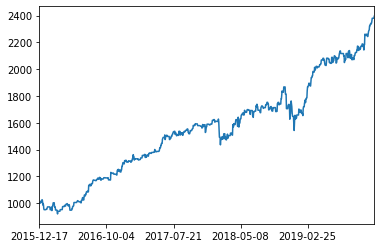

In [79]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 232us/step - loss: 1.9928 - accuracy: 0.2050
Epoch 2/300
3996/3996 [==============================] - 0s 102us/step - loss: 1.8348 - accuracy: 0.2420
Epoch 3/300
3996/3996 [==============================] - 0s 97us/step - loss: 1.7995 - accuracy: 0.2555
Epoch 4/300
3996/3996 [==============================] - 0s 95us/step - loss: 1.7687 - accuracy: 0.2743
Epoch 5/300
3996/3996 [==============================] - 0s 89us/step - loss: 1.7549 - accuracy: 0.2813
Epoch 6/300
3996/3996 [==============================] - 0s 93us/step - loss: 1.7289 - accuracy: 0.2820
Epoch 7/300
3996/3996 [==============================] - 0s 89us/step - loss: 1.7167 - accuracy: 0.2928
Epoch 8/300
3996/3996 [==============================] - 0s 89us/step - loss: 1.7070 - accuracy: 0.2880
Epoch 9/300
3996/3996 [==============================] - 0s 90us/step - loss: 1.6889 - accuracy: 0.3043
Epoch 10/300
3996/3996 [==============================] - 0s 8

3996/3996 [==============================] - 0s 109us/step - loss: 1.2721 - accuracy: 0.4555
Epoch 79/300
3996/3996 [==============================] - 0s 96us/step - loss: 1.2617 - accuracy: 0.4675
Epoch 80/300
3996/3996 [==============================] - 0s 97us/step - loss: 1.2624 - accuracy: 0.4697
Epoch 81/300
3996/3996 [==============================] - 0s 94us/step - loss: 1.2460 - accuracy: 0.4697
Epoch 82/300
3996/3996 [==============================] - 0s 116us/step - loss: 1.2511 - accuracy: 0.4705
Epoch 83/300
3996/3996 [==============================] - 1s 186us/step - loss: 1.2649 - accuracy: 0.4562
Epoch 84/300
3996/3996 [==============================] - 1s 186us/step - loss: 1.2392 - accuracy: 0.4630
Epoch 85/300
3996/3996 [==============================] - 1s 147us/step - loss: 1.2459 - accuracy: 0.4645
Epoch 86/300
3996/3996 [==============================] - 1s 132us/step - loss: 1.2331 - accuracy: 0.4757
Epoch 87/300
3996/3996 [==============================] - 1s 1

3996/3996 [==============================] - 0s 113us/step - loss: 1.0481 - accuracy: 0.5495
Epoch 154/300
3996/3996 [==============================] - 0s 112us/step - loss: 1.0502 - accuracy: 0.5413
Epoch 155/300
3996/3996 [==============================] - 1s 149us/step - loss: 1.0534 - accuracy: 0.55531s - loss: 1.0702 - 
Epoch 156/300
3996/3996 [==============================] - 1s 161us/step - loss: 1.0544 - accuracy: 0.5443
Epoch 157/300
3996/3996 [==============================] - 0s 111us/step - loss: 1.0277 - accuracy: 0.5558
Epoch 158/300
3996/3996 [==============================] - 1s 161us/step - loss: 1.0374 - accuracy: 0.5498
Epoch 159/300
3996/3996 [==============================] - 0s 120us/step - loss: 1.0465 - accuracy: 0.5521
Epoch 160/300
3996/3996 [==============================] - 0s 94us/step - loss: 1.0441 - accuracy: 0.5548
Epoch 161/300
3996/3996 [==============================] - 0s 97us/step - loss: 1.0017 - accuracy: 0.5611
Epoch 162/300
3996/3996 [========

3996/3996 [==============================] - 0s 108us/step - loss: 0.9572 - accuracy: 0.5958
Epoch 230/300
3996/3996 [==============================] - 0s 100us/step - loss: 0.9589 - accuracy: 0.5833
Epoch 231/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.9806 - accuracy: 0.5881
Epoch 232/300
3996/3996 [==============================] - 0s 91us/step - loss: 0.9356 - accuracy: 0.5908
Epoch 233/300
3996/3996 [==============================] - 0s 98us/step - loss: 0.9507 - accuracy: 0.5833
Epoch 234/300
3996/3996 [==============================] - 0s 96us/step - loss: 0.9328 - accuracy: 0.6046
Epoch 235/300
3996/3996 [==============================] - 0s 105us/step - loss: 0.9667 - accuracy: 0.5891
Epoch 236/300
3996/3996 [==============================] - 0s 101us/step - loss: 0.9516 - accuracy: 0.5868
Epoch 237/300
3996/3996 [==============================] - 0s 90us/step - loss: 0.9498 - accuracy: 0.5953
Epoch 238/300
3996/3996 [==============================]

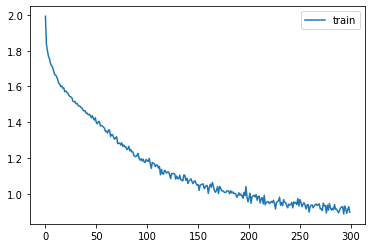

In [80]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.66292   0.67816   0.67045        87
          B2    0.51020   0.19841   0.28571       126
          B1    0.50667   0.30894   0.38384       123
          B0    0.74359   0.68235   0.71166       170
          S0    0.65244   0.66875   0.66049       160
          S1    0.60526   0.18400   0.28221       125
          S2    0.70707   0.51095   0.59322       137
          S3    0.71429   0.62500   0.66667        72

   micro avg    0.65894   0.48300   0.55741      1000
   macro avg    0.63781   0.48207   0.53178      1000
weighted avg    0.63904   0.48300   0.53275      1000
 samples avg    0.48300   0.48300   0.48300      1000

Confusion matrix, without normalization
[[ 72  13   2   0   0   0   0   0]
 [ 74  25  19   6   2   0   0   0]
 [ 58   8  38  18   1   0   0   0]
 [ 24   3  16 116  11   0   0   0]
 [ 34   0   0  14 107   3   2   0]
 [ 43   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


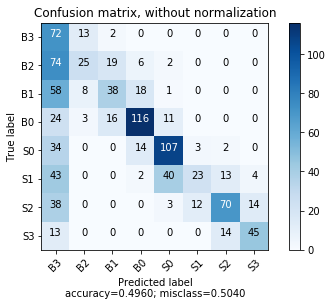

[5, 5, 1, 2, 6, 2, 4, 2, 2, 3, 3, 2, 1, 2, 4, 4, 4, 4, 5, 1, 4, 5, 3, 3, 6, 5, 4, 4, 6, 6, 4, 3, 4, 6, 3, 0, 1, 1, 6, 1, 3, 4, 5, 3, 3, 6, 6, 3, 4, 4, 7, 4, 3, 0, 4, 4, 7, 5, 6, 5, 6, 3, 3, 6, 6, 7, 7, 6, 3, 3, 5, 5, 7, 4, 3, 3, 7, 1, 2, 7, 2, 0, 4, 0, 2, 6, 3, 1, 4, 3, 2, 6, 4, 4, 3, 4, 4, 7, 2, 3, 0, 6, 0, 6, 7, 3, 4, 4, 6, 6, 5, 3, 2, 0, 1, 4, 7, 3, 3, 6, 4, 5, 2, 3, 3, 4, 4, 3, 2, 5, 1, 2, 0, 0, 4, 2, 4, 3, 4, 3, 5, 6, 2, 5, 2, 4, 2, 3, 2, 2, 0, 7, 2, 3, 3, 2, 6, 5, 1, 2, 3, 3, 3, 2, 2, 4, 6, 4, 3, 1, 2, 7, 3, 1, 1, 5, 3, 5, 3, 4, 3, 0, 1, 4, 0, 0, 5, 6, 6, 1, 4, 2, 6, 4, 6, 3, 3, 7, 7, 4, 4, 4, 4, 2, 4, 2, 6, 6, 6, 4, 1, 0, 1, 0, 6, 0, 6, 5, 1, 5, 3, 3, 4, 4, 7, 6, 7, 4, 6, 3, 4, 1, 3, 3, 1, 4, 3, 4, 3, 3, 0, 5, 4, 3, 5, 2, 4, 4, 2, 6, 3, 1, 3, 1, 3, 3, 4, 4, 4, 1, 1, 2, 4, 4, 5, 2, 6, 1, 4, 6, 5, 4, 3, 0, 7, 6, 0, 6, 0, 2, 1, 4, 2, 3, 3, 0, 5, 0, 5, 4, 4, 6, 5, 3, 1, 3, 7, 0, 3, 7, 1, 0, 6, 4, 4, 6, 1, 3, 6, 7, 2, 2, 3, 1, 4, 2, 0, 5, 0, 0, 2, 3, 3, 4, 3, 3, 5, 3, 4, 4, 4, 2, 6, 

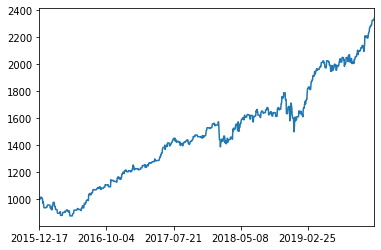

In [81]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 221us/step - loss: 3.7595 - accuracy: 0.1424
Epoch 2/300
3996/3996 [==============================] - 0s 94us/step - loss: 2.0806 - accuracy: 0.1674
Epoch 3/300
3996/3996 [==============================] - 0s 89us/step - loss: 2.0613 - accuracy: 0.1714
Epoch 4/300
3996/3996 [==============================] - 0s 99us/step - loss: 2.0538 - accuracy: 0.1737
Epoch 5/300
3996/3996 [==============================] - 0s 102us/step - loss: 2.0499 - accuracy: 0.1772
Epoch 6/300
3996/3996 [==============================] - 1s 171us/step - loss: 2.0550 - accuracy: 0.1749
Epoch 7/300
3996/3996 [==============================] - 1s 144us/step - loss: 2.0437 - accuracy: 0.1762
Epoch 8/300
3996/3996 [==============================] - 1s 148us/step - loss: 2.0278 - accuracy: 0.1892
Epoch 9/300
3996/3996 [==============================] - 1s 136us/step - loss: 2.0243 - accuracy: 0.1924
Epoch 10/300
3996/3996 [==============================] - 

3996/3996 [==============================] - 0s 100us/step - loss: 1.6488 - accuracy: 0.3276
Epoch 79/300
3996/3996 [==============================] - 1s 210us/step - loss: 1.6612 - accuracy: 0.32160s - loss:
Epoch 80/300
3996/3996 [==============================] - 1s 190us/step - loss: 1.6401 - accuracy: 0.3253
Epoch 81/300
3996/3996 [==============================] - 1s 210us/step - loss: 1.6269 - accuracy: 0.3288
Epoch 82/300
3996/3996 [==============================] - 0s 125us/step - loss: 1.6314 - accuracy: 0.3278
Epoch 83/300
3996/3996 [==============================] - 1s 181us/step - loss: 1.6275 - accuracy: 0.3373
Epoch 84/300
3996/3996 [==============================] - 1s 180us/step - loss: 1.6297 - accuracy: 0.3298
Epoch 85/300
3996/3996 [==============================] - 0s 104us/step - loss: 1.6269 - accuracy: 0.3263
Epoch 86/300
3996/3996 [==============================] - 1s 148us/step - loss: 1.6151 - accuracy: 0.3408
Epoch 87/300
3996/3996 [=========================

3996/3996 [==============================] - 1s 199us/step - loss: 1.5284 - accuracy: 0.36410s - loss: 1.5210 - accu
Epoch 154/300
3996/3996 [==============================] - 1s 194us/step - loss: 1.5143 - accuracy: 0.3741
Epoch 155/300
3996/3996 [==============================] - 1s 157us/step - loss: 1.5301 - accuracy: 0.3734
Epoch 156/300
3996/3996 [==============================] - 1s 134us/step - loss: 1.5215 - accuracy: 0.37110s - loss: 1.5236 - accuracy: 0.
Epoch 157/300
3996/3996 [==============================] - 1s 184us/step - loss: 1.5576 - accuracy: 0.3619
Epoch 158/300
3996/3996 [==============================] - 1s 147us/step - loss: 1.5447 - accuracy: 0.3711
Epoch 159/300
3996/3996 [==============================] - 1s 140us/step - loss: 1.5202 - accuracy: 0.37260s - loss: 1.5243 - accuracy: 0.
Epoch 160/300
3996/3996 [==============================] - 1s 200us/step - loss: 1.5211 - accuracy: 0.3689
Epoch 161/300
3996/3996 [==============================] - 1s 271us/st

3996/3996 [==============================] - 1s 363us/step - loss: 1.4534 - accuracy: 0.4017
Epoch 230/300
3996/3996 [==============================] - 2s 416us/step - loss: 1.4778 - accuracy: 0.39941s - loss: 1.4895 - accu - ETA: 0s - loss: 1.4824 - accuracy: 
Epoch 231/300
3996/3996 [==============================] - 0s 111us/step - loss: 1.4871 - accuracy: 0.3839
Epoch 232/300
3996/3996 [==============================] - ETA: 0s - loss: 1.4824 - accuracy: 0.38 - 1s 128us/step - loss: 1.4786 - accuracy: 0.3849
Epoch 233/300
3996/3996 [==============================] - 1s 167us/step - loss: 1.4677 - accuracy: 0.3906
Epoch 234/300
3996/3996 [==============================] - 1s 167us/step - loss: 1.4798 - accuracy: 0.3919
Epoch 235/300
3996/3996 [==============================] - 1s 172us/step - loss: 1.4569 - accuracy: 0.3989
Epoch 236/300
3996/3996 [==============================] - 1s 130us/step - loss: 1.4891 - accuracy: 0.3824
Epoch 237/300
3996/3996 [=============================

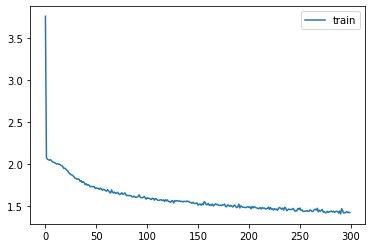

In [82]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 11
              precision    recall  f1-score   support

          B3    0.72727   0.27586   0.40000        87
          B2    0.54545   0.04762   0.08759       126
          B1    0.00000   0.00000   0.00000       123
          B0    0.30000   0.01765   0.03333       170
          S0    0.00000   0.00000   0.00000       160
          S1    0.16667   0.00800   0.01527       125
          S2    0.23529   0.02920   0.05195       137
          S3    0.50000   0.26389   0.34545        72

   micro avg    0.47107   0.05700   0.10169      1000
   macro avg    0.30934   0.08028   0.11670      1000
weighted avg    0.27207   0.05700   0.08540      1000
 samples avg    0.05700   0.05700   0.05700      1000

Confusion matrix, without normalization
[[ 86   0   0   0   1   0   0   0]
 [114   6   0   2   1   0   0   3]
 [113   5   0   1   1   2   1   0]
 [165   0   1   3   1   0   0   0]
 [150   0   0   1   0   3   3   3]
 [114   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


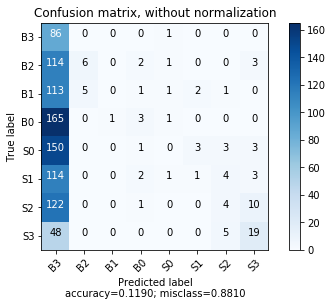

[5, 6, 3, 3, 4, 3, 6, 2, 2, 4, 3, 4, 3, 4, 4, 6, 5, 4, 6, 1, 4, 3, 4, 4, 5, 6, 3, 4, 4, 4, 4, 4, 4, 4, 3, 0, 3, 3, 6, 3, 2, 4, 6, 2, 6, 6, 5, 5, 3, 6, 6, 4, 5, 1, 6, 4, 3, 6, 6, 4, 6, 3, 3, 4, 6, 7, 7, 4, 7, 4, 6, 6, 6, 4, 4, 4, 6, 1, 1, 6, 4, 2, 7, 1, 3, 6, 6, 1, 6, 3, 3, 6, 5, 7, 2, 5, 6, 7, 2, 4, 0, 4, 1, 6, 6, 3, 4, 3, 6, 6, 4, 1, 5, 1, 3, 4, 6, 4, 3, 5, 6, 4, 1, 4, 4, 3, 5, 4, 3, 5, 1, 4, 0, 3, 6, 3, 3, 4, 3, 5, 4, 6, 3, 4, 1, 6, 3, 3, 4, 3, 1, 7, 3, 3, 3, 2, 7, 6, 3, 3, 4, 3, 1, 3, 3, 5, 7, 0, 3, 1, 5, 7, 1, 2, 4, 6, 3, 6, 5, 0, 3, 1, 3, 7, 0, 1, 5, 4, 5, 3, 4, 4, 7, 4, 3, 4, 4, 7, 7, 3, 4, 1, 4, 5, 4, 1, 6, 7, 4, 3, 0, 7, 3, 0, 4, 1, 6, 4, 3, 5, 2, 3, 3, 3, 7, 3, 7, 2, 6, 3, 4, 3, 4, 6, 3, 4, 2, 3, 0, 1, 1, 3, 4, 2, 4, 3, 6, 5, 2, 6, 3, 3, 3, 2, 5, 3, 4, 7, 3, 0, 0, 4, 4, 4, 6, 3, 4, 2, 6, 6, 4, 4, 4, 0, 7, 6, 1, 6, 1, 3, 3, 7, 5, 0, 4, 3, 4, 0, 6, 4, 6, 6, 3, 4, 1, 4, 6, 1, 4, 4, 1, 1, 4, 4, 3, 6, 1, 4, 6, 6, 6, 3, 3, 3, 5, 7, 1, 4, 1, 1, 3, 3, 6, 3, 2, 3, 6, 5, 5, 6, 4, 3, 4, 

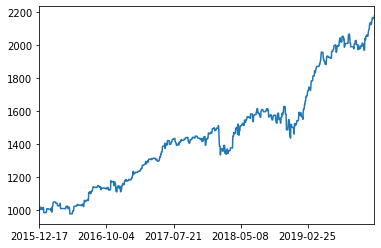

In [83]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 207us/step - loss: 2.0167 - accuracy: 0.1771
Epoch 2/300
3992/3992 [==============================] - 0s 105us/step - loss: 1.8823 - accuracy: 0.2252
Epoch 3/300
3992/3992 [==============================] - 0s 88us/step - loss: 1.8359 - accuracy: 0.2472
Epoch 4/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.8141 - accuracy: 0.2543
Epoch 5/300
3992/3992 [==============================] - 0s 100us/step - loss: 1.7958 - accuracy: 0.2635
Epoch 6/300
3992/3992 [==============================] - 0s 123us/step - loss: 1.7971 - accuracy: 0.2550
Epoch 7/300
3992/3992 [==============================] - 0s 83us/step - loss: 1.7906 - accuracy: 0.2756
Epoch 8/300
3992/3992 [==============================] - 0s 96us/step - loss: 1.7681 - accuracy: 0.2778
Epoch 9/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.7704 - accuracy: 0.2768
Epoch 10/300
3992/3992 [==============================] - 0s

3992/3992 [==============================] - 0s 104us/step - loss: 1.6097 - accuracy: 0.3414
Epoch 79/300
3992/3992 [==============================] - 0s 102us/step - loss: 1.6023 - accuracy: 0.3472
Epoch 80/300
3992/3992 [==============================] - 0s 93us/step - loss: 1.6001 - accuracy: 0.3414
Epoch 81/300
3992/3992 [==============================] - 0s 95us/step - loss: 1.6036 - accuracy: 0.3429
Epoch 82/300
3992/3992 [==============================] - 0s 92us/step - loss: 1.5971 - accuracy: 0.3469
Epoch 83/300
3992/3992 [==============================] - 0s 95us/step - loss: 1.5976 - accuracy: 0.3432
Epoch 84/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.5998 - accuracy: 0.3477
Epoch 85/300
3992/3992 [==============================] - 0s 101us/step - loss: 1.6015 - accuracy: 0.3402
Epoch 86/300
3992/3992 [==============================] - 0s 93us/step - loss: 1.5859 - accuracy: 0.3399
Epoch 87/300
3992/3992 [==============================] - 0s 103u

3992/3992 [==============================] - 0s 89us/step - loss: 1.5368 - accuracy: 0.3660
Epoch 156/300
3992/3992 [==============================] - 0s 114us/step - loss: 1.5325 - accuracy: 0.3742
Epoch 157/300
3992/3992 [==============================] - 0s 117us/step - loss: 1.5254 - accuracy: 0.3785
Epoch 158/300
3992/3992 [==============================] - 1s 147us/step - loss: 1.5230 - accuracy: 0.3773
Epoch 159/300
3992/3992 [==============================] - 1s 130us/step - loss: 1.5498 - accuracy: 0.3590
Epoch 160/300
3992/3992 [==============================] - 0s 110us/step - loss: 1.5332 - accuracy: 0.3753
Epoch 161/300
3992/3992 [==============================] - 0s 111us/step - loss: 1.5271 - accuracy: 0.3692
Epoch 162/300
3992/3992 [==============================] - 0s 93us/step - loss: 1.5263 - accuracy: 0.3715
Epoch 163/300
3992/3992 [==============================] - 1s 131us/step - loss: 1.5198 - accuracy: 0.3783
Epoch 164/300
3992/3992 [============================

3992/3992 [==============================] - 0s 107us/step - loss: 1.5157 - accuracy: 0.3750
Epoch 231/300
3992/3992 [==============================] - 0s 105us/step - loss: 1.5184 - accuracy: 0.3730
Epoch 232/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.5051 - accuracy: 0.3860
Epoch 233/300
3992/3992 [==============================] - 0s 92us/step - loss: 1.5067 - accuracy: 0.3818
Epoch 234/300
3992/3992 [==============================] - 0s 100us/step - loss: 1.5107 - accuracy: 0.3840
Epoch 235/300
3992/3992 [==============================] - 0s 98us/step - loss: 1.5010 - accuracy: 0.3730
Epoch 236/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.4997 - accuracy: 0.3993
Epoch 237/300
3992/3992 [==============================] - 0s 83us/step - loss: 1.5016 - accuracy: 0.3795
Epoch 238/300
3992/3992 [==============================] - 0s 80us/step - loss: 1.5039 - accuracy: 0.3768
Epoch 239/300
3992/3992 [==============================] 

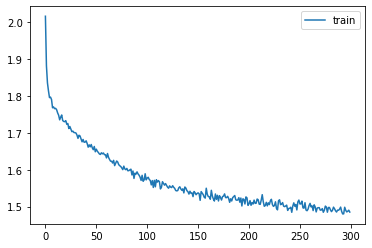

In [84]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.78947   0.30928   0.44444        97
          B2    0.00000   0.00000   0.00000       115
          B1    0.00000   0.00000   0.00000       107
          B0    0.00000   0.00000   0.00000       159
          S0    0.00000   0.00000   0.00000       171
          S1    0.00000   0.00000   0.00000       125
          S2    0.50000   0.00730   0.01439       137
          S3    0.64000   0.36364   0.46377        88

   micro avg    0.67021   0.06306   0.11528       999
   macro avg    0.24118   0.08503   0.11533       999
weighted avg    0.20160   0.06306   0.08598       999
 samples avg    0.06306   0.06306   0.06306       999

Confusion matrix, without normalization
[[ 97   0   0   0   0   0   0   0]
 [114   0   0   0   0   0   0   1]
 [105   1   0   0   0   0   0   1]
 [158   0   0   0   0   0   0   1]
 [168   0   0   2   0   0   0   1]
 [122   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


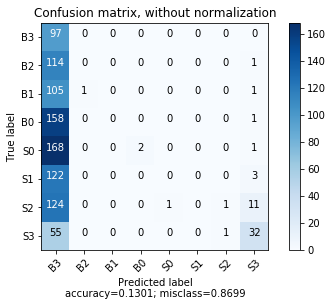

[3, 1, 3, 7, 3, 6, 4, 3, 5, 2, 6, 5, 4, 5, 0, 6, 4, 5, 0, 3, 4, 4, 7, 1, 3, 3, 0, 4, 5, 4, 1, 4, 1, 2, 1, 2, 3, 3, 2, 0, 3, 6, 5, 0, 7, 7, 4, 3, 4, 4, 3, 6, 3, 1, 1, 7, 1, 6, 1, 1, 1, 6, 3, 0, 4, 0, 4, 4, 3, 3, 4, 3, 6, 3, 4, 3, 4, 6, 3, 5, 2, 3, 4, 3, 6, 0, 3, 4, 6, 3, 3, 4, 4, 4, 3, 6, 3, 4, 2, 0, 4, 4, 6, 7, 5, 1, 7, 3, 1, 3, 3, 1, 6, 4, 3, 6, 5, 4, 4, 6, 6, 6, 3, 3, 0, 6, 5, 3, 0, 4, 6, 6, 3, 3, 4, 6, 0, 4, 6, 4, 4, 3, 1, 1, 3, 5, 7, 1, 6, 6, 1, 4, 5, 2, 0, 0, 2, 7, 6, 4, 4, 6, 3, 1, 3, 4, 6, 4, 0, 2, 3, 1, 4, 0, 3, 6, 4, 1, 2, 4, 4, 5, 4, 6, 1, 4, 2, 6, 4, 3, 0, 3, 5, 3, 4, 4, 7, 7, 2, 3, 4, 0, 4, 1, 1, 4, 0, 1, 0, 7, 4, 1, 1, 5, 6, 4, 7, 3, 4, 2, 1, 4, 1, 2, 7, 1, 6, 3, 7, 4, 1, 4, 7, 2, 4, 4, 3, 6, 5, 1, 5, 6, 1, 4, 1, 2, 1, 4, 6, 6, 3, 1, 3, 3, 0, 3, 4, 6, 1, 5, 6, 6, 1, 0, 6, 0, 4, 1, 1, 4, 6, 1, 5, 4, 1, 2, 4, 4, 2, 2, 4, 3, 4, 6, 0, 3, 5, 3, 7, 6, 1, 4, 4, 4, 1, 7, 6, 1, 7, 3, 6, 2, 1, 0, 6, 0, 4, 6, 7, 3, 4, 3, 6, 0, 4, 0, 1, 6, 1, 4, 6, 1, 4, 0, 2, 2, 3, 5, 6, 3, 4, 4, 3, 

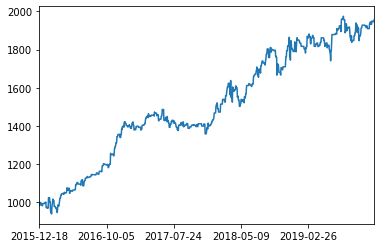

In [85]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 213us/step - loss: 2.0018 - accuracy: 0.1936
Epoch 2/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.8597 - accuracy: 0.2390
Epoch 3/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.8116 - accuracy: 0.2533
Epoch 4/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.7960 - accuracy: 0.2618
Epoch 5/300
3992/3992 [==============================] - 0s 93us/step - loss: 1.7763 - accuracy: 0.2668
Epoch 6/300
3992/3992 [==============================] - 0s 91us/step - loss: 1.7588 - accuracy: 0.2798
Epoch 7/300
3992/3992 [==============================] - 0s 90us/step - loss: 1.7501 - accuracy: 0.2833
Epoch 8/300
3992/3992 [==============================] - 0s 121us/step - loss: 1.7287 - accuracy: 0.2891
Epoch 9/300
3992/3992 [==============================] - 0s 121us/step - loss: 1.7282 - accuracy: 0.2881
Epoch 10/300
3992/3992 [==============================] - 1s 

Epoch 79/300
3992/3992 [==============================] - 0s 95us/step - loss: 1.2020 - accuracy: 0.4870
Epoch 80/300
3992/3992 [==============================] - 0s 88us/step - loss: 1.2075 - accuracy: 0.4782
Epoch 81/300
3992/3992 [==============================] - 0s 91us/step - loss: 1.1909 - accuracy: 0.4905
Epoch 82/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.1699 - accuracy: 0.4990
Epoch 83/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.1624 - accuracy: 0.5030
Epoch 84/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.1799 - accuracy: 0.4977
Epoch 85/300
3992/3992 [==============================] - 0s 95us/step - loss: 1.1615 - accuracy: 0.5058
Epoch 86/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.1763 - accuracy: 0.5045
Epoch 87/300
3992/3992 [==============================] - 0s 93us/step - loss: 1.1734 - accuracy: 0.5030
Epoch 88/300
3992/3992 [==============================]

3992/3992 [==============================] - 0s 90us/step - loss: 1.0582 - accuracy: 0.5356
Epoch 157/300
3992/3992 [==============================] - 0s 90us/step - loss: 1.0259 - accuracy: 0.5616
Epoch 158/300
3992/3992 [==============================] - 0s 97us/step - loss: 0.9896 - accuracy: 0.5762
Epoch 159/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.0071 - accuracy: 0.5666
Epoch 160/300
3992/3992 [==============================] - 0s 96us/step - loss: 1.0091 - accuracy: 0.5661
Epoch 161/300
3992/3992 [==============================] - 0s 88us/step - loss: 1.0533 - accuracy: 0.5493
Epoch 162/300
3992/3992 [==============================] - 0s 88us/step - loss: 1.0289 - accuracy: 0.5564
Epoch 163/300
3992/3992 [==============================] - 0s 92us/step - loss: 1.0119 - accuracy: 0.5634
Epoch 164/300
3992/3992 [==============================] - 0s 89us/step - loss: 0.9905 - accuracy: 0.5797
Epoch 165/300
3992/3992 [==============================] - 0

3992/3992 [==============================] - 0s 94us/step - loss: 0.9269 - accuracy: 0.6060
Epoch 234/300
3992/3992 [==============================] - 0s 93us/step - loss: 0.9610 - accuracy: 0.5859
Epoch 235/300
3992/3992 [==============================] - 0s 97us/step - loss: 0.9516 - accuracy: 0.5969
Epoch 236/300
3992/3992 [==============================] - 0s 91us/step - loss: 0.9429 - accuracy: 0.5899
Epoch 237/300
3992/3992 [==============================] - 0s 105us/step - loss: 0.9680 - accuracy: 0.5832
Epoch 238/300
3992/3992 [==============================] - 0s 96us/step - loss: 0.9410 - accuracy: 0.6032
Epoch 239/300
3992/3992 [==============================] - 0s 95us/step - loss: 0.9545 - accuracy: 0.5942
Epoch 240/300
3992/3992 [==============================] - 0s 92us/step - loss: 0.9696 - accuracy: 0.5894
Epoch 241/300
3992/3992 [==============================] - 0s 99us/step - loss: 0.9220 - accuracy: 0.6055
Epoch 242/300
3992/3992 [==============================] - 

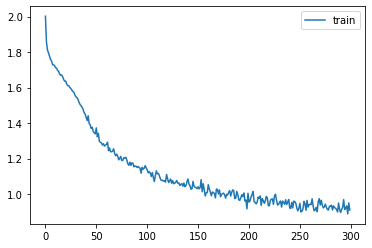

In [86]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.88732   0.64948   0.75000        97
          B2    0.64706   0.47826   0.55000       115
          B1    0.57143   0.18692   0.28169       107
          B0    0.76190   0.60377   0.67368       159
          S0    0.75926   0.71930   0.73874       171
          S1    0.61290   0.30400   0.40642       125
          S2    0.65333   0.35766   0.46226       137
          S3    0.86667   0.59091   0.70270        88

   micro avg    0.73373   0.49650   0.59224       999
   macro avg    0.71998   0.48629   0.57069       999
weighted avg    0.71570   0.49650   0.57613       999
 samples avg    0.49650   0.49650   0.49650       999

Confusion matrix, without normalization
[[ 79  18   0   0   0   0   0   0]
 [ 45  55  13   0   2   0   0   0]
 [ 52  12  20  23   0   0   0   0]
 [ 49   0   2  96  12   0   0   0]
 [ 39   0   0   7 123   2   0   0]
 [ 57   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


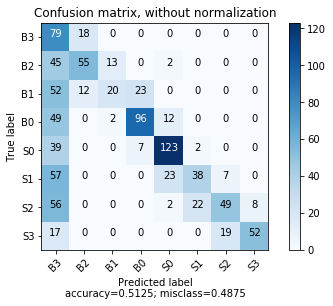

[1, 1, 4, 4, 2, 6, 3, 3, 5, 4, 5, 5, 3, 5, 0, 5, 4, 6, 1, 4, 3, 4, 5, 3, 4, 3, 2, 3, 5, 4, 1, 4, 4, 3, 3, 1, 4, 3, 3, 0, 3, 4, 4, 0, 7, 4, 3, 2, 5, 4, 3, 6, 4, 3, 3, 7, 3, 6, 1, 3, 2, 1, 4, 4, 5, 0, 5, 4, 3, 3, 4, 2, 6, 1, 4, 3, 4, 6, 3, 5, 1, 4, 4, 2, 6, 0, 3, 4, 6, 2, 3, 6, 4, 4, 1, 3, 4, 4, 4, 0, 4, 4, 6, 7, 5, 0, 7, 4, 1, 4, 4, 1, 6, 4, 4, 5, 6, 4, 2, 5, 5, 4, 4, 3, 0, 6, 6, 4, 1, 2, 4, 5, 3, 1, 5, 4, 1, 4, 4, 4, 2, 3, 1, 1, 3, 3, 7, 1, 5, 5, 1, 4, 5, 3, 0, 0, 2, 0, 5, 4, 7, 6, 4, 3, 1, 5, 7, 4, 1, 1, 3, 3, 3, 0, 1, 6, 4, 1, 0, 3, 4, 5, 6, 6, 2, 3, 3, 5, 3, 3, 0, 4, 4, 2, 3, 6, 7, 7, 3, 4, 4, 0, 5, 3, 3, 3, 0, 0, 0, 6, 3, 4, 1, 4, 6, 4, 7, 3, 4, 2, 1, 4, 0, 3, 7, 2, 6, 1, 7, 4, 3, 5, 6, 1, 4, 5, 3, 5, 6, 2, 3, 7, 1, 5, 1, 3, 1, 4, 5, 6, 2, 1, 3, 3, 0, 6, 4, 6, 0, 1, 6, 5, 1, 0, 6, 0, 4, 0, 2, 4, 6, 1, 4, 3, 1, 3, 4, 2, 3, 3, 1, 4, 4, 4, 1, 5, 6, 3, 7, 6, 0, 4, 4, 3, 3, 2, 7, 1, 6, 2, 6, 2, 0, 1, 7, 3, 4, 7, 7, 4, 1, 4, 6, 0, 3, 0, 1, 5, 5, 4, 5, 1, 4, 0, 2, 4, 3, 6, 5, 4, 3, 1, 5, 

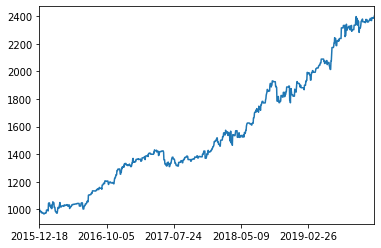

In [87]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 229us/step - loss: 2.0255 - accuracy: 0.1921
Epoch 2/300
3992/3992 [==============================] - 0s 119us/step - loss: 1.8504 - accuracy: 0.2422
Epoch 3/300
3992/3992 [==============================] - 0s 109us/step - loss: 1.8246 - accuracy: 0.2490
Epoch 4/300
3992/3992 [==============================] - 0s 107us/step - loss: 1.7876 - accuracy: 0.2633
Epoch 5/300
3992/3992 [==============================] - 0s 107us/step - loss: 1.7729 - accuracy: 0.2786
Epoch 6/300
3992/3992 [==============================] - 0s 107us/step - loss: 1.7467 - accuracy: 0.2816
Epoch 7/300
3992/3992 [==============================] - 0s 107us/step - loss: 1.7323 - accuracy: 0.2908
Epoch 8/300
3992/3992 [==============================] - 0s 102us/step - loss: 1.7153 - accuracy: 0.2948
Epoch 9/300
3992/3992 [==============================] - 0s 106us/step - loss: 1.7037 - accuracy: 0.3029
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 0s 111us/step - loss: 1.2707 - accuracy: 0.4767
Epoch 79/300
3992/3992 [==============================] - 0s 108us/step - loss: 1.2635 - accuracy: 0.4724
Epoch 80/300
3992/3992 [==============================] - 0s 110us/step - loss: 1.2459 - accuracy: 0.4847
Epoch 81/300
3992/3992 [==============================] - 0s 113us/step - loss: 1.2634 - accuracy: 0.4729
Epoch 82/300
3992/3992 [==============================] - 0s 107us/step - loss: 1.2326 - accuracy: 0.4895
Epoch 83/300
3992/3992 [==============================] - 0s 111us/step - loss: 1.2398 - accuracy: 0.4815
Epoch 84/300
3992/3992 [==============================] - 0s 109us/step - loss: 1.2224 - accuracy: 0.4987
Epoch 85/300
3992/3992 [==============================] - 0s 112us/step - loss: 1.2343 - accuracy: 0.4772
Epoch 86/300
3992/3992 [==============================] - 0s 108us/step - loss: 1.2278 - accuracy: 0.4792
Epoch 87/300
3992/3992 [==============================] - 0

3992/3992 [==============================] - 0s 118us/step - loss: 1.0681 - accuracy: 0.5601
Epoch 155/300
3992/3992 [==============================] - 0s 116us/step - loss: 1.0524 - accuracy: 0.5679
Epoch 156/300
3992/3992 [==============================] - 0s 114us/step - loss: 1.0599 - accuracy: 0.5596
Epoch 157/300
3992/3992 [==============================] - 0s 116us/step - loss: 1.0451 - accuracy: 0.5636
Epoch 158/300
3992/3992 [==============================] - 0s 112us/step - loss: 1.0290 - accuracy: 0.5726
Epoch 159/300
3992/3992 [==============================] - 0s 117us/step - loss: 1.0287 - accuracy: 0.5867
Epoch 160/300
3992/3992 [==============================] - 0s 116us/step - loss: 1.0548 - accuracy: 0.5676
Epoch 161/300
3992/3992 [==============================] - 0s 123us/step - loss: 1.0344 - accuracy: 0.5674
Epoch 162/300
3992/3992 [==============================] - 0s 110us/step - loss: 1.0320 - accuracy: 0.5772
Epoch 163/300
3992/3992 [==========================

3992/3992 [==============================] - 0s 124us/step - loss: 0.9166 - accuracy: 0.6247
Epoch 231/300
3992/3992 [==============================] - 0s 124us/step - loss: 0.9328 - accuracy: 0.6070
Epoch 232/300
3992/3992 [==============================] - 0s 114us/step - loss: 0.9431 - accuracy: 0.6090
Epoch 233/300
3992/3992 [==============================] - 0s 112us/step - loss: 0.9310 - accuracy: 0.6237
Epoch 234/300
3992/3992 [==============================] - 0s 113us/step - loss: 0.9363 - accuracy: 0.6160
Epoch 235/300
3992/3992 [==============================] - 0s 116us/step - loss: 0.9439 - accuracy: 0.6112
Epoch 236/300
3992/3992 [==============================] - 0s 114us/step - loss: 0.9332 - accuracy: 0.6155
Epoch 237/300
3992/3992 [==============================] - 0s 112us/step - loss: 0.9567 - accuracy: 0.6070
Epoch 238/300
3992/3992 [==============================] - 0s 113us/step - loss: 0.9446 - accuracy: 0.6132
Epoch 239/300
3992/3992 [==========================

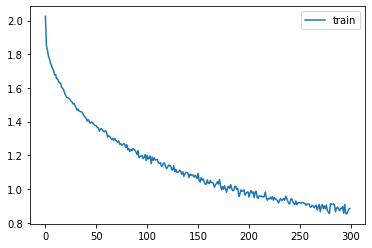

In [88]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.74390   0.62887   0.68156        97
          B2    0.54688   0.30435   0.39106       115
          B1    0.35294   0.16822   0.22785       107
          B0    0.47826   0.27673   0.35060       159
          S0    0.54430   0.25146   0.34400       171
          S1    0.25000   0.08800   0.13018       125
          S2    0.50617   0.29927   0.37615       137
          S3    0.62821   0.55682   0.59036        88

   micro avg    0.52890   0.30230   0.38471       999
   macro avg    0.50633   0.32171   0.38647       999
weighted avg    0.49831   0.30230   0.37016       999
 samples avg    0.30230   0.30230   0.30230       999

Confusion matrix, without normalization
[[82 13  1  1  0  0  0  0]
 [51 35 17  7  2  2  0  1]
 [67  9 18 11  2  0  0  0]
 [83  5 14 44  9  3  0  1]
 [86  1  1 24 43 11  5  0]
 [61  1  0  1 22 11 20  9]
 [58  0  0  3  1 16 4

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


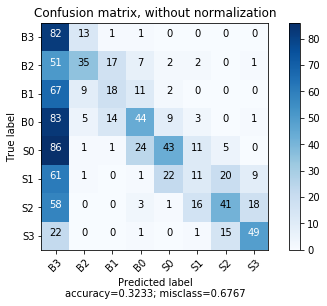

[1, 0, 3, 6, 2, 6, 4, 2, 5, 3, 6, 3, 3, 5, 2, 6, 4, 7, 0, 4, 4, 4, 4, 3, 4, 3, 1, 3, 7, 4, 0, 4, 4, 2, 3, 0, 5, 3, 3, 1, 3, 6, 3, 0, 4, 5, 3, 2, 5, 4, 3, 6, 6, 2, 0, 7, 3, 6, 1, 3, 2, 3, 3, 5, 5, 0, 5, 3, 2, 3, 5, 2, 6, 1, 3, 3, 4, 5, 2, 6, 1, 4, 4, 2, 6, 0, 3, 4, 5, 3, 3, 7, 4, 3, 1, 4, 7, 4, 3, 0, 3, 4, 6, 7, 6, 0, 7, 6, 3, 2, 4, 0, 5, 4, 2, 7, 7, 4, 2, 4, 6, 4, 3, 4, 1, 3, 5, 3, 0, 3, 6, 4, 1, 0, 6, 6, 2, 2, 5, 2, 2, 2, 2, 0, 3, 3, 7, 1, 6, 6, 3, 3, 5, 2, 0, 0, 2, 0, 6, 4, 7, 7, 6, 3, 2, 5, 7, 5, 0, 1, 3, 3, 2, 0, 0, 5, 6, 0, 0, 0, 5, 5, 7, 6, 1, 4, 3, 4, 3, 1, 1, 3, 3, 3, 4, 5, 7, 7, 2, 3, 6, 0, 4, 1, 0, 4, 0, 1, 0, 7, 3, 4, 0, 3, 5, 4, 7, 3, 3, 1, 0, 6, 0, 2, 7, 1, 6, 3, 7, 5, 0, 6, 6, 1, 5, 4, 3, 5, 7, 2, 4, 7, 1, 5, 1, 2, 2, 4, 6, 6, 2, 0, 2, 3, 1, 5, 3, 7, 0, 4, 6, 6, 2, 0, 6, 1, 3, 1, 3, 4, 6, 1, 4, 3, 0, 3, 4, 2, 5, 1, 4, 4, 3, 4, 1, 4, 7, 3, 6, 6, 0, 5, 4, 4, 2, 3, 7, 0, 6, 2, 5, 2, 1, 0, 7, 1, 4, 7, 7, 5, 2, 4, 6, 0, 3, 0, 2, 6, 4, 4, 5, 1, 4, 0, 2, 3, 3, 6, 6, 4, 4, 3, 5, 

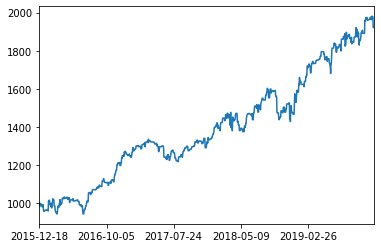

In [89]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 256us/step - loss: 5.0427 - accuracy: 0.1420
Epoch 2/300
3992/3992 [==============================] - 1s 128us/step - loss: 2.0611 - accuracy: 0.1743
Epoch 3/300
3992/3992 [==============================] - 1s 140us/step - loss: 2.0325 - accuracy: 0.1804
Epoch 4/300
3992/3992 [==============================] - 1s 136us/step - loss: 2.0095 - accuracy: 0.1896
Epoch 5/300
3992/3992 [==============================] - 1s 143us/step - loss: 2.0067 - accuracy: 0.2002
Epoch 6/300
3992/3992 [==============================] - 1s 135us/step - loss: 1.9972 - accuracy: 0.2044
Epoch 7/300
3992/3992 [==============================] - 1s 137us/step - loss: 1.9786 - accuracy: 0.2087
Epoch 8/300
3992/3992 [==============================] - 1s 166us/step - loss: 1.9524 - accuracy: 0.2139
Epoch 9/300
3992/3992 [==============================] - 1s 155us/step - loss: 1.9383 - accuracy: 0.2197
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 156us/step - loss: 1.6452 - accuracy: 0.3304
Epoch 79/300
3992/3992 [==============================] - 1s 178us/step - loss: 1.6190 - accuracy: 0.3447
Epoch 80/300
3992/3992 [==============================] - 1s 181us/step - loss: 1.6249 - accuracy: 0.3304
Epoch 81/300
3992/3992 [==============================] - 1s 195us/step - loss: 1.6398 - accuracy: 0.33970s - loss: 1.6403 - accu
Epoch 82/300
3992/3992 [==============================] - 1s 158us/step - loss: 1.6314 - accuracy: 0.3364
Epoch 83/300
3992/3992 [==============================] - 1s 149us/step - loss: 1.6100 - accuracy: 0.3399
Epoch 84/300
3992/3992 [==============================] - 1s 144us/step - loss: 1.6107 - accuracy: 0.3397
Epoch 85/300
3992/3992 [==============================] - 1s 139us/step - loss: 1.6074 - accuracy: 0.3454
Epoch 86/300
3992/3992 [==============================] - 1s 139us/step - loss: 1.5984 - accuracy: 0.3354
Epoch 87/300
3992/3992 [===========

Epoch 153/300
3992/3992 [==============================] - 1s 139us/step - loss: 1.5117 - accuracy: 0.3687
Epoch 154/300
3992/3992 [==============================] - 1s 136us/step - loss: 1.5071 - accuracy: 0.3835
Epoch 155/300
3992/3992 [==============================] - 1s 140us/step - loss: 1.5147 - accuracy: 0.3715
Epoch 156/300
3992/3992 [==============================] - 1s 133us/step - loss: 1.5504 - accuracy: 0.3717
Epoch 157/300
3992/3992 [==============================] - 1s 135us/step - loss: 1.5153 - accuracy: 0.3805
Epoch 158/300
3992/3992 [==============================] - 1s 137us/step - loss: 1.5086 - accuracy: 0.3717
Epoch 159/300
3992/3992 [==============================] - 1s 139us/step - loss: 1.5222 - accuracy: 0.3667
Epoch 160/300
3992/3992 [==============================] - 1s 134us/step - loss: 1.5445 - accuracy: 0.3685
Epoch 161/300
3992/3992 [==============================] - 1s 143us/step - loss: 1.5039 - accuracy: 0.3805
Epoch 162/300
3992/3992 [============

3992/3992 [==============================] - 1s 151us/step - loss: 1.4727 - accuracy: 0.3900
Epoch 230/300
3992/3992 [==============================] - 1s 159us/step - loss: 1.4453 - accuracy: 0.3998
Epoch 231/300
3992/3992 [==============================] - 1s 145us/step - loss: 1.4751 - accuracy: 0.3868
Epoch 232/300
3992/3992 [==============================] - 1s 159us/step - loss: 1.5076 - accuracy: 0.3825
Epoch 233/300
3992/3992 [==============================] - 1s 199us/step - loss: 1.4717 - accuracy: 0.3788
Epoch 234/300
3992/3992 [==============================] - 1s 180us/step - loss: 1.4676 - accuracy: 0.3940
Epoch 235/300
3992/3992 [==============================] - 1s 152us/step - loss: 1.4873 - accuracy: 0.3890
Epoch 236/300
3992/3992 [==============================] - 1s 157us/step - loss: 1.4696 - accuracy: 0.3923
Epoch 237/300
3992/3992 [==============================] - 1s 153us/step - loss: 1.4555 - accuracy: 0.3920
Epoch 238/300
3992/3992 [==========================

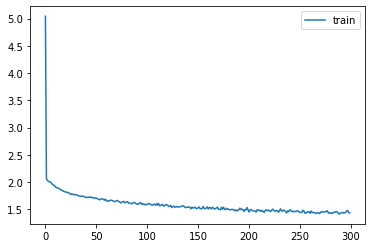

In [90]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 11
              precision    recall  f1-score   support

          B3    0.64912   0.38144   0.48052        97
          B2    0.50000   0.05217   0.09449       115
          B1    0.11111   0.01869   0.03200       107
          B0    0.25000   0.00629   0.01227       159
          S0    0.62500   0.02924   0.05587       171
          S1    0.00000   0.00000   0.00000       125
          S2    0.20000   0.01460   0.02721       137
          S3    0.57143   0.22727   0.32520        88

   micro avg    0.48993   0.07307   0.12718       999
   macro avg    0.36333   0.09121   0.12844       999
weighted avg    0.35702   0.07307   0.10486       999
 samples avg    0.07307   0.07307   0.07307       999

Confusion matrix, without normalization
[[ 93   1   1   0   0   1   0   1]
 [104   6   2   1   0   0   0   2]
 [103   1   2   0   0   0   1   0]
 [148   2   3   1   0   2   0   3]
 [161   0   2   1   5   1   0   1]
 [117  

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


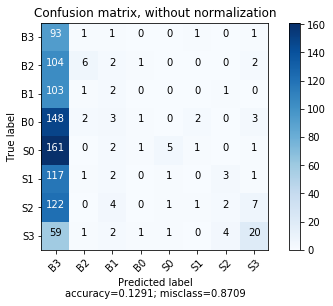

[1, 1, 2, 6, 3, 4, 4, 3, 4, 3, 4, 3, 4, 1, 0, 3, 4, 6, 0, 4, 1, 3, 3, 5, 3, 3, 3, 3, 6, 4, 0, 2, 4, 1, 3, 1, 6, 3, 1, 0, 6, 6, 2, 0, 3, 6, 3, 6, 4, 3, 3, 6, 3, 1, 1, 4, 1, 6, 3, 1, 3, 1, 3, 6, 4, 0, 4, 5, 3, 1, 4, 1, 4, 0, 4, 3, 3, 4, 3, 6, 3, 3, 4, 3, 4, 0, 1, 3, 6, 1, 5, 3, 2, 4, 3, 3, 6, 4, 1, 0, 3, 3, 6, 6, 2, 1, 6, 4, 1, 3, 3, 1, 4, 2, 3, 4, 6, 2, 3, 3, 4, 4, 1, 3, 1, 4, 4, 3, 0, 3, 6, 3, 1, 1, 4, 4, 2, 1, 6, 4, 3, 3, 6, 1, 5, 0, 6, 4, 3, 6, 0, 4, 4, 3, 1, 0, 2, 0, 6, 5, 6, 6, 3, 1, 1, 3, 4, 3, 2, 2, 4, 4, 3, 2, 1, 3, 4, 1, 3, 7, 2, 3, 4, 6, 0, 3, 3, 0, 3, 3, 0, 4, 4, 3, 3, 2, 7, 7, 1, 3, 3, 0, 3, 3, 0, 3, 0, 1, 0, 7, 5, 3, 2, 3, 6, 4, 6, 2, 4, 3, 1, 7, 1, 2, 6, 3, 4, 3, 6, 7, 1, 2, 6, 1, 3, 4, 3, 3, 6, 3, 4, 4, 1, 3, 3, 3, 1, 7, 6, 4, 3, 0, 3, 3, 0, 4, 3, 4, 1, 1, 6, 6, 1, 3, 4, 0, 3, 0, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 0, 1, 3, 0, 4, 6, 3, 7, 6, 3, 4, 3, 3, 3, 1, 6, 1, 6, 3, 4, 3, 0, 0, 6, 1, 3, 2, 6, 1, 3, 1, 7, 1, 3, 0, 1, 6, 1, 3, 4, 1, 3, 0, 3, 2, 2, 3, 6, 3, 3, 3, 3, 

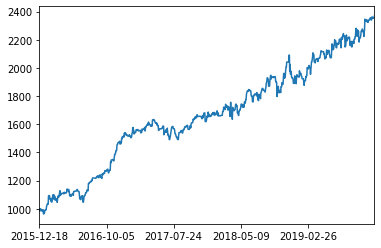

In [91]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 4s 984us/step - loss: 0.6481 - accuracy: 0.6209
Epoch 2/300
3999/3999 [==============================] - 1s 249us/step - loss: 0.6344 - accuracy: 0.6409
Epoch 3/300
3999/3999 [==============================] - 1s 245us/step - loss: 0.6299 - accuracy: 0.6412
Epoch 4/300
3999/3999 [==============================] - 1s 247us/step - loss: 0.6281 - accuracy: 0.6484
Epoch 5/300
3999/3999 [==============================] - 1s 225us/step - loss: 0.6237 - accuracy: 0.6497
Epoch 6/300
3999/3999 [==============================] - 1s 231us/step - loss: 0.6202 - accuracy: 0.6557
Epoch 7/300
3999/3999 [==============================] - 1s 234us/step - loss: 0.6182 - accuracy: 0.6592
Epoch 8/300
3999/3999 [==============================] - 1s 229us/step - loss: 0.6150 - accuracy: 0.6619
Epoch 9/300
3999/3999 [==============================] - 1s 226us/step - loss: 0.6110 - accuracy: 0.6684
Epoch 10/300
3999/3999 [==============================]

3999/3999 [==============================] - 1s 205us/step - loss: 0.5014 - accuracy: 0.7527
Epoch 79/300
3999/3999 [==============================] - 1s 195us/step - loss: 0.5013 - accuracy: 0.7559
Epoch 80/300
3999/3999 [==============================] - 1s 201us/step - loss: 0.5023 - accuracy: 0.7562
Epoch 81/300
3999/3999 [==============================] - 1s 207us/step - loss: 0.5020 - accuracy: 0.7544
Epoch 82/300
3999/3999 [==============================] - 1s 204us/step - loss: 0.5059 - accuracy: 0.7527
Epoch 83/300
3999/3999 [==============================] - 1s 200us/step - loss: 0.5014 - accuracy: 0.7597
Epoch 84/300
3999/3999 [==============================] - 1s 195us/step - loss: 0.4998 - accuracy: 0.7604
Epoch 85/300
3999/3999 [==============================] - 1s 200us/step - loss: 0.5042 - accuracy: 0.7567
Epoch 86/300
3999/3999 [==============================] - 1s 211us/step - loss: 0.5009 - accuracy: 0.7577
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 1s 205us/step - loss: 0.4995 - accuracy: 0.7557
Epoch 155/300
3999/3999 [==============================] - 1s 204us/step - loss: 0.5014 - accuracy: 0.7522
Epoch 156/300
3999/3999 [==============================] - 1s 202us/step - loss: 0.5003 - accuracy: 0.7604
Epoch 157/300
3999/3999 [==============================] - 1s 209us/step - loss: 0.5023 - accuracy: 0.7534
Epoch 158/300
3999/3999 [==============================] - 1s 199us/step - loss: 0.4982 - accuracy: 0.7574
Epoch 159/300
3999/3999 [==============================] - 1s 209us/step - loss: 0.4983 - accuracy: 0.7592
Epoch 160/300
3999/3999 [==============================] - 1s 211us/step - loss: 0.4998 - accuracy: 0.7537
Epoch 161/300
3999/3999 [==============================] - 1s 197us/step - loss: 0.5020 - accuracy: 0.7539
Epoch 162/300
3999/3999 [==============================] - 1s 203us/step - loss: 0.4979 - accuracy: 0.7607
Epoch 163/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 263us/step - loss: 0.5010 - accuracy: 0.7544
Epoch 230/300
3999/3999 [==============================] - 1s 290us/step - loss: 0.4966 - accuracy: 0.7599
Epoch 231/300
3999/3999 [==============================] - 1s 318us/step - loss: 0.4957 - accuracy: 0.7577
Epoch 232/300
3999/3999 [==============================] - 1s 321us/step - loss: 0.5003 - accuracy: 0.7569
Epoch 233/300
3999/3999 [==============================] - 1s 256us/step - loss: 0.4963 - accuracy: 0.7587
Epoch 234/300
3999/3999 [==============================] - 1s 212us/step - loss: 0.4967 - accuracy: 0.7597
Epoch 235/300
3999/3999 [==============================] - 1s 230us/step - loss: 0.4977 - accuracy: 0.7539
Epoch 236/300
3999/3999 [==============================] - 1s 226us/step - loss: 0.4978 - accuracy: 0.7624
Epoch 237/300
3999/3999 [==============================] - 1s 256us/step - loss: 0.4989 - accuracy: 0.7549
Epoch 238/300
3999/3999 [==========================

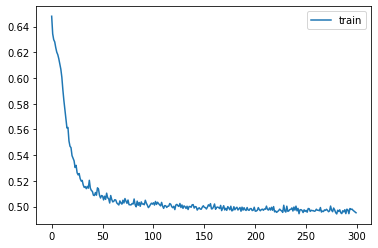

In [92]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

           S    0.70494   0.93950   0.80549       562
           B    0.86454   0.49543   0.62990       438

    accuracy                        0.74500      1000
   macro avg    0.78474   0.71747   0.71770      1000
weighted avg    0.77485   0.74500   0.72858      1000

Confusion matrix, without normalization
[[528  34]
 [221 217]]


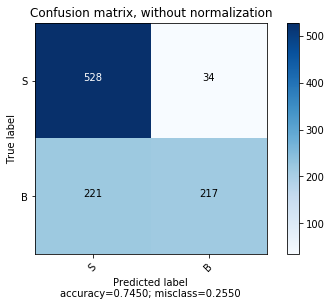

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 

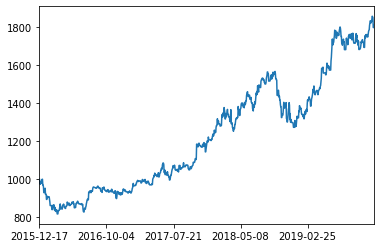

In [93]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 5s 1ms/step - loss: 0.6496 - accuracy: 0.6207
Epoch 2/300
3999/3999 [==============================] - 1s 231us/step - loss: 0.6338 - accuracy: 0.6394
Epoch 3/300
3999/3999 [==============================] - 1s 304us/step - loss: 0.6153 - accuracy: 0.6579
Epoch 4/300
3999/3999 [==============================] - 1s 285us/step - loss: 0.5738 - accuracy: 0.7074
Epoch 5/300
3999/3999 [==============================] - 1s 227us/step - loss: 0.5047 - accuracy: 0.7784
Epoch 6/300
3999/3999 [==============================] - 1s 272us/step - loss: 0.4357 - accuracy: 0.8197
Epoch 7/300
3999/3999 [==============================] - 1s 339us/step - loss: 0.3706 - accuracy: 0.8640
Epoch 8/300
3999/3999 [==============================] - 1s 264us/step - loss: 0.3394 - accuracy: 0.8700
Epoch 9/300
3999/3999 [==============================] - 1s 277us/step - loss: 0.3042 - accuracy: 0.8927
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 1s 321us/step - loss: 0.0727 - accuracy: 0.9787
Epoch 79/300
3999/3999 [==============================] - 1s 257us/step - loss: 0.0734 - accuracy: 0.9757
Epoch 80/300
3999/3999 [==============================] - 1s 265us/step - loss: 0.0669 - accuracy: 0.9817
Epoch 81/300
3999/3999 [==============================] - 1s 275us/step - loss: 0.0816 - accuracy: 0.9670
Epoch 82/300
3999/3999 [==============================] - 1s 360us/step - loss: 0.0834 - accuracy: 0.9690
Epoch 83/300
3999/3999 [==============================] - 1s 298us/step - loss: 0.0741 - accuracy: 0.9755
Epoch 84/300
3999/3999 [==============================] - 1s 323us/step - loss: 0.0767 - accuracy: 0.9700
Epoch 85/300
3999/3999 [==============================] - 1s 264us/step - loss: 0.0768 - accuracy: 0.9710
Epoch 86/300
3999/3999 [==============================] - 1s 284us/step - loss: 0.0718 - accuracy: 0.9740
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 1s 228us/step - loss: 0.0520 - accuracy: 0.9817
Epoch 155/300
3999/3999 [==============================] - 1s 303us/step - loss: 0.0795 - accuracy: 0.9670
Epoch 156/300
3999/3999 [==============================] - 1s 229us/step - loss: 0.0574 - accuracy: 0.9792
Epoch 157/300
3999/3999 [==============================] - 1s 233us/step - loss: 0.0532 - accuracy: 0.9827
Epoch 158/300
3999/3999 [==============================] - 1s 279us/step - loss: 0.0497 - accuracy: 0.9827
Epoch 159/300
3999/3999 [==============================] - 1s 348us/step - loss: 0.0551 - accuracy: 0.9770
Epoch 160/300
3999/3999 [==============================] - 1s 300us/step - loss: 0.0506 - accuracy: 0.9847
Epoch 161/300
3999/3999 [==============================] - 2s 376us/step - loss: 0.0489 - accuracy: 0.9845
Epoch 162/300
3999/3999 [==============================] - 1s 350us/step - loss: 0.0473 - accuracy: 0.9837
Epoch 163/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 323us/step - loss: 0.0531 - accuracy: 0.9762
Epoch 231/300
3999/3999 [==============================] - 1s 330us/step - loss: 0.0402 - accuracy: 0.9872
Epoch 232/300
3999/3999 [==============================] - 1s 347us/step - loss: 0.0503 - accuracy: 0.9802
Epoch 233/300
3999/3999 [==============================] - 1s 281us/step - loss: 0.0438 - accuracy: 0.9840
Epoch 234/300
3999/3999 [==============================] - 1s 227us/step - loss: 0.0555 - accuracy: 0.9782
Epoch 235/300
3999/3999 [==============================] - 1s 228us/step - loss: 0.0539 - accuracy: 0.9785
Epoch 236/300
3999/3999 [==============================] - 1s 227us/step - loss: 0.0546 - accuracy: 0.9782
Epoch 237/300
3999/3999 [==============================] - 1s 221us/step - loss: 0.0491 - accuracy: 0.9810
Epoch 238/300
3999/3999 [==============================] - 1s 248us/step - loss: 0.0416 - accuracy: 0.9857
Epoch 239/300
3999/3999 [==========================

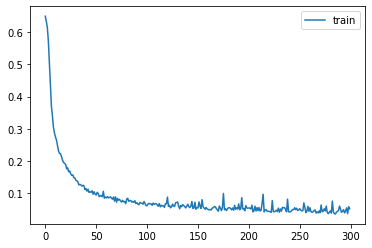

In [94]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

           S    1.00000   0.93060   0.96406       562
           B    0.91824   1.00000   0.95738       438

    accuracy                        0.96100      1000
   macro avg    0.95912   0.96530   0.96072      1000
weighted avg    0.96419   0.96100   0.96113      1000

Confusion matrix, without normalization
[[523  39]
 [  0 438]]


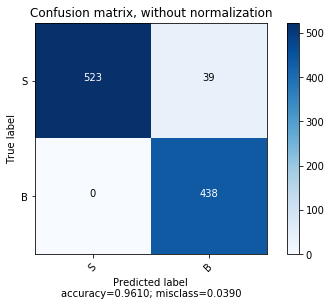

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 

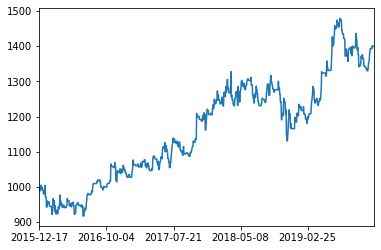

In [95]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 5s 1ms/step - loss: 0.5707 - accuracy: 0.7077
Epoch 2/300
3999/3999 [==============================] - 1s 246us/step - loss: 0.4766 - accuracy: 0.7849
Epoch 3/300
3999/3999 [==============================] - 1s 238us/step - loss: 0.4465 - accuracy: 0.8047
Epoch 4/300
3999/3999 [==============================] - 1s 336us/step - loss: 0.4264 - accuracy: 0.8142
Epoch 5/300
3999/3999 [==============================] - 1s 270us/step - loss: 0.4140 - accuracy: 0.8132
Epoch 6/300
3999/3999 [==============================] - 1s 328us/step - loss: 0.3923 - accuracy: 0.8287
Epoch 7/300
3999/3999 [==============================] - 1s 304us/step - loss: 0.3716 - accuracy: 0.8372
Epoch 8/300
3999/3999 [==============================] - 1s 266us/step - loss: 0.3624 - accuracy: 0.8445
Epoch 9/300
3999/3999 [==============================] - 1s 264us/step - loss: 0.3412 - accuracy: 0.8575
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 1s 294us/step - loss: 0.0873 - accuracy: 0.9657
Epoch 79/300
3999/3999 [==============================] - 1s 322us/step - loss: 0.0879 - accuracy: 0.9667
Epoch 80/300
3999/3999 [==============================] - 1s 268us/step - loss: 0.0825 - accuracy: 0.9707
Epoch 81/300
3999/3999 [==============================] - 1s 278us/step - loss: 0.0811 - accuracy: 0.9702
Epoch 82/300
3999/3999 [==============================] - 1s 313us/step - loss: 0.0786 - accuracy: 0.9715
Epoch 83/300
3999/3999 [==============================] - 1s 337us/step - loss: 0.0774 - accuracy: 0.9735
Epoch 84/300
3999/3999 [==============================] - 1s 282us/step - loss: 0.0796 - accuracy: 0.9732
Epoch 85/300
3999/3999 [==============================] - 1s 269us/step - loss: 0.0842 - accuracy: 0.9677
Epoch 86/300
3999/3999 [==============================] - 1s 305us/step - loss: 0.0796 - accuracy: 0.9710
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 1s 302us/step - loss: 0.0586 - accuracy: 0.9817
Epoch 155/300
3999/3999 [==============================] - 1s 285us/step - loss: 0.0673 - accuracy: 0.9722
Epoch 156/300
3999/3999 [==============================] - 1s 335us/step - loss: 0.0881 - accuracy: 0.9620
Epoch 157/300
3999/3999 [==============================] - 1s 255us/step - loss: 0.0551 - accuracy: 0.9820
Epoch 158/300
3999/3999 [==============================] - 1s 293us/step - loss: 0.0563 - accuracy: 0.9807
Epoch 159/300
3999/3999 [==============================] - 1s 324us/step - loss: 0.0575 - accuracy: 0.9767
Epoch 160/300
3999/3999 [==============================] - 1s 326us/step - loss: 0.0559 - accuracy: 0.9797
Epoch 161/300
3999/3999 [==============================] - 1s 333us/step - loss: 0.0616 - accuracy: 0.9752
Epoch 162/300
3999/3999 [==============================] - 1s 303us/step - loss: 0.0539 - accuracy: 0.9805
Epoch 163/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 331us/step - loss: 0.0523 - accuracy: 0.9802
Epoch 231/300
3999/3999 [==============================] - 2s 478us/step - loss: 0.0877 - accuracy: 0.9607
Epoch 232/300
3999/3999 [==============================] - 2s 385us/step - loss: 0.0565 - accuracy: 0.9780
Epoch 233/300
3999/3999 [==============================] - 2s 380us/step - loss: 0.0403 - accuracy: 0.9855
Epoch 234/300
3999/3999 [==============================] - 1s 345us/step - loss: 0.0451 - accuracy: 0.9840
Epoch 235/300
3999/3999 [==============================] - 1s 342us/step - loss: 0.0539 - accuracy: 0.9785
Epoch 236/300
3999/3999 [==============================] - 1s 368us/step - loss: 0.0517 - accuracy: 0.9807
Epoch 237/300
3999/3999 [==============================] - 2s 400us/step - loss: 0.0608 - accuracy: 0.97470s - loss: 0.0663 
Epoch 238/300
3999/3999 [==============================] - 1s 359us/step - loss: 0.0472 - accuracy: 0.9802
Epoch 239/300
3999/3999 [========

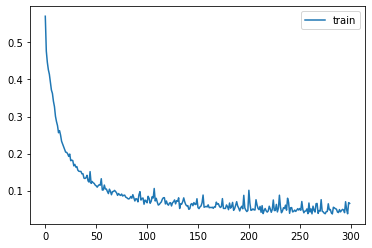

In [96]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

           S    0.98195   0.96797   0.97491       562
           B    0.95964   0.97717   0.96833       438

    accuracy                        0.97200      1000
   macro avg    0.97080   0.97257   0.97162      1000
weighted avg    0.97218   0.97200   0.97203      1000

Confusion matrix, without normalization
[[544  18]
 [ 10 428]]


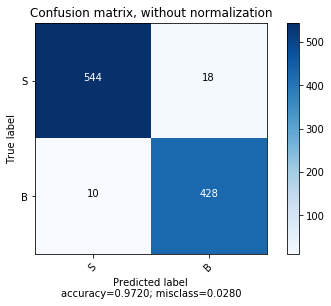

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 

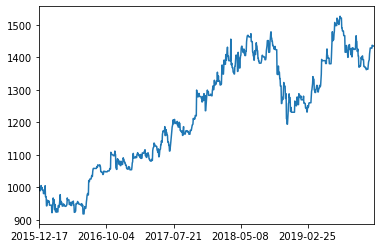

In [97]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 5s 1ms/step - loss: 0.7885 - accuracy: 0.6174
Epoch 2/300
3999/3999 [==============================] - 1s 274us/step - loss: 0.5919 - accuracy: 0.6832
Epoch 3/300
3999/3999 [==============================] - 1s 292us/step - loss: 0.5721 - accuracy: 0.7032
Epoch 4/300
3999/3999 [==============================] - 2s 461us/step - loss: 0.5508 - accuracy: 0.7239
Epoch 5/300
3999/3999 [==============================] - 2s 484us/step - loss: 0.5025 - accuracy: 0.7572
Epoch 6/300
3999/3999 [==============================] - 1s 318us/step - loss: 0.4748 - accuracy: 0.7807
Epoch 7/300
3999/3999 [==============================] - 1s 296us/step - loss: 0.4477 - accuracy: 0.7879
Epoch 8/300
3999/3999 [==============================] - 2s 400us/step - loss: 0.4174 - accuracy: 0.8200
Epoch 9/300
3999/3999 [==============================] - 1s 238us/step - loss: 0.3855 - accuracy: 0.8352
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 1s 288us/step - loss: 0.0901 - accuracy: 0.9700
Epoch 79/300
3999/3999 [==============================] - 1s 306us/step - loss: 0.0810 - accuracy: 0.9742
Epoch 80/300
3999/3999 [==============================] - 1s 280us/step - loss: 0.0495 - accuracy: 0.9837
Epoch 81/300
3999/3999 [==============================] - 2s 411us/step - loss: 0.0436 - accuracy: 0.9870
Epoch 82/300
3999/3999 [==============================] - 2s 449us/step - loss: 0.0613 - accuracy: 0.9792
Epoch 83/300
3999/3999 [==============================] - 2s 426us/step - loss: 0.0599 - accuracy: 0.9832
Epoch 84/300
3999/3999 [==============================] - 2s 432us/step - loss: 0.0445 - accuracy: 0.9860
Epoch 85/300
3999/3999 [==============================] - 1s 348us/step - loss: 0.0420 - accuracy: 0.9880
Epoch 86/300
3999/3999 [==============================] - 1s 326us/step - loss: 0.0393 - accuracy: 0.9897
Epoch 87/300
3999/3999 [==============================] - 2

3999/3999 [==============================] - 1s 316us/step - loss: 0.0380 - accuracy: 0.9865
Epoch 155/300
3999/3999 [==============================] - 1s 266us/step - loss: 0.0432 - accuracy: 0.9885
Epoch 156/300
3999/3999 [==============================] - 1s 291us/step - loss: 0.0638 - accuracy: 0.9792
Epoch 157/300
3999/3999 [==============================] - 1s 328us/step - loss: 0.0568 - accuracy: 0.9800
Epoch 158/300
3999/3999 [==============================] - 1s 299us/step - loss: 0.0468 - accuracy: 0.9852
Epoch 159/300
3999/3999 [==============================] - 2s 412us/step - loss: 0.0760 - accuracy: 0.9777
Epoch 160/300
3999/3999 [==============================] - 2s 569us/step - loss: 0.0761 - accuracy: 0.9790
Epoch 161/300
3999/3999 [==============================] - 2s 524us/step - loss: 0.0603 - accuracy: 0.9782
Epoch 162/300
3999/3999 [==============================] - 2s 548us/step - loss: 0.0359 - accuracy: 0.9887
Epoch 163/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 347us/step - loss: 0.0249 - accuracy: 0.9925
Epoch 231/300
3999/3999 [==============================] - 1s 300us/step - loss: 0.0296 - accuracy: 0.9910
Epoch 232/300
3999/3999 [==============================] - 1s 304us/step - loss: 0.0536 - accuracy: 0.9842
Epoch 233/300
3999/3999 [==============================] - 1s 344us/step - loss: 0.0549 - accuracy: 0.9840
Epoch 234/300
3999/3999 [==============================] - 2s 394us/step - loss: 0.0923 - accuracy: 0.9775
Epoch 235/300
3999/3999 [==============================] - 1s 300us/step - loss: 0.0539 - accuracy: 0.9820
Epoch 236/300
3999/3999 [==============================] - 1s 293us/step - loss: 0.0473 - accuracy: 0.9862
Epoch 237/300
3999/3999 [==============================] - 1s 295us/step - loss: 0.0330 - accuracy: 0.9895
Epoch 238/300
3999/3999 [==============================] - 1s 314us/step - loss: 0.0262 - accuracy: 0.9932
Epoch 239/300
3999/3999 [==========================

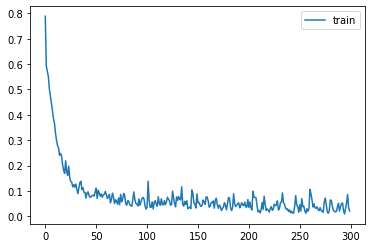

In [98]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 11
              precision    recall  f1-score   support

           S    0.79065   0.75267   0.77119       562
           B    0.70108   0.74429   0.72204       438

    accuracy                        0.74900      1000
   macro avg    0.74586   0.74848   0.74662      1000
weighted avg    0.75142   0.74900   0.74966      1000

Confusion matrix, without normalization
[[423 139]
 [112 326]]


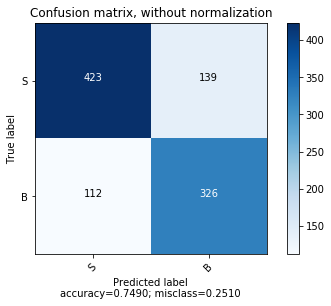

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 

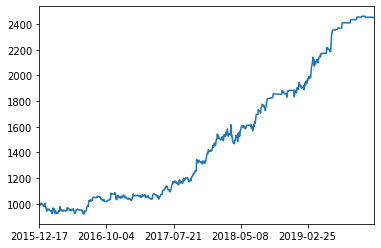

In [99]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.6302 - accuracy: 0.6399
Epoch 2/300
3996/3996 [==============================] - 2s 473us/step - loss: 0.5219 - accuracy: 0.7440
Epoch 3/300
3996/3996 [==============================] - 2s 391us/step - loss: 0.4934 - accuracy: 0.7620
Epoch 4/300
3996/3996 [==============================] - 1s 330us/step - loss: 0.4840 - accuracy: 0.7755
Epoch 5/300
3996/3996 [==============================] - 2s 590us/step - loss: 0.4838 - accuracy: 0.7748
Epoch 6/300
3996/3996 [==============================] - 2s 418us/step - loss: 0.4831 - accuracy: 0.7718
Epoch 7/300
3996/3996 [==============================] - 1s 356us/step - loss: 0.4803 - accuracy: 0.7753
Epoch 8/300
3996/3996 [==============================] - 1s 352us/step - loss: 0.4790 - accuracy: 0.7745
Epoch 9/300
3996/3996 [==============================] - 2s 385us/step - loss: 0.4763 - accuracy: 0.7768
Epoch 10/300
3996/3996 [==============================] -

3996/3996 [==============================] - 1s 372us/step - loss: 0.4114 - accuracy: 0.8081
Epoch 79/300
3996/3996 [==============================] - 1s 346us/step - loss: 0.4137 - accuracy: 0.8081
Epoch 80/300
3996/3996 [==============================] - 2s 479us/step - loss: 0.4129 - accuracy: 0.8131
Epoch 81/300
3996/3996 [==============================] - 2s 435us/step - loss: 0.4144 - accuracy: 0.8068
Epoch 82/300
3996/3996 [==============================] - 2s 620us/step - loss: 0.4120 - accuracy: 0.8123
Epoch 83/300
3996/3996 [==============================] - 2s 431us/step - loss: 0.4121 - accuracy: 0.8093
Epoch 84/300
3996/3996 [==============================] - 2s 396us/step - loss: 0.4148 - accuracy: 0.8098
Epoch 85/300
3996/3996 [==============================] - 2s 568us/step - loss: 0.4102 - accuracy: 0.8113
Epoch 86/300
3996/3996 [==============================] - 3s 796us/step - loss: 0.4108 - accuracy: 0.8126
Epoch 87/300
3996/3996 [==============================] - 2

3996/3996 [==============================] - 2s 506us/step - loss: 0.3813 - accuracy: 0.8283
Epoch 155/300
3996/3996 [==============================] - 2s 613us/step - loss: 0.3831 - accuracy: 0.8246
Epoch 156/300
3996/3996 [==============================] - 3s 667us/step - loss: 0.3788 - accuracy: 0.8278
Epoch 157/300
3996/3996 [==============================] - 3s 783us/step - loss: 0.3798 - accuracy: 0.8231
Epoch 158/300
3996/3996 [==============================] - 2s 619us/step - loss: 0.3812 - accuracy: 0.8293
Epoch 159/300
3996/3996 [==============================] - 2s 511us/step - loss: 0.3777 - accuracy: 0.8343
Epoch 160/300
3996/3996 [==============================] - 2s 495us/step - loss: 0.3767 - accuracy: 0.8296
Epoch 161/300
3996/3996 [==============================] - 2s 439us/step - loss: 0.3789 - accuracy: 0.8266
Epoch 162/300
3996/3996 [==============================] - 2s 473us/step - loss: 0.3761 - accuracy: 0.8313
Epoch 163/300
3996/3996 [==========================

3996/3996 [==============================] - 3s 635us/step - loss: 0.3371 - accuracy: 0.8504
Epoch 231/300
3996/3996 [==============================] - 2s 567us/step - loss: 0.3370 - accuracy: 0.8501
Epoch 232/300
3996/3996 [==============================] - 2s 620us/step - loss: 0.3353 - accuracy: 0.8511
Epoch 233/300
3996/3996 [==============================] - 2s 529us/step - loss: 0.3341 - accuracy: 0.8509
Epoch 234/300
3996/3996 [==============================] - 3s 631us/step - loss: 0.3359 - accuracy: 0.8516
Epoch 235/300
3996/3996 [==============================] - 2s 556us/step - loss: 0.3349 - accuracy: 0.8506
Epoch 236/300
3996/3996 [==============================] - 2s 605us/step - loss: 0.3329 - accuracy: 0.8491
Epoch 237/300
3996/3996 [==============================] - 2s 588us/step - loss: 0.3357 - accuracy: 0.8483
Epoch 238/300
3996/3996 [==============================] - 2s 570us/step - loss: 0.3322 - accuracy: 0.8556
Epoch 239/300
3996/3996 [==========================

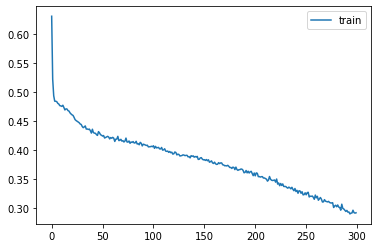

In [100]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

           S    0.80222   0.64235   0.71344       562
           B    0.63455   0.79680   0.70648       438

    accuracy                        0.71000      1000
   macro avg    0.71838   0.71958   0.70996      1000
weighted avg    0.72878   0.71000   0.71039      1000

Confusion matrix, without normalization
[[361 201]
 [ 89 349]]


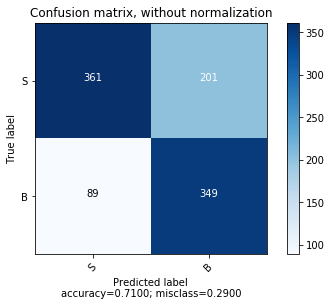

[0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 

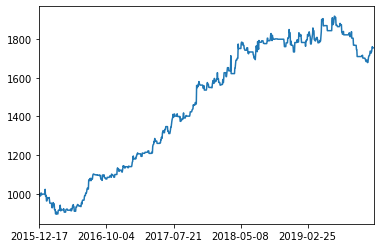

In [101]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.6237 - accuracy: 0.6542
Epoch 2/300
3996/3996 [==============================] - 2s 586us/step - loss: 0.4996 - accuracy: 0.7603
Epoch 3/300
3996/3996 [==============================] - 2s 541us/step - loss: 0.4753 - accuracy: 0.7823
Epoch 4/300
3996/3996 [==============================] - 2s 471us/step - loss: 0.4526 - accuracy: 0.7880
Epoch 5/300
3996/3996 [==============================] - 2s 455us/step - loss: 0.4184 - accuracy: 0.8156
Epoch 6/300
3996/3996 [==============================] - 3s 683us/step - loss: 0.3745 - accuracy: 0.8313
Epoch 7/300
3996/3996 [==============================] - 2s 509us/step - loss: 0.3349 - accuracy: 0.8556
Epoch 8/300
3996/3996 [==============================] - 2s 623us/step - loss: 0.2824 - accuracy: 0.8801
Epoch 9/300
3996/3996 [==============================] - 2s 575us/step - loss: 0.2700 - accuracy: 0.8809
Epoch 10/300
3996/3996 [==============================] -

3996/3996 [==============================] - 4s 900us/step - loss: 0.0735 - accuracy: 0.9700
Epoch 79/300
3996/3996 [==============================] - 3s 825us/step - loss: 0.0823 - accuracy: 0.9675
Epoch 80/300
3996/3996 [==============================] - 4s 880us/step - loss: 0.0781 - accuracy: 0.9720
Epoch 81/300
3996/3996 [==============================] - 4s 881us/step - loss: 0.0626 - accuracy: 0.9782
Epoch 82/300
3996/3996 [==============================] - 3s 860us/step - loss: 0.0665 - accuracy: 0.9735
Epoch 83/300
3996/3996 [==============================] - 3s 831us/step - loss: 0.0616 - accuracy: 0.9810
Epoch 84/300
3996/3996 [==============================] - 4s 934us/step - loss: 0.0611 - accuracy: 0.97800s - loss: 0.0607 - accuracy
Epoch 85/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0687 - accuracy: 0.9712
Epoch 86/300
3996/3996 [==============================] - 3s 744us/step - loss: 0.0547 - accuracy: 0.9825
Epoch 87/300
3996/3996 [=========

3996/3996 [==============================] - 2s 621us/step - loss: 0.0442 - accuracy: 0.9842
Epoch 155/300
3996/3996 [==============================] - 3s 638us/step - loss: 0.0407 - accuracy: 0.9855
Epoch 156/300
3996/3996 [==============================] - 3s 660us/step - loss: 0.0377 - accuracy: 0.9877
Epoch 157/300
3996/3996 [==============================] - 2s 608us/step - loss: 0.0421 - accuracy: 0.9852
Epoch 158/300
3996/3996 [==============================] - 3s 684us/step - loss: 0.0374 - accuracy: 0.9887
Epoch 159/300
3996/3996 [==============================] - 2s 620us/step - loss: 0.0393 - accuracy: 0.9867
Epoch 160/300
3996/3996 [==============================] - 3s 690us/step - loss: 0.0378 - accuracy: 0.9865
Epoch 161/300
3996/3996 [==============================] - 3s 641us/step - loss: 0.0471 - accuracy: 0.9835
Epoch 162/300
3996/3996 [==============================] - 3s 635us/step - loss: 0.0344 - accuracy: 0.9877
Epoch 163/300
3996/3996 [==========================

3996/3996 [==============================] - 5s 1ms/step - loss: 0.0186 - accuracy: 0.9952
Epoch 231/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0203 - accuracy: 0.9942
Epoch 232/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0748 - accuracy: 0.9710
Epoch 233/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0215 - accuracy: 0.9957
Epoch 234/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0165 - accuracy: 0.9975
Epoch 235/300
3996/3996 [==============================] - 3s 841us/step - loss: 0.0187 - accuracy: 0.9942
Epoch 236/300
3996/3996 [==============================] - 3s 780us/step - loss: 0.0145 - accuracy: 0.9967
Epoch 237/300
3996/3996 [==============================] - 4s 944us/step - loss: 0.0147 - accuracy: 0.9967
Epoch 238/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0248 - accuracy: 0.9910
Epoch 239/300
3996/3996 [==============================] - 3s 8

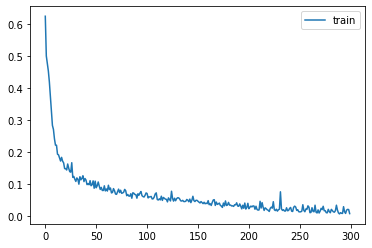

In [102]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

           S    0.95575   0.96085   0.95830       562
           B    0.94943   0.94292   0.94616       438

    accuracy                        0.95300      1000
   macro avg    0.95259   0.95189   0.95223      1000
weighted avg    0.95298   0.95300   0.95298      1000

Confusion matrix, without normalization
[[540  22]
 [ 25 413]]


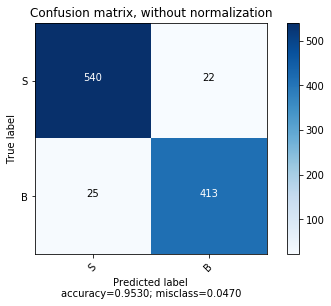

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 

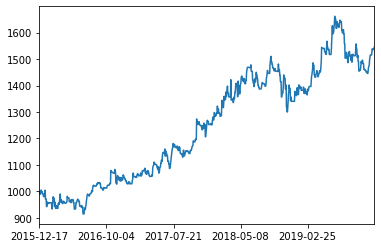

In [103]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 13s 3ms/step - loss: 0.5422 - accuracy: 0.7277
Epoch 2/300
3996/3996 [==============================] - 3s 867us/step - loss: 0.4512 - accuracy: 0.8018
Epoch 3/300
3996/3996 [==============================] - 3s 846us/step - loss: 0.4122 - accuracy: 0.8203
Epoch 4/300
3996/3996 [==============================] - 3s 733us/step - loss: 0.3976 - accuracy: 0.8228
Epoch 5/300
3996/3996 [==============================] - 4s 923us/step - loss: 0.3801 - accuracy: 0.8358
Epoch 6/300
3996/3996 [==============================] - 4s 901us/step - loss: 0.3651 - accuracy: 0.8446
Epoch 7/300
3996/3996 [==============================] - 4s 930us/step - loss: 0.3486 - accuracy: 0.8506
Epoch 8/300
3996/3996 [==============================] - 4s 949us/step - loss: 0.3182 - accuracy: 0.8614
Epoch 9/300
3996/3996 [==============================] - 4s 909us/step - loss: 0.3051 - accuracy: 0.8664
Epoch 10/300
3996/3996 [==============================] 

Epoch 79/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0635 - accuracy: 0.9787
Epoch 80/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0370 - accuracy: 0.9900
Epoch 81/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0430 - accuracy: 0.9850
Epoch 82/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0417 - accuracy: 0.9860
Epoch 83/300
3996/3996 [==============================] - 4s 954us/step - loss: 0.0396 - accuracy: 0.9877
Epoch 84/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0444 - accuracy: 0.9850
Epoch 85/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0426 - accuracy: 0.9862
Epoch 86/300
3996/3996 [==============================] - 4s 994us/step - loss: 0.0437 - accuracy: 0.9820
Epoch 87/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0459 - accuracy: 0.9865
Epoch 88/300
3996/3996 [==============================] - 4s

3996/3996 [==============================] - 4s 904us/step - loss: 0.0054 - accuracy: 0.9992
Epoch 158/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 159/300
3996/3996 [==============================] - 4s 897us/step - loss: 0.0066 - accuracy: 0.9987
Epoch 160/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0228 - accuracy: 0.9920
Epoch 161/300
3996/3996 [==============================] - 4s 953us/step - loss: 0.0265 - accuracy: 0.9905
Epoch 162/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0093 - accuracy: 0.9982
Epoch 163/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0064 - accuracy: 0.9995
Epoch 164/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0056 - accuracy: 0.9990
Epoch 165/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0095 - accuracy: 0.9970
Epoch 166/300
3996/3996 [==============================] - 5s 1

Epoch 234/300
3996/3996 [==============================] - 5s 1ms/step - loss: 2.6410e-04 - accuracy: 1.0000
Epoch 235/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0440 - accuracy: 0.9840
Epoch 236/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0523 - accuracy: 0.9815
Epoch 237/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0260 - accuracy: 0.9917
Epoch 238/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0079 - accuracy: 0.9992
Epoch 239/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0092 - accuracy: 0.9975
Epoch 240/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 241/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 242/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 243/300
3996/3996 [==========================

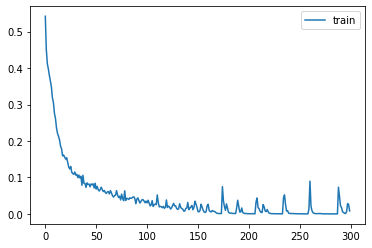

In [104]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

           S    0.92568   0.97509   0.94974       562
           B    0.96569   0.89954   0.93144       438

    accuracy                        0.94200      1000
   macro avg    0.94568   0.93732   0.94059      1000
weighted avg    0.94320   0.94200   0.94173      1000

Confusion matrix, without normalization
[[548  14]
 [ 44 394]]


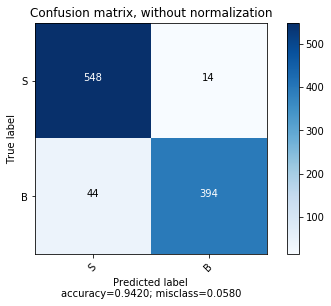

[0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 

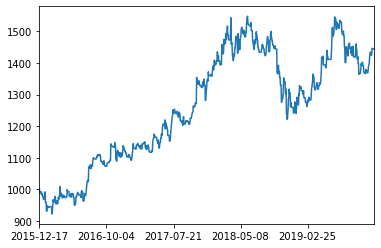

In [105]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 14s 3ms/step - loss: 0.7793 - accuracy: 0.6594
Epoch 2/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.5338 - accuracy: 0.7365
Epoch 3/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.4464 - accuracy: 0.7963
Epoch 4/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.4204 - accuracy: 0.8148
Epoch 5/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.4018 - accuracy: 0.8266
Epoch 6/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.3779 - accuracy: 0.8391
Epoch 7/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.3648 - accuracy: 0.8403
Epoch 8/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.3503 - accuracy: 0.8504
Epoch 9/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.3482 - accuracy: 0.8501
Epoch 10/300
3996/3996 [==============================] - 5s 1ms/step - 

3996/3996 [==============================] - 6s 2ms/step - loss: 0.0400 - accuracy: 0.9882
Epoch 80/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0343 - accuracy: 0.9915
Epoch 81/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0534 - accuracy: 0.9835
Epoch 82/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0503 - accuracy: 0.9845
Epoch 83/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.0539 - accuracy: 0.9837
Epoch 84/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0397 - accuracy: 0.9880
Epoch 85/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.0326 - accuracy: 0.9907
Epoch 86/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0557 - accuracy: 0.9812
Epoch 87/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0439 - accuracy: 0.9847
Epoch 88/300
3996/3996 [==============================] - 6s 2ms/step - loss:

Epoch 157/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0251 - accuracy: 0.9917
Epoch 158/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0149 - accuracy: 0.9965
Epoch 159/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0078 - accuracy: 0.9985
Epoch 160/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.0470 - accuracy: 0.9837
Epoch 161/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0333 - accuracy: 0.9885
Epoch 162/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0186 - accuracy: 0.9945
Epoch 163/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.0354 - accuracy: 0.9875
Epoch 164/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0556 - accuracy: 0.9857
Epoch 165/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.0656 - accuracy: 0.9800
Epoch 166/300
3996/3996 [==============================

3996/3996 [==============================] - 8s 2ms/step - loss: 0.0177 - accuracy: 0.9952
Epoch 235/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0218 - accuracy: 0.9925
Epoch 236/300
3996/3996 [==============================] - 13s 3ms/step - loss: 0.0436 - accuracy: 0.9852
Epoch 237/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0553 - accuracy: 0.9805
Epoch 238/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0375 - accuracy: 0.9877
Epoch 239/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0343 - accuracy: 0.9895
Epoch 240/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0208 - accuracy: 0.9955
Epoch 241/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0360 - accuracy: 0.9922
Epoch 242/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0358 - accuracy: 0.9892
Epoch 243/300
3996/3996 [==============================] - 8s 2ms/st

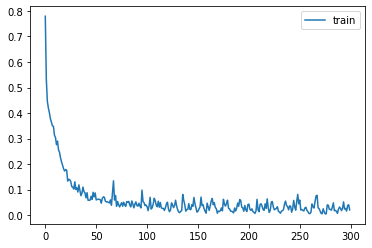

In [106]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 11
              precision    recall  f1-score   support

           S    0.84412   0.62633   0.71910       562
           B    0.63979   0.85160   0.73066       438

    accuracy                        0.72500      1000
   macro avg    0.74196   0.73897   0.72488      1000
weighted avg    0.75463   0.72500   0.72416      1000

Confusion matrix, without normalization
[[352 210]
 [ 65 373]]


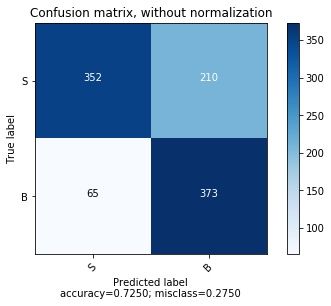

[0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 

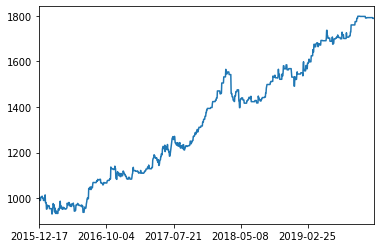

In [107]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 22s 5ms/step - loss: 0.6112 - accuracy: 0.6706
Epoch 2/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.5182 - accuracy: 0.7575
Epoch 3/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.4979 - accuracy: 0.7613
Epoch 4/300
3992/3992 [==============================] - 8s 2ms/step - loss: 0.4927 - accuracy: 0.7776
Epoch 5/300
3992/3992 [==============================] - 8s 2ms/step - loss: 0.4893 - accuracy: 0.7670
Epoch 6/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.4846 - accuracy: 0.7730
Epoch 7/300
3992/3992 [==============================] - 8s 2ms/step - loss: 0.4838 - accuracy: 0.7728
Epoch 8/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.4817 - accuracy: 0.7743
Epoch 9/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.4799 - accuracy: 0.7761
Epoch 10/300
3992/3992 [==============================] - 6s 2ms/step - 

3992/3992 [==============================] - 7s 2ms/step - loss: 0.3153 - accuracy: 0.8622
Epoch 80/300
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3089 - accuracy: 0.8657
Epoch 81/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.3076 - accuracy: 0.8695
Epoch 82/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.3040 - accuracy: 0.8687
Epoch 83/300
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3053 - accuracy: 0.8667
Epoch 84/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.3065 - accuracy: 0.8642
Epoch 85/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.3089 - accuracy: 0.8617
Epoch 86/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.2955 - accuracy: 0.8717
Epoch 87/300
3992/3992 [==============================] - 6s 2ms/step - loss: 0.2929 - accuracy: 0.8747
Epoch 88/300
3992/3992 [==============================] - 6s 2ms/step - loss:

3992/3992 [==============================] - 5s 1ms/step - loss: 0.1066 - accuracy: 0.9614
Epoch 158/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.1010 - accuracy: 0.9642
Epoch 159/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.1244 - accuracy: 0.9527
Epoch 160/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.1147 - accuracy: 0.9524
Epoch 161/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.1111 - accuracy: 0.9574
Epoch 162/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.0946 - accuracy: 0.9634
Epoch 163/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.1044 - accuracy: 0.9604
Epoch 164/300
3992/3992 [==============================] - 4s 1ms/step - loss: 0.1158 - accuracy: 0.9584
Epoch 165/300
3992/3992 [==============================] - 4s 1ms/step - loss: 0.1151 - accuracy: 0.9552
Epoch 166/300
3992/3992 [==============================] - 4s 1ms/ste

3992/3992 [==============================] - 5s 1ms/step - loss: 0.0254 - accuracy: 0.9937
Epoch 236/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.0195 - accuracy: 0.9947
Epoch 237/300
3992/3992 [==============================] - 6s 1ms/step - loss: 0.0236 - accuracy: 0.9930
Epoch 238/300
3992/3992 [==============================] - 6s 1ms/step - loss: 0.0646 - accuracy: 0.9765
Epoch 239/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.0416 - accuracy: 0.9862
Epoch 240/300
3992/3992 [==============================] - 6s 1ms/step - loss: 0.0861 - accuracy: 0.9704
Epoch 241/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.0460 - accuracy: 0.9845
Epoch 242/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.0433 - accuracy: 0.9870
Epoch 243/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.0187 - accuracy: 0.9952
Epoch 244/300
3992/3992 [==============================] - 5s 1ms/ste

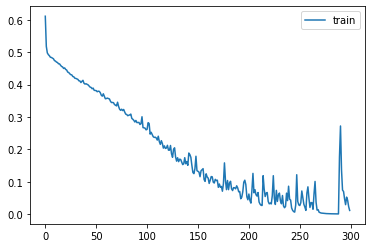

In [108]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

           S    0.70690   0.80392   0.75229       561
           B    0.69529   0.57306   0.62829       438

    accuracy                        0.70270       999
   macro avg    0.70109   0.68849   0.69029       999
weighted avg    0.70181   0.70270   0.69792       999

Confusion matrix, without normalization
[[451 110]
 [187 251]]


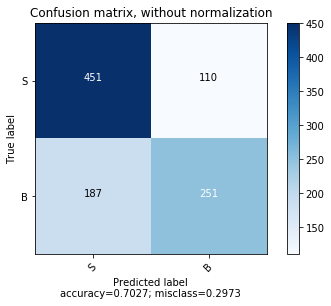

[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 

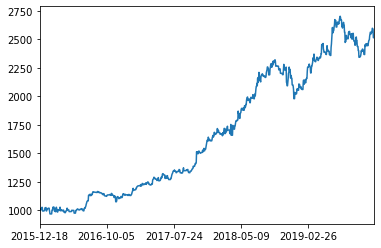

In [109]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.6224 - accuracy: 0.6613
Epoch 2/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.5128 - accuracy: 0.7565
Epoch 3/300
3992/3992 [==============================] - 11s 3ms/step - loss: 0.4802 - accuracy: 0.7786
Epoch 4/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.4679 - accuracy: 0.7846
Epoch 5/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.4461 - accuracy: 0.7986
Epoch 6/300
3992/3992 [==============================] - 10s 3ms/step - loss: 0.3911 - accuracy: 0.8234
Epoch 7/300
3992/3992 [==============================] - 11s 3ms/step - loss: 0.3087 - accuracy: 0.8712
Epoch 8/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.2627 - accuracy: 0.8953
Epoch 9/300
3992/3992 [==============================] - 11s 3ms/step - loss: 0.2539 - accuracy: 0.8965
Epoch 10/300
3992/3992 [==============================] - 12s 3m

3992/3992 [==============================] - 12s 3ms/step - loss: 0.0605 - accuracy: 0.9777
Epoch 79/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.0767 - accuracy: 0.9712
Epoch 80/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0628 - accuracy: 0.9757
Epoch 81/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.0592 - accuracy: 0.9780
Epoch 82/300
3992/3992 [==============================] - 14s 3ms/step - loss: 0.0559 - accuracy: 0.9805
Epoch 83/300
3992/3992 [==============================] - 16s 4ms/step - loss: 0.0555 - accuracy: 0.9797
Epoch 84/300
3992/3992 [==============================] - 11s 3ms/step - loss: 0.0517 - accuracy: 0.9820
Epoch 85/300
3992/3992 [==============================] - 16s 4ms/step - loss: 0.0607 - accuracy: 0.9742
Epoch 86/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.0592 - accuracy: 0.9790
Epoch 87/300
3992/3992 [==============================] - 10s 3ms/st

3992/3992 [==============================] - 14s 3ms/step - loss: 0.0361 - accuracy: 0.9875
Epoch 156/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0271 - accuracy: 0.9907
Epoch 157/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0279 - accuracy: 0.9920
Epoch 158/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0333 - accuracy: 0.9887
Epoch 159/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0316 - accuracy: 0.9917
Epoch 160/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0231 - accuracy: 0.9942
Epoch 161/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0247 - accuracy: 0.9927
Epoch 162/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0256 - accuracy: 0.9910
Epoch 163/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0270 - accuracy: 0.9907
Epoch 164/300
3992/3992 [==============================] - 1

3992/3992 [==============================] - 12s 3ms/step - loss: 0.0095 - accuracy: 0.9977
Epoch 233/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0145 - accuracy: 0.9962
Epoch 234/300
3992/3992 [==============================] - 11s 3ms/step - loss: 0.0063 - accuracy: 0.9997
Epoch 235/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0043 - accuracy: 0.9997
Epoch 236/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 237/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.0050 - accuracy: 0.9992
Epoch 238/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.0542 - accuracy: 0.9795
Epoch 239/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0172 - accuracy: 0.9955
Epoch 240/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0080 - accuracy: 0.9990
Epoch 241/300
3992/3992 [==============================] - 1

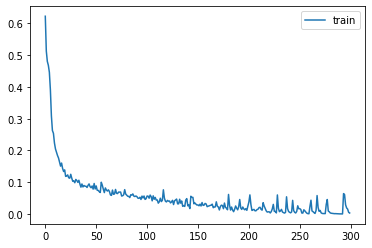

In [110]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

           S    0.93686   0.97861   0.95728       561
           B    0.97094   0.91553   0.94242       438

    accuracy                        0.95095       999
   macro avg    0.95390   0.94707   0.94985       999
weighted avg    0.95180   0.95095   0.95077       999

Confusion matrix, without normalization
[[549  12]
 [ 37 401]]


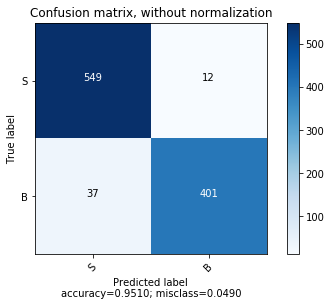

[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 

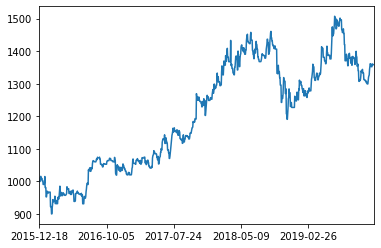

In [111]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 26s 6ms/step - loss: 0.5723 - accuracy: 0.7019
Epoch 2/300
3992/3992 [==============================] - 15s 4ms/step - loss: 0.4815 - accuracy: 0.7793
Epoch 3/300
3992/3992 [==============================] - 15s 4ms/step - loss: 0.4265 - accuracy: 0.8146
Epoch 4/300
3992/3992 [==============================] - 15s 4ms/step - loss: 0.4054 - accuracy: 0.8134
Epoch 5/300
3992/3992 [==============================] - 14s 3ms/step - loss: 0.3850 - accuracy: 0.8312
Epoch 6/300
3992/3992 [==============================] - 18s 4ms/step - loss: 0.3731 - accuracy: 0.8374
Epoch 7/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.3591 - accuracy: 0.8414
Epoch 8/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.3392 - accuracy: 0.8520
Epoch 9/300
3992/3992 [==============================] - 15s 4ms/step - loss: 0.3179 - accuracy: 0.8600
Epoch 10/300
3992/3992 [==============================] - 13s 3m

3992/3992 [==============================] - 17s 4ms/step - loss: 0.0215 - accuracy: 0.9945
Epoch 79/300
3992/3992 [==============================] - 17s 4ms/step - loss: 0.0417 - accuracy: 0.9890
Epoch 80/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0178 - accuracy: 0.9962
Epoch 81/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0113 - accuracy: 0.9985
Epoch 82/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0141 - accuracy: 0.9957
Epoch 83/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0183 - accuracy: 0.9957
Epoch 84/300
3992/3992 [==============================] - 21s 5ms/step - loss: 0.0228 - accuracy: 0.9945
Epoch 85/300
3992/3992 [==============================] - 21s 5ms/step - loss: 0.0172 - accuracy: 0.9960
Epoch 86/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0180 - accuracy: 0.9957
Epoch 87/300
3992/3992 [==============================] - 21s 5ms/st

3992/3992 [==============================] - 20s 5ms/step - loss: 1.5150e-05 - accuracy: 1.0000
Epoch 162/300
3992/3992 [==============================] - 20s 5ms/step - loss: 1.4454e-05 - accuracy: 1.0000
Epoch 163/300
3992/3992 [==============================] - 20s 5ms/step - loss: 1.3030e-05 - accuracy: 1.0000
Epoch 164/300
3992/3992 [==============================] - 20s 5ms/step - loss: 1.1877e-05 - accuracy: 1.0000
Epoch 165/300
3992/3992 [==============================] - 20s 5ms/step - loss: 1.1522e-05 - accuracy: 1.0000
Epoch 166/300
3992/3992 [==============================] - 20s 5ms/step - loss: 1.0399e-05 - accuracy: 1.0000
Epoch 167/300
3992/3992 [==============================] - 20s 5ms/step - loss: 9.9494e-06 - accuracy: 1.0000
Epoch 168/300
3992/3992 [==============================] - 20s 5ms/step - loss: 9.4765e-06 - accuracy: 1.0000
Epoch 169/300
3992/3992 [==============================] - 19s 5ms/step - loss: 8.3100e-06 - accuracy: 1.0000
Epoch 170/300
3992/3992 

3992/3992 [==============================] - 20s 5ms/step - loss: 3.2967e-05 - accuracy: 1.0000
Epoch 237/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.1144 - accuracy: 0.9629
Epoch 238/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0550 - accuracy: 0.9825
Epoch 239/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0320 - accuracy: 0.9887
Epoch 240/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0192 - accuracy: 0.9957
Epoch 241/300
3992/3992 [==============================] - 19s 5ms/step - loss: 0.0162 - accuracy: 0.9955
Epoch 242/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0266 - accuracy: 0.9910
Epoch 243/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0100 - accuracy: 0.9985
Epoch 244/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 245/300
3992/3992 [==============================]

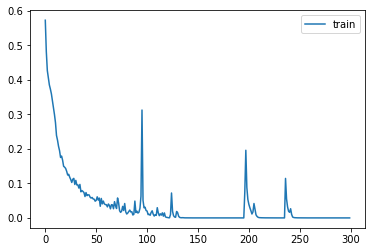

In [112]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

           S    0.91806   0.87879   0.89800       561
           B    0.85281   0.89954   0.87556       438

    accuracy                        0.88789       999
   macro avg    0.88544   0.88917   0.88678       999
weighted avg    0.88946   0.88789   0.88816       999

Confusion matrix, without normalization
[[493  68]
 [ 44 394]]


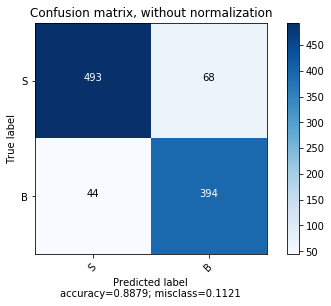

[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 

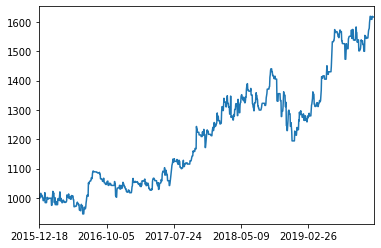

In [113]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 55s 14ms/step - loss: 1.0165 - accuracy: 0.6100
Epoch 2/300
3992/3992 [==============================] - 34s 9ms/step - loss: 0.5650 - accuracy: 0.7029
Epoch 3/300
3992/3992 [==============================] - 28s 7ms/step - loss: 0.5174 - accuracy: 0.7470
Epoch 4/300
3992/3992 [==============================] - 25s 6ms/step - loss: 0.4817 - accuracy: 0.7725
Epoch 5/300
3992/3992 [==============================] - 25s 6ms/step - loss: 0.4502 - accuracy: 0.7981
Epoch 6/300
3992/3992 [==============================] - 30s 7ms/step - loss: 0.4183 - accuracy: 0.8126
Epoch 7/300
3992/3992 [==============================] - 24s 6ms/step - loss: 0.4038 - accuracy: 0.8204
Epoch 8/300
3992/3992 [==============================] - 24s 6ms/step - loss: 0.3855 - accuracy: 0.8302
Epoch 9/300
3992/3992 [==============================] - 26s 6ms/step - loss: 0.3665 - accuracy: 0.8389
Epoch 10/300
3992/3992 [==============================] - 36s 9

3992/3992 [==============================] - 33s 8ms/step - loss: 0.0718 - accuracy: 0.9767
Epoch 80/300
3992/3992 [==============================] - 34s 8ms/step - loss: 0.0678 - accuracy: 0.9792
Epoch 81/300
3992/3992 [==============================] - 35s 9ms/step - loss: 0.0815 - accuracy: 0.9727
Epoch 82/300
3992/3992 [==============================] - 34s 9ms/step - loss: 0.0624 - accuracy: 0.9795
Epoch 83/300
3992/3992 [==============================] - 33s 8ms/step - loss: 0.0662 - accuracy: 0.9817
Epoch 84/300
3992/3992 [==============================] - 30s 7ms/step - loss: 0.0792 - accuracy: 0.9732
Epoch 85/300
3992/3992 [==============================] - 30s 7ms/step - loss: 0.1090 - accuracy: 0.9707
Epoch 86/300
3992/3992 [==============================] - 36s 9ms/step - loss: 0.0604 - accuracy: 0.9805
Epoch 87/300
3992/3992 [==============================] - 40s 10ms/step - loss: 0.0505 - accuracy: 0.9852
Epoch 88/300
3992/3992 [==============================] - 40s 10ms/

3992/3992 [==============================] - 41s 10ms/step - loss: 0.0372 - accuracy: 0.9862
Epoch 157/300
3992/3992 [==============================] - 39s 10ms/step - loss: 0.0321 - accuracy: 0.9922
Epoch 158/300
3992/3992 [==============================] - 38s 10ms/step - loss: 0.0258 - accuracy: 0.9920
Epoch 159/300
3992/3992 [==============================] - 44s 11ms/step - loss: 0.0218 - accuracy: 0.9945
Epoch 160/300
3992/3992 [==============================] - 54s 14ms/step - loss: 0.0271 - accuracy: 0.9912
Epoch 161/300
3992/3992 [==============================] - 41s 10ms/step - loss: 0.0282 - accuracy: 0.9922
Epoch 162/300
3992/3992 [==============================] - 42s 11ms/step - loss: 0.0517 - accuracy: 0.9800
Epoch 163/300
3992/3992 [==============================] - 42s 11ms/step - loss: 0.0651 - accuracy: 0.9752
Epoch 164/300
3992/3992 [==============================] - 42s 11ms/step - loss: 0.0652 - accuracy: 0.9770
Epoch 165/300
3992/3992 [==========================

3992/3992 [==============================] - 40s 10ms/step - loss: 0.0665 - accuracy: 0.9762
Epoch 233/300
3992/3992 [==============================] - 38s 9ms/step - loss: 0.0480 - accuracy: 0.9842
Epoch 234/300
3992/3992 [==============================] - 37s 9ms/step - loss: 0.0357 - accuracy: 0.9895
Epoch 235/300
3992/3992 [==============================] - 37s 9ms/step - loss: 0.0262 - accuracy: 0.9932
Epoch 236/300
3992/3992 [==============================] - 37s 9ms/step - loss: 0.0583 - accuracy: 0.9815
Epoch 237/300
3992/3992 [==============================] - 37s 9ms/step - loss: 0.0206 - accuracy: 0.9942
Epoch 238/300
3992/3992 [==============================] - 37s 9ms/step - loss: 0.0299 - accuracy: 0.9907
Epoch 239/300
3992/3992 [==============================] - 37s 9ms/step - loss: 0.0208 - accuracy: 0.9932
Epoch 240/300
3992/3992 [==============================] - 37s 9ms/step - loss: 0.0135 - accuracy: 0.9965
Epoch 241/300
3992/3992 [==============================] - 

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)